## 1 Load packages and data

In [1]:
import glob
import numpy as np
import pandas as pd
import h5flow
import h5py
import matplotlib.pyplot as plt
import yaml
import os

import plotly.graph_objects as go
import matplotlib.cm as cm
import matplotlib
import csv

from h5flow.data import dereference
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.cm import ScalarMappable
from sklearn.cluster import DBSCAN
import numpy as np

plot_dir = 'pde_plots'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

save_dir = 'pde_files'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


In [11]:
#Load data

# folder selected muons
directory_selected_muons = "/global/homes/m/mnuland/backtracking/light-efficiency/pde_ndlar_prototype/pde_2x2/"
mu_file_pattern = "*.csv"
file_list_muons = sorted(glob.glob(os.path.join(directory_selected_muons, mu_file_pattern)))

# directories containing all .hdf5 files of cosmics data
directory1 = "/global/cfs/cdirs/dune/www/data/2x2/sandbox/v11/flow/"
# directory2 = "/global/cfs/cdirs/dune/www/data/FSD/reflows/v7/flow/cosmics/08Nov2024/"
file_pattern = "packet-0050017-2024_07_09_01_14_40_CDT.FLOW.hdf5"

file_list1 = sorted(glob.glob(os.path.join(directory1, file_pattern)))
# file_list2 = sorted(glob.glob(os.path.join(directory2, file_pattern)))
file_list = file_list1 #+ file_list2

# Create a dictionary for FAST filename lookup
# e.g. "packet-0020113-2024_11_07_19_47_26_CET.FLOW_v7.hdf5" -> full path
hdf5_map = {os.path.basename(path): path for path in file_list}

rank = 0 #replace this with int(os.environ["SLURM_PROCID"] when using SLURM on nersc

csv_file = file_list_muons[rank]

csv_basename = os.path.basename(csv_file) # Get only the filename: packet-xxx.hdf5.csv

hdf5_name = csv_basename.replace(".csv", "") # Remove the trailing ".csv"

hdf5_path = hdf5_map.get(hdf5_name) # Look up the corresponding HDF5 path

df_mu = pd.read_csv(csv_file) # load the csv of muon selections
p_events = df_mu["ev_id"].astype(int).tolist()# load event IDs from the CSV

f = h5flow.data.H5FlowDataManager(hdf5_path, "r")



## 2 Functions

### 2.1 2x2 light fraction calculation

In [12]:
# Approach 2x2
def compute_light_fraction(x, y, z, dE, x0, x1, y0, y1, z_det):
    """
    Compute the fraction of scintillation light reaching a rectangular detector
    from a muon track in liquid argon, considering recombination and geometry.

    Parameters:
        x, y, z : arrays of muon track coordinates (length N)
        dE : array of energy deposited at each step (length N-1 or N)
        x0, x1, y0, y1 : float, detector boundaries in x and y
        z_det : float, z-position of detector plane

    Returns:
        float: fraction of total scintillation light that reaches the detector
    """
    # Constants
    Y_gamma = 24000           # photons per MeV at 500 V/cm
    # Y_gamma = 68400           # photons per MeV at 500 V/cm
    # Y_gamma =             # photons per MeV at 500 V/cm for MPV
    alpha = 0.093             # recombination parameter (1/MeV⋅cm)
    dEdx_muon = 2.1           # MeV/cm, MIP energy loss in LAr
    total_produced = 0.0
    total_detected = 0.0

    # Loop over segments between consecutive track points
    for i in range(len(x) - 1):
        # Step midpoint (photon emission assumed here)
        x_mid = 0.5 * (x[i] + x[i+1])
        y_mid = 0.5 * (y[i] + y[i+1])
        z_mid = 0.5 * (z[i] + z[i+1])
        
        # Step length
        dx = x[i+1] - x[i]
        dy = y[i+1] - y[i]
        dz = z[i+1] - z[i]
        step_length = np.sqrt(dx**2 + dy**2 + dz**2)  # cm

        if step_length == 0:
            continue  # skip degenerate step

        if dE[i] < 0:
            dE[i] = 0.0 # ignore negative energy depositions

        # Local dE/dx and recombination correction
        epsilon = 1e-2  # small number to prevent divide-by-zero
        #dedx_local = dE[i] / step_length if (step_length > epsilon and dE[i]>0) else dEdx_muon # MeV/cm
        dedx_local = dEdx_muon
        R = np.log(1 + alpha / dedx_local) / (alpha / dedx_local)
        # Total photons produced in this step
        #N_gamma = Y_gamma * dE[i]*1.4 * R 
        N_gamma = Y_gamma * dEdx_muon*step_length * R 
        total_produced += N_gamma

        # Compute analytical solid angle from step coordinates to detector
        omega = solid_angle_rectangle(x_mid, y_mid, z_mid, x0, x1, y0, y1, z_det)
        #omega = solid_angle_rect_asin_grid_zplane(x_mid, y_mid, z_mid, x0, x1, y0, y1, z_det) #livio
        
        if omega < 0:
            omega = 0.0
            print("Warning: Solid angle is negative. Check geometry.")
        fraction_reaching = omega / (4 * np.pi)
        total_detected += fraction_reaching * N_gamma

    return total_detected, total_produced, total_detected / total_produced if total_produced > 0 else 0.0

def solid_angle_rectangle(x_s, y_s, z_s, x0, x1, y0, y1, z_det):
    """
    Compute the solid angle subtended by a rectangle at position z_det
    as seen from point (x_s, y_s, z_s), using analytical geometry.

    Returns:
        float: solid angle in steradians
    """
    z = np.abs(z_det - z_s)
    omega = 0.0
    for i, xi in enumerate([x0, x1]):
        for j, yj in enumerate([y0, y1]):
            sign = (-1)**(i + j)
            dx = xi - x_s
            dy = yj - y_s
            r = np.sqrt(dx**2 + dy**2 + z**2)
            if z != 0:
                omega += sign * np.arctan((dx * dy) / (z * r))
    return omega


In [13]:
print(hdf5_name)

packet-0050017-2024_07_09_01_14_40_CDT.FLOW.hdf5


In [14]:
print(f["charge/events/data"]["id"])

[   0    1    2 ... 9557 9558 9559]


### 2.2 3D linefit (Jans original code)

In [15]:
#### with linearfit
def line_fit_3d_segment_midpoints(x, y, z, seg_length):
    """
    Fit a straight line in 3D using PCA (SVD), segment it,
    and return midpoints + segment lengths.
    """

    if len(x) < 2:
        print("no charge hits!!!!!!!!!!!! to fit")
        return [], [], [],[] 

    # --- 1) Fit straight line via SVD (total least squares) ---
    pts = np.column_stack((x, y, z))  # (N, 3)
    centroid = pts.mean(axis=0)

    # SVD of centered coordinates
    _, _, vt = np.linalg.svd(pts - centroid)
    direction = vt[0]                # principal direction
    direction /= np.linalg.norm(direction)

    # --- 2) Compute t = projection of each point onto the fitted line ---
    # Equivalent to dot(pts[i] - centroid, direction) for each i
    dx = pts[:, 0] - centroid[0]
    dy = pts[:, 1] - centroid[1]
    dz = pts[:, 2] - centroid[2]

    t = dx * direction[0] + dy * direction[1] + dz * direction[2]

    t_min, t_max = t.min(), t.max()
    total_length = t_max - t_min

    if total_length <= 0:
        raise ValueError("All points are identical or degenerate.")

    # --- 3) Build segment edges along fitted line ---
    t_edges = np.arange(t_min, t_max, seg_length)
    if t_edges[-1] < t_max:
        t_edges = np.append(t_edges, t_max)

    # Midpoints in parameter space
    t_mid = 0.5 * (t_edges[:-1] + t_edges[1:])

    # --- 4) Convert midpoints into 3D coordinates explicitly ---
    x_mid = centroid[0] + t_mid * direction[0]
    y_mid = centroid[1] + t_mid * direction[1]
    z_mid = centroid[2] + t_mid * direction[2]

    # Segment lengths (straight along t)
    step_length = np.diff(t_edges)

    return x_mid, y_mid, z_mid, step_length

def compute_light_fraction_w_liner_fit(x, y, z, dE, x0, x1, y0, y1, z_det):
    """
    Compute the fraction of scintillation light reaching a rectangular detector
    from a muon track in liquid argon, considering recombination and geometry.

    Parameters:
        x, y, z : arrays of muon track coordinates (length N)
        dE : array of energy deposited at each step (length N-1 or N)
        x0, x1, y0, y1 : float, detector boundaries in x and y
        z_det : float, z-position of detector plane

    Returns:
        float: fraction of total scintillation light that reaches the detector
    """
    # Constants
    Y_gamma = 24000           # photons per MeV at 500 V/cm
    # Y_gamma = 68400           # photons per MeV at 500 V/cm
    # Y_gamma =             # photons per MeV at 500 V/cm for MPV
    alpha = 0.093             # recombination parameter (1/MeV⋅cm)
    dEdx_muon = 2.1           # MeV/cm, MIP energy loss in LAr
    total_produced = 0.0
    total_detected = 0.0

    seg_length = 0.1 #cm

    x_mid_a, y_mid_a, z_mid_a, step_length_a = line_fit_3d_segment_midpoints(x, y, z, seg_length)


    # Loop over segments between consecutive track points
    for i in range(len(x_mid_a)):
        # Step midpoint (photon emission assumed here)
        x_mid = x_mid_a[i]
        y_mid = y_mid_a[i]
        z_mid = z_mid_a[i]

        step_length = step_length_a[i]  # cm

        if step_length == 0:
            continue  # skip degenerate step

        #if dE[i] < 0:
        #    dE[i] = 0.0 # ignore negative energy depositions

        # Local dE/dx and recombination correction
        epsilon = 1e-2  # small number to prevent divide-by-zero
        #dedx_local = dE[i] / step_length if (step_length > epsilon and dE[i]>0) else dEdx_muon # MeV/cm
        dedx_local = dEdx_muon
        R = np.log(1 + alpha / dedx_local) / (alpha / dedx_local)
        # Total photons produced in this step
        #N_gamma = Y_gamma * dE[i] * R
        N_gamma = Y_gamma * dEdx_muon*step_length * R 
        total_produced += N_gamma

        # Compute analytical solid angle from step coordinates to detector
        omega = solid_angle_rectangle(x_mid, y_mid, z_mid, x0, x1, y0, y1, z_det)
        #omega = solid_angle_rect_asin_grid_zplane(x_mid, y_mid, z_mid, x0, x1, y0, y1, z_det) #livio

        if omega < 0:
            omega = 0.0
            print("Warning: Solid angle is negative. Check geometry.")
        fraction_reaching = omega / (4 * np.pi)
        total_detected += fraction_reaching * N_gamma

    return total_detected, total_produced, total_detected / total_produced if total_produced > 0 else 0.0


def compute_light_fraction_from_line_midpoints(x_mid, y_mid, z_mid, step_length,
                                               x0, x1, y0, y1, z_det):
    """
    Compute expected light for a rectangular detector from a pre-defined
    straight track, given by segment midpoints and lengths.

    Parameters
    ----------
    x_mid, y_mid, z_mid : 1D arrays
        Segment midpoints (cm).
    step_length : 1D array
        Segment lengths (cm), same length as x_mid.
    x0, x1, y0, y1 : float
        Detector rectangle boundaries in x and y.
    z_det : float
        z position of detector plane.

    Returns
    -------
    total_detected, total_produced, fraction_detected
    """
    # Constants
    Y_gamma = 24000       # photons per MeV at 500 V/cm
    alpha   = 0.093       # recombination parameter (1/MeV·cm)
    dEdx_muon = 2.1       # MeV/cm, MIP energy loss in LAr

    total_produced = 0.0
    total_detected = 0.0

    # recombination factor for MIP
    R = np.log(1 + alpha / dEdx_muon) / (alpha / dEdx_muon)

    for xm, ym, zm, L in zip(x_mid, y_mid, z_mid, step_length):
        if L <= 0:
            continue

        # photons in this segment
        N_gamma = Y_gamma * dEdx_muon * L * R
        total_produced += N_gamma

        # solid angle from this segment to the rectangle
        omega = solid_angle_rectangle(xm, ym, zm, x0, x1, y0, y1, z_det)
        if omega < 0:
            omega = 0.0

        frac = omega / (4 * np.pi)
        total_detected += frac * N_gamma

    fraction = total_detected / total_produced if total_produced > 0 else 0.0
    return total_detected, total_produced, fraction


def plot_light_on_detectors(x, y, z, dE, detector_rects, z_dets, ax=None):
    """
    Plot the muon track and rectangles (detectors) with shading based on received light.

    Parameters:
        x, y, z : muon track hit coordinates
        dE : energy deposition at each hit
        detector_rects : list of tuples [(x0, y0, x1, y1), ...] #(x_min, y_min, x_max, y_max)
        z_dets : list of z positions of the detector planes
    """
    results = []  # Store (x0, y0, x1, y1, z_det, fraction)
    # Compute light fraction for each rectangle at each z plane
    for z_det in z_dets:
        for (x0, y0, x1, y1) in detector_rects:
            #det, prod, frac = compute_light_fraction(x, y, z, dE, x0, x1, y0, y1, z_det)
            det, prod, frac = compute_light_fraction_w_liner_fit(x, y, z, dE, x0, x1, y0, y1, z_det) 
            # old one: det, prod, frac = compute_light_fraction(x, y, z, dE, x0, x1, y0, y1, z_det):
            results.append((x0, y0, x1, y1, z_det, det, prod, frac))

    return results


In [16]:
# below are the two new light generating functions with a exponential reduction factor
def compute_light_fraction_w_liner_fit(x, y, z, dE, x0, x1, y0, y1, z_det):
    """
    Compute the fraction of scintillation light reaching a rectangular detector
    from a muon track in liquid argon, using a distance-based exponential
    reduction model:
        N_gamma = Y_gamma * dEdx_muon * step_length * exp(-d/3000)

    Here d is the 3D distance from the segment midpoint to the center of the
    lighttrap rectangle (at z_det).

    Parameters:
        x, y, z : arrays of muon track coordinates (length N)
        dE : array (unused in this model, kept for compatibility)
        x0, x1, y0, y1 : float, detector boundaries in x and y
        z_det : float, z-position of detector plane

    Returns:
        total_detected, total_produced, fraction_detected
    """
    # Constants
    Y_gamma = 24000       # photons per MeV at 500 V/cm
    dEdx_muon = 2.1       # MeV/cm, MIP energy loss in LAr
    att_len = 3000.0      # cm, exponential reduction length

    total_produced = 0.0
    total_detected = 0.0

    # segmentization (same as your original)
    seg_length = 0.1  # cm
    x_mid_a, y_mid_a, z_mid_a, step_length_a = line_fit_3d_segment_midpoints(x, y, z, seg_length)

    # center of the light trap rectangle (at plane z_det)
    xc = 0.5 * (x0 + x1)
    yc = 0.5 * (y0 + y1)
    zc = z_det

    for i in range(len(x_mid_a)):
        x_mid = x_mid_a[i]
        y_mid = y_mid_a[i]
        z_mid = z_mid_a[i]
        L = step_length_a[i]

        if L <= 0:
            continue

        # distance from emission point (segment midpoint) to trap center
        d = np.sqrt((x_mid - xc)**2 + (y_mid - yc)**2 + (z_mid - zc)**2)

        # photons produced in this step with exponential reduction
        N_gamma = Y_gamma * dEdx_muon * L * np.exp(-d / att_len)
        total_produced += N_gamma

        # solid angle from this segment to the rectangle
        omega = solid_angle_rectangle(x_mid, y_mid, z_mid, x0, x1, y0, y1, z_det)
        if omega < 0:
            omega = 0.0

        frac = omega / (4 * np.pi)
        total_detected += frac * N_gamma

    fraction = total_detected / total_produced if total_produced > 0 else 0.0
    return total_detected, total_produced, fraction


def compute_light_fraction_from_line_midpoints(x_mid, y_mid, z_mid, step_length,
                                               x0, x1, y0, y1, z_det):
    """
    Compute expected light for a rectangular detector from a pre-defined
    straight track, given by segment midpoints and lengths, using:
        N_gamma = Y_gamma * dEdx_muon * L * exp(-d/3000)

    where d is the 3D distance from the segment midpoint to the center of the
    lighttrap rectangle (at z_det).

    Returns
    -------
    total_detected, total_produced, fraction_detected
    """
    # Constants
    Y_gamma = 24000       # photons per MeV at 500 V/cm
    dEdx_muon = 2.1       # MeV/cm, MIP energy loss in LAr
    att_len = 3000.0      # cm

    total_produced = 0.0
    total_detected = 0.0

    # center of the light trap rectangle (at plane z_det)
    xc = 0.5 * (x0 + x1)
    yc = 0.5 * (y0 + y1)
    zc = z_det

    for xm, ym, zm, L in zip(x_mid, y_mid, z_mid, step_length):
        if L <= 0:
            continue

        # distance from emission point to trap center
        d = np.sqrt((xm - xc)**2 + (ym - yc)**2 + (zm - zc)**2)

        # photons produced in this segment with exponential reduction
        N_gamma = Y_gamma * dEdx_muon * L * np.exp(-d / att_len)
        total_produced += N_gamma

        # solid angle from this segment to the rectangle
        omega = solid_angle_rectangle(xm, ym, zm, x0, x1, y0, y1, z_det)
        if omega < 0:
            omega = 0.0

        frac = omega / (4 * np.pi)
        total_detected += frac * N_gamma

    fraction = total_detected / total_produced if total_produced > 0 else 0.0
    return total_detected, total_produced, fraction


In [17]:
f["light"].keys()

<KeysViewHDF5 ['events', 'flash', 'sipm_hits', 'sum_hits', 'sum_tpc_hits', 't_ns', 'wvfm']>

### 2.3 Load geometry and correct it for v6

det_positions shape: (40, 3)
sipm_positions shape: (120, 3)


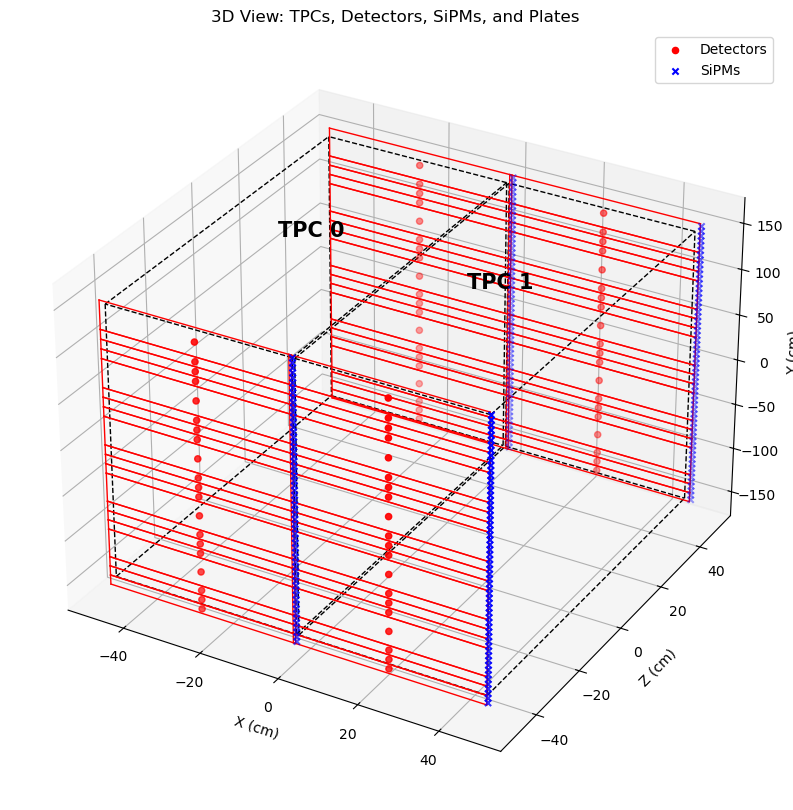

In [18]:
#This code cell defines the functions needed and then plots it for all detectors/sipms/TPCs, this looks very cluttered so another code cell plots it for a specified TPC
#TPC boundaries are within the actual data file so just pick an example data file and extract the stuff from this
def extract_tpc_bounds(file_obj):
    mod_bounds = np.array(file_obj['geometry_info'].attrs['module_RO_bounds']) 
    max_drift = file_obj['geometry_info'].attrs['max_drift_distance']
    tpc_bounds = []
    for mod in mod_bounds:
        x_min, y_min, z_min = mod[0]
        x_max, y_max, z_max = mod[1]
        #Two TPC boundaries per module:
        tpc_bounds.append(((x_max - max_drift, y_min, z_min), (x_max, y_max, z_max)))
        tpc_bounds.append(((x_min, y_min, z_min), (x_min + max_drift, y_max, z_max)))
    return np.array(tpc_bounds)


def flipYZ(coords):
#So standard ordering and plotting assumes X, Y, Z where Z is typically height, we want Y to be height so we sometimes need to flip the coords to make things look proper
    coords = np.array(coords)
    if coords.ndim == 1:
        #Flip a single point
        x, y, z = coords
        return np.array([x, z, y])
    else:
        #Flip an array
        return coords[:, [0,2,1]]

def draw_box(ax, bounds, **kwargs):
#Lets now draw the TPC boundary box 
    lower, upper = np.array(bounds[0]), np.array(bounds[1])
    x0, y0, z0 = lower  #(x_min, y_min, z_min)
    x1, y1, z1 = upper  #(x_max, y_max, z_max)

    #Need eight corners (probably a smarter way to do this)
    corners = np.array([
        [x0, y0, z0],  #Corner 0
        [x1, y0, z0],  #Corner 1
        [x1, y1, z0],  #Corner 2
        [x0, y1, z0],  #Corner 3
        [x0, y0, z1],  #Corner 4
        [x1, y0, z1],  #Corner 5
        [x1, y1, z1],  #Corner 6
        [x0, y1, z1]   #Corner 7
    ])

    edges = [
        (0,1), (1,2), (2,3), (3,0),  #bottom face
        (4,5), (5,6), (6,7), (7,4),  #top face
        (0,4), (1,5), (2,6), (3,7)   #vertical edges
    ]

    #Now flip the corners so that it matches the way were plotting the data in which the Y axis is the height
    corners = flipYZ(corners) 

    #Plot things
    for e in edges:
        p1, p2 = corners[e[0]], corners[e[1]]
        ax.plot(
            [p1[0], p2[0]],  #X
            [p1[1], p2[1]],  #Y in Matplotlib => real z
            [p1[2], p2[2]],  #Z in Matplotlib => real y
            **kwargs
        )

#We can load the detector center position and the SiPM position from the geometry 
#with open('/global/cfs/cdirs/dune/users/kunzmann/FSD/flow_james/ndlar_flow/data/proto_nd_flow/light_module_desc-5.0.1.yaml', 'r') as geom: #changed to 5.0.1, still works
 #   geom_data = yaml.safe_load(geom)

with open('/global/cfs/cdirs/dune/users/kunzmann/FSD/flow_james/ndlar_flow/data/fsd_flow/light_module_desc-6.0.1.yaml', 'r') as geom: #changed to 5.0.1, still works
    geom_data = yaml.safe_load(geom)

det_positions_list = []
for det_id in sorted(geom_data['det_center'].keys()):
    x, y, z = geom_data['det_center'][det_id]
    det_positions_list.append([x, y, z])
det_positions = np.array(det_positions_list)
print("det_positions shape:", det_positions.shape)

sipm_positions_list = []
for sipm_id in sorted(geom_data['sipm_center'].keys()):
    x, y, z = geom_data['sipm_center'][sipm_id]
    sipm_positions_list.append([x, y, z])
sipm_positions = np.array(sipm_positions_list)
print("sipm_positions shape:", sipm_positions.shape)

#Take an example hdf5 file to extract the tpc bounds from
sample_hdf5_file = "/global/cfs/cdirs/dune/www/data/FSD/reflows/v6/flow/cosmics/07Nov2024/packet-0020113-2024_11_07_19_44_23_CET.FLOW.hdf5"
with h5flow.data.H5FlowDataManager(sample_hdf5_file, "r") as file_obj:
    tpc_bounds = extract_tpc_bounds(file_obj)  

#Build TPC labels
num_modules = len(tpc_bounds) // 2
tpc_labels = []
for i in range(num_modules):
    tpc_labels.append(f"TPC {2*i+1}")
    tpc_labels.append(f"TPC {2*i}")

#andddd make the plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

#Draw each TPC box and label
for i, bounds in enumerate(tpc_bounds):
    draw_box(ax, bounds, color='black', linestyle='--', linewidth=1)

    (x0, y0, z0), (x1, y1, z1) = bounds
    center_x = 0.5*(x0 + x1)
    center_y = y1 + 5.0   #place label above the tpc boundaries so it doesnt look too ugly
    center_z = 0.5*(z0 + z1)
    cx, cy, cz = flipYZ([center_x, center_y, center_z])
    ax.text(cx, cy, cz, tpc_labels[i], color='black', fontsize=15, fontweight='bold', ha='center')

#Draw these detector and SiPM positions (make sure to do this YZ flip)
det_positions_all = np.vstack([det_positions + np.mean(b, axis=0) for b in tpc_bounds])
sipm_positions_all = np.vstack([sipm_positions + np.mean(b, axis=0) for b in tpc_bounds])

ax.scatter(*flipYZ(det_positions_all).T, color='red', marker='o', label='Detectors')
ax.scatter(*flipYZ(sipm_positions_all).T, color='blue', marker='x', label='SiPMs')

#Lets focus on drawing these detector plates
#Function which takes as input the corners and draws this rectangle
def draw_plate_outline(ax, corners, **kwargs):
    seq = [0,1,2,3,0]
    for i in range(4):
        p1, p2 = corners[seq[i]], corners[seq[i+1]]
        ax.plot(*zip(p1, p2), **kwargs)

#Function to extract the plate corners from the geom file
def get_plate_corners(det_id, tpc_shift, geom_dict):
    shape_key = 0 if (det_id % 4) == 3 else 1 #Didnt have a better plan, but we know ACLs are every modulo 4 
    offs_min  = np.array(geom_dict['geom'][shape_key]['min'], float)
    offs_max  = np.array(geom_dict['geom'][shape_key]['max'], float)

    xmin,ymin,_ = offs_min
    xmax,ymax,_ = offs_max
    local_rect  = np.array([[xmin,ymin,0],[xmax,ymin,0],
                            [xmax,ymax,0],[xmin,ymax,0]])

    det_ctr_local = np.array(geom_dict['det_center'][det_id], float)
    return local_rect + det_ctr_local + tpc_shift

for tpc_idx, tpc_bounds_i in enumerate(tpc_bounds):
    tpc_shift = np.mean(tpc_bounds_i, axis=0)
    for det_id in sorted(geom_data['det_center'].keys(), key=int):
        plate_corners = get_plate_corners(int(det_id), tpc_shift, geom_data)
        draw_plate_outline(ax, flipYZ(plate_corners), color='red', linewidth=1)

#Show full detector and label the axes correctly
ax.set_xlabel("X (cm)")
ax.set_ylabel("Z (cm)")
ax.set_zlabel("Y (cm)")
#ax.set_xlim(-80, 80)
#ax.set_ylim(-80, 80)
#ax.set_zlim(-80, 80)
ax.set_title("3D View: TPCs, Detectors, SiPMs, and Plates")
ax.legend()
plt.show()

det_positions_local = det_positions

In [17]:
#print(geom_data.keys())
#print(geom_data['det_adc'])
print(geom_data['det_chan'])
#print(geom_data['det_side'])

{0: {0: [61, 60], 1: [59, 58], 2: [57, 56], 3: [55, 54, 53, 52, 51, 50], 4: [49, 48], 5: [47, 46], 6: [45, 44], 7: [43, 42, 41, 40, 39, 38], 8: [37, 36], 9: [35, 34], 10: [33, 32], 11: [29, 28, 27, 26, 25, 24], 12: [23, 22], 13: [21, 20], 14: [19, 18], 15: [17, 16, 15, 14, 13, 12], 16: [11, 10], 17: [9, 8], 18: [7, 6], 19: [5, 4, 3, 2, 1, 0], 20: [0, 1], 21: [2, 3], 22: [4, 5], 23: [6, 7, 8, 9, 10, 11], 24: [12, 13], 25: [14, 15], 26: [16, 17], 27: [18, 19, 20, 21, 22, 23], 28: [24, 25], 29: [26, 27], 30: [28, 29], 31: [32, 33, 34, 35, 36, 37], 32: [38, 39], 33: [40, 41], 34: [42, 43], 35: [44, 45, 46, 47, 48, 49], 36: [50, 51], 37: [52, 53], 38: [54, 55], 39: [56, 57, 58, 59, 60, 61]}, 1: {0: [0, 1], 1: [2, 3], 2: [4, 5], 3: [6, 7, 8, 9, 10, 11], 4: [12, 13], 5: [14, 15], 6: [16, 17], 7: [18, 19, 20, 21, 22, 23], 8: [24, 25], 9: [26, 27], 10: [28, 29], 11: [32, 33, 34, 35, 36, 37], 12: [38, 39], 13: [40, 41], 14: [42, 43], 15: [44, 45, 46, 47, 48, 49], 16: [50, 51], 17: [52, 53], 18: 

In [18]:
f["charge"].keys()

<KeysViewHDF5 ['calib_prompt_hits', 'events', 'ext_trigs', 'packets', 'packets_corr_ts', 'raw_events', 'raw_hits']>

### 2.4 dbscan & ransac algorithms

In [19]:
# Assumes: file is open, geom_data is loaded, tpc_bounds are extracted
# dbscan function before linear fit
# det_positions_local = det_positions

def select_main_dbscan_cluster(x, y, z, dE, eps=2.0, min_samples=3):
    """
    Run DBSCAN on (x,y,z) and keep only the largest non-noise cluster.
    If clustering fails or everything is noise, return the original arrays.

    Parameters
    ----------
    x, y, z : 1D arrays
        Hit positions.
    dE : 1D array
        Energy deposit per hit (aligned with x,y,z).
    eps : float
        DBSCAN eps (distance scale, in same units as x,y,z, e.g. cm).
    min_samples : int
        Minimum number of points to form a cluster.

    Returns
    -------
    x_f, y_f, z_f, dE_f : 1D arrays
        Filtered arrays containing only the main cluster (or original if clustering fails).
    """
    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    dE = np.asarray(dE)

    # not enough points to cluster → just return
    if len(x) < min_samples:
        return x, y, z, dE

    coords = np.column_stack((x, y, z))

    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(coords)

    # labels == -1 are noise
    unique_labels, counts = np.unique(labels[labels != -1], return_counts=True)

    if len(unique_labels) == 0:
        # everything is noise → fall back to original hits
        print("DBSCAN: all hits classified as noise, using all hits.")
        return x, y, z, dE

    # pick the label of the largest cluster
    main_label = unique_labels[np.argmax(counts)]

    main_mask = (labels == main_label)

    x_f = x[main_mask]
    y_f = y[main_mask]
    z_f = z[main_mask]
    dE_f = dE[main_mask]

    print(f"DBSCAN: selected main cluster label {main_label} with {np.sum(main_mask)} hits "
          f"out of {len(x)} total hits.")

    return x_f, y_f, z_f, dE_f

#new process tpc with dbscan    
def process_tpc(tpc_idx, file, event, tpc_bounds, geom_data, ax=None):
    print(f"\nProcessing TPC {tpc_idx}")
    bounds = tpc_bounds[tpc_idx]
    lower, upper = np.array(bounds[0]), np.array(bounds[1])

    # --- Get muon hits ---
    my_muon_hits = file['charge/events', 'charge/calib_prompt_hits', event]

    x = my_muon_hits['x'].reshape(-1)
    y = my_muon_hits['y'].reshape(-1)
    z = my_muon_hits['z'].reshape(-1)
    dE = my_muon_hits['E'].reshape(-1)

    # restrict to this TPC volume
    mask = (
        (x >= lower[0]) & (x <= upper[0]) &
        (y >= lower[1]) & (y <= upper[1]) &
        (z >= lower[2]) & (z <= upper[2])
    )
    hits_x, hits_y, hits_z, hits_dE = x[mask], y[mask], z[mask], dE[mask]

    print(f"  Hits in TPC (before clustering): {len(hits_x)}")

    # --- NEW: apply DBSCAN clustering on hits within this TPC ---
    hits_x, hits_y, hits_z, hits_dE = select_main_dbscan_cluster(
        hits_x, hits_y, hits_z, hits_dE,
        eps=5.0,        # tune if needed
        min_samples=5   # tune if needed
    )

    print(f"  Hits in TPC (after clustering): {len(hits_x)}")

    if len(hits_x) < 2:
        print("  Not enough hits after DBSCAN to perform line fit; skipping this TPC.")
        return []

    #Select the TPC to visualize
    TARGET_TPC_INDEX = tpc_idx
    tpc_shift = np.mean(tpc_bounds[TARGET_TPC_INDEX], axis=0)

    det_rects = []
    #Draw detector plates (rectangles only numerically here)
    for det_id in range(det_positions_local.shape[0]):
        corners = get_plate_corners(det_id, tpc_shift, geom_data)
        cf = flipYZ(corners)
        det_rects.append((cf[0][0], cf[0][2], cf[2][0], cf[2][2]))

    (x0, y0, z0), (x1, y1, z1) = tpc_bounds[TARGET_TPC_INDEX]
    my_detector_z = [z0, z1]
    # I'm going to need a tolerance to find the 8 unique ones
    tolerance = 0.05
    unique_dets = []
    for det in det_rects:
        if not any(np.allclose(det, unique_det, atol=tolerance) for unique_det in unique_dets):
            unique_dets.append(det)

    # Now the line fit (inside compute_light_fraction_w_liner_fit) sees only the main cluster
    results = plot_light_on_detectors(hits_x, hits_y, hits_z, hits_dE, unique_dets, my_detector_z, ax=ax)

    return results


In [20]:
# v1 - Include dbscan and ransac, else fall back to original line fit
def process_tpc_from_line(tpc_idx,
                          x_mid, y_mid, z_mid, step_length,
                          tpc_bounds, geom_data):
    """
    Compute expected light for all detectors in a given TPC using the
    global straight track described by midpoints and segment lengths.

    Returns
    -------
    results : list of tuples
        (x0, y0, x1, y1, z_det, det, prod, frac)
    """
    print(f"\nProcessing TPC {tpc_idx} from global line")

    bounds = tpc_bounds[tpc_idx]
    lower, upper = np.array(bounds[0]), np.array(bounds[1])

    # keep only segments whose midpoints fall inside this TPC volume
    mask_tpc = (
        (x_mid >= lower[0]) & (x_mid <= upper[0]) &
        (y_mid >= lower[1]) & (y_mid <= upper[1]) &
        (z_mid >= lower[2]) & (z_mid <= upper[2])
    )

    if not np.any(mask_tpc):
        print("  No line segments inside this TPC; expected light = 0.")
        return []

    x_t = x_mid[mask_tpc]
    y_t = y_mid[mask_tpc]
    z_t = z_mid[mask_tpc]
    L_t = step_length[mask_tpc]

    # same plate geometry construction as in process_tpc
    TARGET_TPC_INDEX = tpc_idx
    tpc_shift = np.mean(tpc_bounds[TARGET_TPC_INDEX], axis=0)

    det_rects = []
    for det_id in range(det_positions_local.shape[0]):
        corners = get_plate_corners(det_id, tpc_shift, geom_data)
        cf = flipYZ(corners)
        det_rects.append((cf[0][0], cf[0][2], cf[2][0], cf[2][2]))

    (x0_b, y0_b, z0_b), (x1_b, y1_b, z1_b) = tpc_bounds[TARGET_TPC_INDEX]
    my_detector_z = [z0_b, z1_b]

    tolerance = 0.05
    unique_dets = []
    for det in det_rects:
        if not any(np.allclose(det, ud, atol=tolerance) for ud in unique_dets):
            unique_dets.append(det)

    results = []
    for z_det in my_detector_z:
        for (x0, y0, x1, y1) in unique_dets:
            det, prod, frac = compute_light_fraction_from_line_midpoints(
                x_t, y_t, z_t, L_t, x0, x1, y0, y1, z_det
            )
            results.append((x0, y0, x1, y1, z_det, det, prod, frac))

    return results

In [14]:
# v2- check new process, where the non-irradiated TPCs also get processed even if no hits are in them
def process_tpc_from_line(tpc_idx,
                          x_mid, y_mid, z_mid, step_length,
                          tpc_bounds, geom_data):
    """
    Compute expected light for all detectors in a given TPC using the
    global straight track described by midpoints and segment lengths.

    Returns
    -------
    results : list of tuples
        (x0, y0, x1, y1, z_det, det, prod, frac)
    """
    print(f"\nProcessing TPC {tpc_idx} from global line")

    bounds = tpc_bounds[tpc_idx]
    lower, upper = np.array(bounds[0]), np.array(bounds[1])

    # keep only segments whose midpoints fall inside this TPC volume
    mask_tpc = (
        (x_mid >= lower[0]) & (x_mid <= upper[0]) &
        (y_mid >= lower[1]) & (y_mid <= upper[1]) &
        (z_mid >= lower[2]) & (z_mid <= upper[2])
    )

    if not np.any(mask_tpc):
        print("  No line segments inside this TPC; expected light = 0.")
        # use empty arrays so compute_light_fraction_from_line_midpoints
        # returns (0, 0, 0) for every rectangle
        x_t = np.array([])
        y_t = np.array([])
        z_t = np.array([])
        L_t = np.array([])
    else:
        x_t = x_mid[mask_tpc]
        y_t = y_mid[mask_tpc]
        z_t = z_mid[mask_tpc]
        L_t = step_length[mask_tpc]

    TARGET_TPC_INDEX = tpc_idx
    tpc_shift = np.mean(tpc_bounds[TARGET_TPC_INDEX], axis=0)

    det_rects = []
    for det_id in range(det_positions_local.shape[0]):
        corners = get_plate_corners(det_id, tpc_shift, geom_data)
        cf = flipYZ(corners)
        det_rects.append((cf[0][0], cf[0][2], cf[2][0], cf[2][2]))

    (x0_b, y0_b, z0_b), (x1_b, y1_b, z1_b) = tpc_bounds[TARGET_TPC_INDEX]
    my_detector_z = [z0_b, z1_b]

    tolerance = 0.05
    unique_dets = []
    for det in det_rects:
        if not any(np.allclose(det, ud, atol=tolerance) for ud in unique_dets):
            unique_dets.append(det)

    results = []
    for z_det in my_detector_z:
        for (x0, y0, x1, y1) in unique_dets:
            det, prod, frac = compute_light_fraction_from_line_midpoints(
                x_t, y_t, z_t, L_t, x0, x1, y0, y1, z_det
            )
            results.append((x0, y0, x1, y1, z_det, det, prod, frac))

    return results


In [22]:
# v3.1 - keep |z|<49.99 cm, ineritly this is wrong since the borders of the FSD light traps are at approx 47.5cm
def process_tpc_from_line(tpc_idx,
                          x_mid, y_mid, z_mid, step_length,
                          tpc_bounds, geom_data):
    """
    Compute expected light for all detectors in a given TPC using the
    global straight track described by midpoints and segment lengths.

    Returns
    -------
    results : list of tuples
        (x0, y0, x1, y1, z_det, det, prod, frac)
    """
    print(f"\nProcessing TPC {tpc_idx} from global line")

    bounds = tpc_bounds[tpc_idx]
    lower, upper = np.array(bounds[0]), np.array(bounds[1])

    # geometry mask: segments inside this TPC volume
    mask_geom = (
        (x_mid >= lower[0]) & (x_mid <= upper[0]) &
        (y_mid >= lower[1]) & (y_mid <= upper[1]) &
        (z_mid >= lower[2]) & (z_mid <= upper[2])
    )

    # z-safety mask: avoid singularities near |z| ~ 50
    mask_zsafe = (z_mid > -49.99) & (z_mid < 49.99)

    # combined mask: in TPC AND in safe z-range
    mask_tpc = mask_geom & mask_zsafe

    if not np.any(mask_tpc):
        print("  No safe line segments inside this TPC; expected light = 0.")
        # empty arrays → compute_light_fraction_from_line_midpoints returns 0
        x_t = np.array([])
        y_t = np.array([])
        z_t = np.array([])
        L_t = np.array([])
    else:
        x_t = x_mid[mask_tpc]
        y_t = y_mid[mask_tpc]
        z_t = z_mid[mask_tpc]
        L_t = step_length[mask_tpc]

    TARGET_TPC_INDEX = tpc_idx
    tpc_shift = np.mean(tpc_bounds[TARGET_TPC_INDEX], axis=0)

    det_rects = []
    for det_id in range(det_positions_local.shape[0]):
        corners = get_plate_corners(det_id, tpc_shift, geom_data)
        cf = flipYZ(corners)
        det_rects.append((cf[0][0], cf[0][2], cf[2][0], cf[2][2]))

    (x0_b, y0_b, z0_b), (x1_b, y1_b, z1_b) = tpc_bounds[TARGET_TPC_INDEX]
    my_detector_z = [z0_b, z1_b]

    tolerance = 0.05
    unique_dets = []
    for det in det_rects:
        if not any(np.allclose(det, ud, atol=tolerance) for ud in unique_dets):
            unique_dets.append(det)

    results = []
    for z_det in my_detector_z:
        for (x0, y0, x1, y1) in unique_dets:
            det, prod, frac = compute_light_fraction_from_line_midpoints(
                x_t, y_t, z_t, L_t, x0, x1, y0, y1, z_det
            )
            results.append((x0, y0, x1, y1, z_det, det, prod, frac))

    return results


In [23]:
# v3.2 - keep |z|<47.5 cm, adapted to the correct surface distance
def process_tpc_from_line(tpc_idx,
                          x_mid, y_mid, z_mid, step_length,
                          tpc_bounds, geom_data):
    """
    Compute expected light for all detectors in a given TPC using the
    global straight track described by midpoints and segment lengths.

    Returns
    -------
    results : list of tuples
        (x0, y0, x1, y1, z_det, det, prod, frac)
    """
    print(f"\nProcessing TPC {tpc_idx} from global line")

    bounds = tpc_bounds[tpc_idx]
    lower, upper = np.array(bounds[0]), np.array(bounds[1])

    # geometry mask: segments inside this TPC volume
    mask_geom = (
        (x_mid >= lower[0]) & (x_mid <= upper[0]) &
        (y_mid >= lower[1]) & (y_mid <= upper[1]) &
        (z_mid >= lower[2]) & (z_mid <= upper[2])
    )

    # z-safety mask: avoid singularities near |z| ~ 50
    mask_zsafe = (z_mid > -47.5) & (z_mid < 47.5)

    # combined mask: in TPC AND in safe z-range
    mask_tpc = mask_geom & mask_zsafe

    if not np.any(mask_tpc):
        print("  No safe line segments inside this TPC; expected light = 0.")
        # empty arrays → compute_light_fraction_from_line_midpoints returns 0
        x_t = np.array([])
        y_t = np.array([])
        z_t = np.array([])
        L_t = np.array([])
    else:
        x_t = x_mid[mask_tpc]
        y_t = y_mid[mask_tpc]
        z_t = z_mid[mask_tpc]
        L_t = step_length[mask_tpc]

    TARGET_TPC_INDEX = tpc_idx
    tpc_shift = np.mean(tpc_bounds[TARGET_TPC_INDEX], axis=0)

    det_rects = []
    for det_id in range(det_positions_local.shape[0]):
        corners = get_plate_corners(det_id, tpc_shift, geom_data)
        cf = flipYZ(corners)
        det_rects.append((cf[0][0], cf[0][2], cf[2][0], cf[2][2]))

    (x0_b, y0_b, z0_b), (x1_b, y1_b, z1_b) = tpc_bounds[TARGET_TPC_INDEX]
    my_detector_z = [z0_b, z1_b]

    tolerance = 0.05
    unique_dets = []
    for det in det_rects:
        if not any(np.allclose(det, ud, atol=tolerance) for ud in unique_dets):
            unique_dets.append(det)

    results = []
    for z_det in my_detector_z:
        for (x0, y0, x1, y1) in unique_dets:
            det, prod, frac = compute_light_fraction_from_line_midpoints(
                x_t, y_t, z_t, L_t, x0, x1, y0, y1, z_det
            )
            results.append((x0, y0, x1, y1, z_det, det, prod, frac))

    return results


In [24]:
print(p_events)

[548, 1132, 1479, 1552, 2130, 2930, 3751, 3824, 3988, 4045, 4148, 4956, 5291, 5485, 5760, 5789, 5922, 6947, 7101, 7162, 7346, 7809, 8481, 8977, 9060, 9431, 9639, 9719, 9812, 10149, 10674, 11123, 11989, 12028, 12438, 12609, 13356, 13462, 13508, 14115, 14130, 14163, 14208, 14394, 14479, 15194, 15783, 16251, 16480, 16609, 16755, 16985, 17249, 17422, 17908, 18024, 18483, 19097, 19255, 19688, 19773, 20005, 20102, 20635, 21064, 21238, 21555, 21849, 22201, 22732, 22794, 22885, 23438, 23881, 23915, 24607, 24731, 24842, 24903, 25051, 25213, 25242, 25359, 25461, 25888, 25935, 26002, 26048, 26196, 26282, 26589, 26626, 27113, 27161, 27233, 27490, 28504, 28934, 29805, 29858, 29893, 30021, 30373, 31013, 31071, 31092, 31329, 31796, 32472, 32830, 32868, 33179, 33209, 33675, 33771, 34277, 34585, 34710, 34815, 34893, 35432, 35598, 36770, 36851, 37376, 37438, 37777, 38098, 38502, 38616, 38808, 39143, 39304, 39353, 39828, 39868, 40131, 40305, 40892, 40919, 41047, 41134, 41142, 41242, 41824, 42467, 42645, 

In [25]:
def ransac_line_3d(x, y, z,
                   distance_threshold=1.0,
                   min_inliers=10,
                   max_trials=1000,
                   random_state=None):
    """
    Robustly fit a 3D line (infinite) using a simple RANSAC scheme.

    Returns
    -------
    centroid : (3,) array
        Point on the best-fit line (center of inliers).
    direction : (3,) array
        Unit direction vector of the line.
    inlier_mask : (N,) bool array
        True for hits considered inliers of the final model.
    """
    rng = np.random.default_rng(random_state)
    pts = np.column_stack((x, y, z))
    N = pts.shape[0]

    if N < 2:
        raise ValueError("Not enough points for RANSAC line fit")

    best_inliers = None
    best_count = 0

    for _ in range(max_trials):
        # random pair of distinct points
        i1, i2 = rng.choice(N, size=2, replace=False)
        p0 = pts[i1]
        p1 = pts[i2]
        v = p1 - p0
        norm = np.linalg.norm(v)
        if norm == 0:
            continue
        v /= norm

        # distance of all points to this line
        diff = pts - p0
        proj = diff @ v
        closest = np.outer(proj, v)
        dist = np.linalg.norm(diff - closest, axis=1)

        inliers = dist < distance_threshold
        count = np.count_nonzero(inliers)

        if count > best_count:
            best_count = count
            best_inliers = inliers

            # early break if almost everything is an inlier
            if best_count >= max(min_inliers, 0.9 * N):
                break

    # if RANSAC failed badly, fall back to all points
    if best_inliers is None or best_count < max(2, min_inliers):
        best_inliers = np.ones(N, dtype=bool)

    inlier_pts = pts[best_inliers]
    centroid = inlier_pts.mean(axis=0)
    _, _, vt = np.linalg.svd(inlier_pts - centroid)
    direction = vt[0]
    direction /= np.linalg.norm(direction)

    return centroid, direction, best_inliers


def line_midpoints_from_model(centroid, direction, pts, seg_length):
    """
    Given a line model (centroid + direction) and a cloud of points,
    build equally spaced segment midpoints along the line
    that spans those points.

    Returns
    -------
    x_mid, y_mid, z_mid, step_len
    """
    diff = pts - centroid
    t = diff @ direction
    t_min, t_max = t.min(), t.max()

    t_edges = np.arange(t_min, t_max, seg_length)
    if t_edges[-1] < t_max:
        t_edges = np.append(t_edges, t_max)

    t_mid = 0.5 * (t_edges[:-1] + t_edges[1:])
    step_len = np.diff(t_edges)

    mid = centroid + np.outer(t_mid, direction)
    x_mid, y_mid, z_mid = mid[:, 0], mid[:, 1], mid[:, 2]

    return x_mid, y_mid, z_mid, step_len


## 3 Calling the functions and plotting

### 3.1 dbscan & ransac plots

In [26]:
print(p_events)

[548, 1132, 1479, 1552, 2130, 2930, 3751, 3824, 3988, 4045, 4148, 4956, 5291, 5485, 5760, 5789, 5922, 6947, 7101, 7162, 7346, 7809, 8481, 8977, 9060, 9431, 9639, 9719, 9812, 10149, 10674, 11123, 11989, 12028, 12438, 12609, 13356, 13462, 13508, 14115, 14130, 14163, 14208, 14394, 14479, 15194, 15783, 16251, 16480, 16609, 16755, 16985, 17249, 17422, 17908, 18024, 18483, 19097, 19255, 19688, 19773, 20005, 20102, 20635, 21064, 21238, 21555, 21849, 22201, 22732, 22794, 22885, 23438, 23881, 23915, 24607, 24731, 24842, 24903, 25051, 25213, 25242, 25359, 25461, 25888, 25935, 26002, 26048, 26196, 26282, 26589, 26626, 27113, 27161, 27233, 27490, 28504, 28934, 29805, 29858, 29893, 30021, 30373, 31013, 31071, 31092, 31329, 31796, 32472, 32830, 32868, 33179, 33209, 33675, 33771, 34277, 34585, 34710, 34815, 34893, 35432, 35598, 36770, 36851, 37376, 37438, 37777, 38098, 38502, 38616, 38808, 39143, 39304, 39353, 39828, 39868, 40131, 40305, 40892, 40919, 41047, 41134, 41142, 41242, 41824, 42467, 42645, 

In [27]:
event=500
event=44
event=1289
event = 9045
# problematic events: 7493, 69528
# very nice ones 97, 17359

# Create cluster filtered light signal and 

my_muon_hits = f['charge/events', 'charge/calib_prompt_hits', event]

x = my_muon_hits['x'].reshape(-1)
y = my_muon_hits['y'].reshape(-1)
z = my_muon_hits['z'].reshape(-1)

coords = np.column_stack((x, y, z))

# ---------------------------------
# Global DBSCAN: keep only largest cluster
# ---------------------------------
db = DBSCAN(eps=5.0, min_samples=3)
labels = db.fit_predict(coords)

mask_non_noise = labels != -1
if np.any(mask_non_noise):
    labels_nn = labels[mask_non_noise]
    uniq, counts = np.unique(labels_nn, return_counts=True)
    main_label = uniq[np.argmax(counts)]
    cluster_mask = labels == main_label
    print(f"Event {event}: main cluster label {{main_label}}, size {{np.sum(cluster_mask)}}")
else:
    cluster_mask = np.zeros_like(labels, dtype=bool)
    print(f"Event {event}: no non-noise clusters, falling back to all hits.")

# ---------------------------------
# RANSAC line on the main cluster
# ---------------------------------
if np.sum(cluster_mask) >= 2:
    x_c = x[cluster_mask]
    y_c = y[cluster_mask]
    z_c = z[cluster_mask]

    centroid, direction, inliers_r = ransac_line_3d(
        x_c, y_c, z_c,
        distance_threshold=1.0,
        min_inliers=5,
        max_trials=500,
        random_state=42
    )

    pts_c = np.column_stack((x_c, y_c, z_c))
    seg_length = 0.1  # cm
    x_mid, y_mid, z_mid, step_length = line_midpoints_from_model(
        centroid, direction, pts_c, seg_length
    )

    # After calling line_midpoints_from_model(...)
    num_midpoints = len(x_mid)
    track_length = np.sum(step_length)

    print("----- RANSAC Track Summary -----")
    print(f"Segment length (cm):         {seg_length}")
    print(f"Total track length (cm):     {track_length:.2f}")
    print(f"Number of midpoints:         {num_midpoints}")
    print(f"Approx expected midpoints:   {track_length / seg_length:.2f}")
    print("---------------------------------")


    print(f"Event {event}: RANSAC inliers {{np.sum(inliers_r)}} / {{len(x_c)}} in cluster")
else:
    print(f"Event {event}: not enough clustered hits for RANSAC; using PCA line fit.")
    seg_length = 0.1
    x_mid, y_mid, z_mid, step_length = line_fit_3d_segment_midpoints(x, y, z, seg_length)

# ---------------------------------
# Use the global line to compute light TPC-by-TPC
# ---------------------------------
all_results = []

for tpc_idx in range(len(tpc_bounds)):
    results = process_tpc_from_line(
        tpc_idx,
        x_mid, y_mid, z_mid, step_length,
        tpc_bounds, geom_data
    )
    all_results.extend(results)

Event 9045: main cluster label {main_label}, size {np.sum(cluster_mask)}
----- RANSAC Track Summary -----
Segment length (cm):         0.1
Total track length (cm):     73.52
Number of midpoints:         736
Approx expected midpoints:   735.17
---------------------------------
Event 9045: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster

Processing TPC 0 from global line

Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.


/tmp/ipykernel_515651/3747413649.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("inferno")


DBSCAN: main cluster label 0, size 177
Total hits: 179
Main-cluster hits: 177
Noise/other hits: 2
RANSAC inliers: 162 out of 177 in cluster


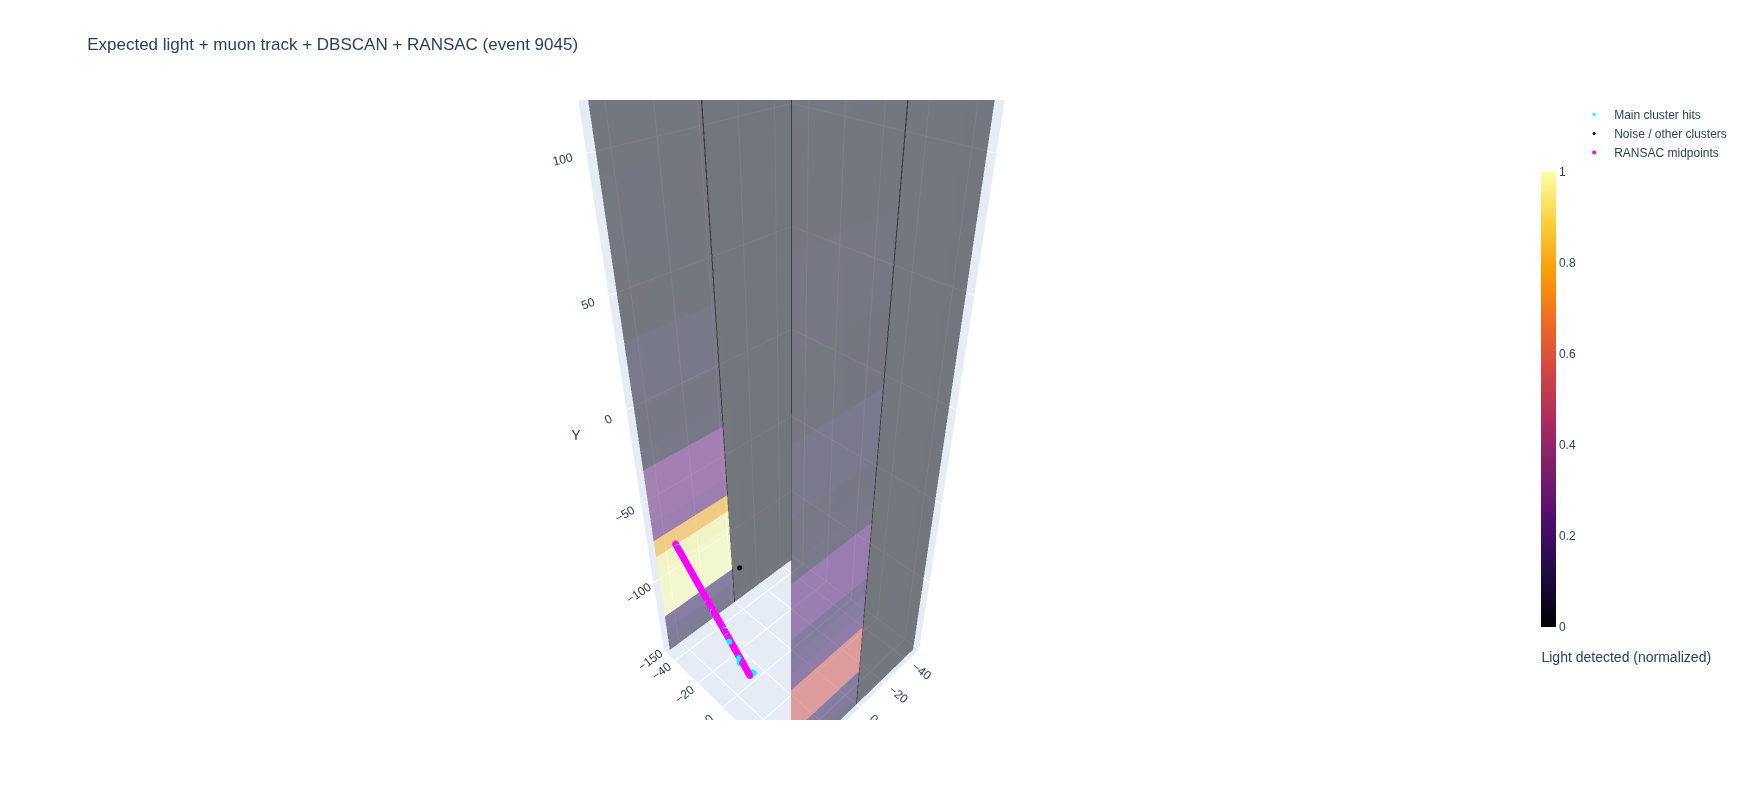

In [28]:
# ------------------------------------------
# 1) Compute detector colors from all_results
# ------------------------------------------
detected_all = np.array([r[5] for r in all_results])
produced_all = np.array([r[6] for r in all_results])

total_produced = np.sum(produced_all)
colors_norm = detected_all / total_produced

# Normalize to [0, 1]
colors_norm = (colors_norm - np.min(colors_norm)) / (np.max(colors_norm) - np.min(colors_norm))

cmap = cm.get_cmap("inferno")

xs_det, ys_det, zs_det = [], [], []
i_idx, j_idx, k_idx = [], [], []
intensity = []

for idx, (result, cnorm) in enumerate(zip(all_results, colors_norm)):
    x0, y0, x1, y1, z_det, *_ = result

    base = len(xs_det)

    # Same coordinate convention as before: (X, Z, Y) -> (x, y, z) for Plotly
    xs_det.extend([x0, x1, x1, x0])
    ys_det.extend([z_det, z_det, z_det, z_det])
    zs_det.extend([y0, y0, y1, y1])

    i_idx.extend([base, base])
    j_idx.extend([base + 1, base + 2])
    k_idx.extend([base + 2, base + 3])

    intensity.extend([cnorm] * 4)

mesh_det = go.Mesh3d(
    x=xs_det,
    y=ys_det,
    z=zs_det,
    i=i_idx,
    j=j_idx,
    k=k_idx,
    intensity=intensity,
    colorscale='Inferno',
    showscale=True,

    colorbar=dict(
        title=dict(
            text='Light detected (normalized)',
            side='bottom'   # ← put the title under the vertical colorbar
        ),
        thickness=15,
        len=0.8,
    ),

    opacity=0.5,
    name='Light traps'
)


# ------------------------------------------
# 2) Global muon hits for this event
# ------------------------------------------
my_muon_hits = f['charge/events', 'charge/calib_prompt_hits', event]

x = my_muon_hits['x'].reshape(-1)
y = my_muon_hits['y'].reshape(-1)
z = my_muon_hits['z'].reshape(-1)

coords = np.column_stack((x, y, z))

# ------------------------------------------
# 3) DBSCAN: keep ONLY the largest non-noise cluster
# ------------------------------------------
db = DBSCAN(eps=5.0, min_samples=3)
labels = db.fit_predict(coords)

mask_non_noise = labels != -1

if np.any(mask_non_noise):
    labels_nn = labels[mask_non_noise]
    uniq, counts = np.unique(labels_nn, return_counts=True)
    main_label = uniq[np.argmax(counts)]
    cluster_mask = labels == main_label
    print(f"DBSCAN: main cluster label {main_label}, size {np.sum(cluster_mask)}")
else:
    cluster_mask = np.zeros_like(labels, dtype=bool)
    print("DBSCAN: no non-noise clusters, everything is noise.")

noise_mask = ~cluster_mask

print(f"Total hits: {len(x)}")
print(f"Main-cluster hits: {np.sum(cluster_mask)}")
print(f"Noise/other hits: {np.sum(noise_mask)}")

# ------------------------------------------
# 4) RANSAC line fit
# ------------------------------------------
if np.sum(cluster_mask) >= 2:
    x_c = x[cluster_mask]
    y_c = y[cluster_mask]
    z_c = z[cluster_mask]

    centroid, direction, inliers_r = ransac_line_3d(
        x_c, y_c, z_c,
        distance_threshold=1.0,
        min_inliers=5,
        max_trials=500,
        random_state=42
    )

    print(f"RANSAC inliers: {np.sum(inliers_r)} out of {len(x_c)} in cluster")

    pts_c = np.column_stack((x_c, y_c, z_c))
    seg_length = 0.1  # cm
    x_mid, y_mid, z_mid, step_len = line_midpoints_from_model(
        centroid, direction, pts_c, seg_length
    )
else:
    print("Not enough clustered hits for RANSAC; falling back to SVD.")
    seg_length = 0.1
    x_mid, y_mid, z_mid, step_len = line_fit_3d_segment_midpoints(x, y, z, seg_length)

# ------------------------------------------
# 5) Plotly traces
# ------------------------------------------

# Clustered hits
hits_cluster = go.Scatter3d(
    x=x[cluster_mask],
    y=z[cluster_mask],
    z=y[cluster_mask],
    mode='markers',
    marker=dict(size=3, color='cyan'),
    name='Main cluster hits'
)

# Noise
hits_noise = go.Scatter3d(
    x=x[noise_mask],
    y=z[noise_mask],
    z=y[noise_mask],
    mode='markers',
    marker=dict(size=3, color='black'),
    name='Noise / other clusters'
)

# RANSAC segment midpoints
fit_midpoints = go.Scatter3d(
    x=x_mid,
    y=z_mid,
    z=y_mid,
    mode='markers',
    marker=dict(size=4, color='magenta'),
    name='RANSAC midpoints'
)

fig = go.Figure(data=[mesh_det, hits_cluster, hits_noise, fit_midpoints])

# ------------------------------------------
# Layout (legend moved to the right!)
# ------------------------------------------
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Z',
        zaxis_title='Y',
        xaxis=dict(range=[-50, 50]),
        yaxis=dict(range=[-50, 50]),
        zaxis=dict(range=[-150, 150]),
    ),
    title=f'Expected light + muon track + DBSCAN + RANSAC (event {event})',
    width=900,
    height=800,

    legend=dict(
        x=1.05,  # move legend outside the right boundary
        y=1.0,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.6)'
    )
)

fig.show()


### 3.2 old linear fit and light generation

In [19]:
all_results = []

for tpc_idx in range(len(tpc_bounds)):
    results = process_tpc(tpc_idx, f, event, tpc_bounds, geom_data, ax=None)
    all_results.extend(results)  # Flatten everything into one big list

# Compute total detected and produced light across all detectors
detected_all = np.array([r[5] for r in all_results])
produced_all = np.array([r[6] for r in all_results])

# ------------------------------------------
# 1) Compute detector colors from all_results (same as before)
# ------------------------------------------
detected_all = np.array([r[5] for r in all_results])
produced_all = np.array([r[6] for r in all_results])

total_produced = np.sum(produced_all)
colors_norm = detected_all / total_produced

# Normalize to [0, 1]  (same formula as in Matplotlib code)
colors_norm = (colors_norm - np.min(colors_norm)) / (np.max(colors_norm) - np.min(colors_norm))

cmap = cm.get_cmap("inferno")

xs_det, ys_det, zs_det = [], [], []
i_idx, j_idx, k_idx = [], [], []
intensity = []

for idx, (result, cnorm) in enumerate(zip(all_results, colors_norm)):
    x0, y0, x1, y1, z_det, *_ = result

    base = len(xs_det)

    # Same coordinate convention as in Matplotlib: (X, Z, Y)
    xs_det.extend([x0, x1, x1, x0])
    ys_det.extend([z_det, z_det, z_det, z_det])
    zs_det.extend([y0, y0, y1, y1])

    i_idx.extend([base, base])
    j_idx.extend([base + 1, base + 2])
    k_idx.extend([base + 2, base + 3])

    intensity.extend([cnorm] * 4)

mesh_det = go.Mesh3d(
    x=xs_det,
    y=ys_det,
    z=zs_det,
    i=i_idx,
    j=j_idx,
    k=k_idx,
    intensity=intensity,
    colorscale='Inferno',
    showscale=True,

    colorbar=dict(
        title=dict(
            text='Light detected (globally normalized)',
            side='bottom'   # put the title under the vertical colorbar
        ),
        thickness=15,
        len=0.8,
    ),

    opacity=0.5,
    name='Light traps'
)

# ------------------------------------------
# 2) Muon track hits (same as Matplotlib)
# ------------------------------------------
my_muon_hits = f['charge/events', 'charge/calib_prompt_hits', event]

x = my_muon_hits['x'].reshape(-1)
y = my_muon_hits['y'].reshape(-1)
z = my_muon_hits['z'].reshape(-1)

# Scatter of all muon hits (blue), same axis mapping X, Z, Y
hits_track = go.Scatter3d(
    x=x,
    y=z,
    z=y,
    mode='markers',
    marker=dict(size=2, color='blue'),
    name='Muon track'
)

# ------------------------------------------
# 3) Fit midpoints from line_fit_3d_segment_midpoints (same content)
# ------------------------------------------
seg_length = 0.1  # cm, as in your Matplotlib code

x_mid, y_mid, z_mid, step_len = line_fit_3d_segment_midpoints(x, y, z, seg_length)

fit_midpoints = go.Scatter3d(
    x=x_mid,
    y=z_mid,
    z=y_mid,
    mode='markers',
    marker=dict(size=4, color='cyan'),
    name='Fit midpoints'
)

# ------------------------------------------
# 4) Build figure
# ------------------------------------------
fig = go.Figure(data=[mesh_det, hits_track, fit_midpoints])

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Z',
        zaxis_title='Y',
        xaxis=dict(range=[-50, 50]),
        yaxis=dict(range=[-50, 50]),
        zaxis=dict(range=[-150, 150]),
    ),
    title=f'Expected light on all light traps based on muon track, event number {event}',
    width=900,
    height=800,

    legend=dict(
        x=1.05,  # move legend outside the right boundary
        y=1.0,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.6)'
    )
)

fig.show()



Processing TPC 0
  Hits in TPC (before clustering): 179
DBSCAN: selected main cluster label 0 with 177 hits out of 179 total hits.
  Hits in TPC (after clustering): 177



Processing TPC 1
  Hits in TPC (before clustering): 0
  Hits in TPC (after clustering): 0
  Not enough hits after DBSCAN to perform line fit; skipping this TPC.


/tmp/ipykernel_1520972/1544814593.py:23: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.




Processing TPC 0
  Hits in TPC (before clustering): 211
DBSCAN: selected main cluster label 0 with 210 hits out of 211 total hits.
  Hits in TPC (after clustering): 210



Processing TPC 1
  Hits in TPC (before clustering): 2
  Hits in TPC (after clustering): 2


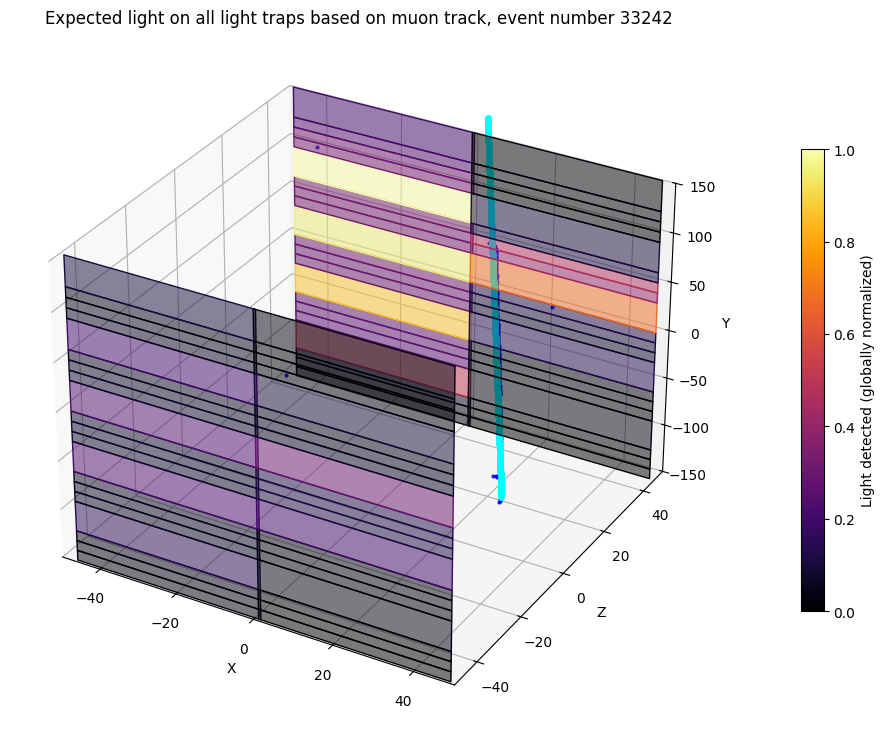

In [ ]:
##add the linear fit middle points

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

all_results = []

for tpc_idx in range(len(tpc_bounds)):
    results = process_tpc(tpc_idx, f, event, tpc_bounds, geom_data, ax=None)
    all_results.extend(results)  # Flatten everything into one big list

# Compute total detected and produced light across all detectors
detected_all = np.array([r[5] for r in all_results])
produced_all = np.array([r[6] for r in all_results])

total_produced = np.sum(produced_all)
colors_norm = detected_all / total_produced

# Normalize to [0, 1]
colors_norm = (colors_norm - np.min(colors_norm)) / (np.max(colors_norm) - np.min(colors_norm))

# Colormap
cmap = plt.cm.inferno
colors = cmap(colors_norm)

# Plot detectors with global-normalized color
for result, color in zip(all_results, colors):
    x0, y0, x1, y1, z_det, *_ = result
    corners = [
        [x0, z_det, y0],
        [x1, z_det, y0],
        [x1, z_det, y1],
        [x0, z_det, y1]
    ]
    rect = Poly3DCollection([corners], color=color, alpha=0.5)
    ax.add_collection3d(rect)

# Plot muon track
my_muon_hits = f['charge/events', 'charge/calib_prompt_hits', event] #anpassen file für 

#all of the following is the same as above muon_hits:
#hits_dset = 'calib_prompt_hits'
#hits_full = f['charge/'+hits_dset+'/data']
#hits_ref = f['charge/events/ref/charge/'+hits_dset+'/ref']
#hits_region = f['charge/events/ref/charge/'+hits_dset+'/ref_region']
#hit_ref = hits_ref[hits_region[event,'start']:hits_region[event,'stop']]
#hit_ref = np.sort(hit_ref[hit_ref[:,0] == event, 1])
#my_muon_hits = hits_full[hit_ref]

x = my_muon_hits['x'].reshape(-1)
y = my_muon_hits['y'].reshape(-1)
z = my_muon_hits['z'].reshape(-1)
ax.plot(x, z, y, color='b', marker='o', markersize=2, ls='none', alpha=0.8, label='Muon track')



# --------------------------------------------------
# Compute segment midpoints from your fit function
# --------------------------------------------------
seg_length = 0.1 #cm   # choose whatever step length you want

x_mid, y_mid, z_mid, step_len = line_fit_3d_segment_midpoints(x, y, z, seg_length)

# Plot the segment midpoints (same axis order X, Z, Y)
ax.plot(x_mid, z_mid, y_mid,
        marker='o',
        ls='none',
        markersize=4,
        color='cyan',
        label='Fit midpoints')


# Colorbar
sm = ScalarMappable(cmap=cmap)
sm.set_array(colors_norm)
cbar = plt.colorbar(sm, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label('Light detected (globally normalized)')

# Axis labels and limits
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
ax.set_zlim(-150, 150)
ax.set_title('Expected light on all light traps based on muon track, event number '+str(event))
plt.show()


### 3.3 Test crossing leaving out

In [29]:
# v4 - leave traps where tracks cross
def process_tpc_from_line_LTcrossing(tpc_idx,
                          x_mid, y_mid, z_mid, step_length,
                          tpc_bounds, geom_data,
                          z_safe=47.5,
                          z_cross_tol=0.5):
    """
    Compute expected light for all detectors in a given TPC using the
    global straight track described by midpoints and segment lengths.

    Additional behavior:
      - Only uses segments with |z| < z_safe (to avoid solid-angle singularity).
      - For any light trap that the track crosses (i.e. a midpoint lies inside
        the trap's x/y footprint and within z_cross_tol of z_det), the expected
        light is set to NaN so that it can be excluded in later PDE analysis.

    Returns
    -------
    results : list of tuples
        (x0, y0, x1, y1, z_det, det, prod, frac)
        where det, prod, frac may be NaN for traps traversed by the track.
    """
    print(f"\nProcessing TPC {tpc_idx} from global line")

    bounds = tpc_bounds[tpc_idx]
    lower, upper = np.array(bounds[0]), np.array(bounds[1])

    # Geometry mask: segments inside this TPC volume
    mask_geom = (
        (x_mid >= lower[0]) & (x_mid <= upper[0]) &
        (y_mid >= lower[1]) & (y_mid <= upper[1]) &
        (z_mid >= lower[2]) & (z_mid <= upper[2])
    )

    # z-safety mask: avoid singularities near |z| ~ detector planes
    mask_zsafe = (z_mid > -z_safe) & (z_mid < z_safe)

    # Combined mask: in this TPC AND in safe z range
    mask_tpc = mask_geom & mask_zsafe

    if not np.any(mask_tpc):
        print("  No safe line segments inside this TPC; expected light = 0.")
        # empty arrays → compute_light_fraction_from_line_midpoints returns 0
        x_t = np.array([])
        y_t = np.array([])
        z_t = np.array([])
        L_t = np.array([])
    else:
        x_t = x_mid[mask_tpc]
        y_t = y_mid[mask_tpc]
        z_t = z_mid[mask_tpc]
        L_t = step_length[mask_tpc]

    TARGET_TPC_INDEX = tpc_idx
    tpc_shift = np.mean(tpc_bounds[TARGET_TPC_INDEX], axis=0)

    # Build detector rectangles in this TPC
    det_rects = []
    for det_id in range(det_positions_local.shape[0]):
        corners = get_plate_corners(det_id, tpc_shift, geom_data)  # (x,y,z)
        cf = flipYZ(corners)  # -> (x,z,y)
        det_rects.append((cf[0][0], cf[0][2], cf[2][0], cf[2][2]))  # (x0,y0,x1,y1)

    (x0_b, y0_b, z0_b), (x1_b, y1_b, z1_b) = tpc_bounds[TARGET_TPC_INDEX]
    my_detector_z = [z0_b, z1_b]

    # Remove duplicates (within tolerance)
    tolerance = 0.05
    unique_dets = []
    for det in det_rects:
        if not any(np.allclose(det, ud, atol=tolerance) for ud in unique_dets):
            unique_dets.append(det)

    results = []

    # For each detector plane and rectangle, compute expected light
    for z_det in my_detector_z:
        for (x0, y0, x1, y1) in unique_dets:

            # --- NEW: check if the track crosses this light trap ---
            # A crossing is approximated by having at least one
            # segment midpoint inside the x/y footprint and close to z_det.
            crosses_mask = (
                (x_t >= x0) & (x_t <= x1) &
                (y_t >= y0) & (y_t <= y1) &
                (np.abs(z_t - z_det) <= z_cross_tol)
            )

            if np.any(crosses_mask):
                # Mark this trap as "contaminated" by Cherenkov: ignore in PDE
                det = np.nan
                prod = np.nan
                frac = np.nan
                # Optional debug:
                # print(f"  TPC {tpc_idx}: trap ({x0},{y0})-({x1},{y1}) at z={z_det} crossed by track, skipping.")
            else:
                # Normal scintillation expectation
                det, prod, frac = compute_light_fraction_from_line_midpoints(
                    x_t, y_t, z_t, L_t, x0, x1, y0, y1, z_det
                )

            results.append((x0, y0, x1, y1, z_det, det, prod, frac))

    return results


In [30]:
print(p_events)

[548, 1132, 1479, 1552, 2130, 2930, 3751, 3824, 3988, 4045, 4148, 4956, 5291, 5485, 5760, 5789, 5922, 6947, 7101, 7162, 7346, 7809, 8481, 8977, 9060, 9431, 9639, 9719, 9812, 10149, 10674, 11123, 11989, 12028, 12438, 12609, 13356, 13462, 13508, 14115, 14130, 14163, 14208, 14394, 14479, 15194, 15783, 16251, 16480, 16609, 16755, 16985, 17249, 17422, 17908, 18024, 18483, 19097, 19255, 19688, 19773, 20005, 20102, 20635, 21064, 21238, 21555, 21849, 22201, 22732, 22794, 22885, 23438, 23881, 23915, 24607, 24731, 24842, 24903, 25051, 25213, 25242, 25359, 25461, 25888, 25935, 26002, 26048, 26196, 26282, 26589, 26626, 27113, 27161, 27233, 27490, 28504, 28934, 29805, 29858, 29893, 30021, 30373, 31013, 31071, 31092, 31329, 31796, 32472, 32830, 32868, 33179, 33209, 33675, 33771, 34277, 34585, 34710, 34815, 34893, 35432, 35598, 36770, 36851, 37376, 37438, 37777, 38098, 38502, 38616, 38808, 39143, 39304, 39353, 39828, 39868, 40131, 40305, 40892, 40919, 41047, 41134, 41142, 41242, 41824, 42467, 42645, 

Event 9045: main cluster label {main_label}, size {np.sum(cluster_mask)}
Event 9045: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster

Processing TPC 0 from global line

Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.
DBSCAN: main cluster label 0, size 177
Total hits: 179
Main-cluster hits: 177
Noise/other hits: 2
RANSAC inliers: 162 out of 177 in cluster


/tmp/ipykernel_515651/2988562552.py:118: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



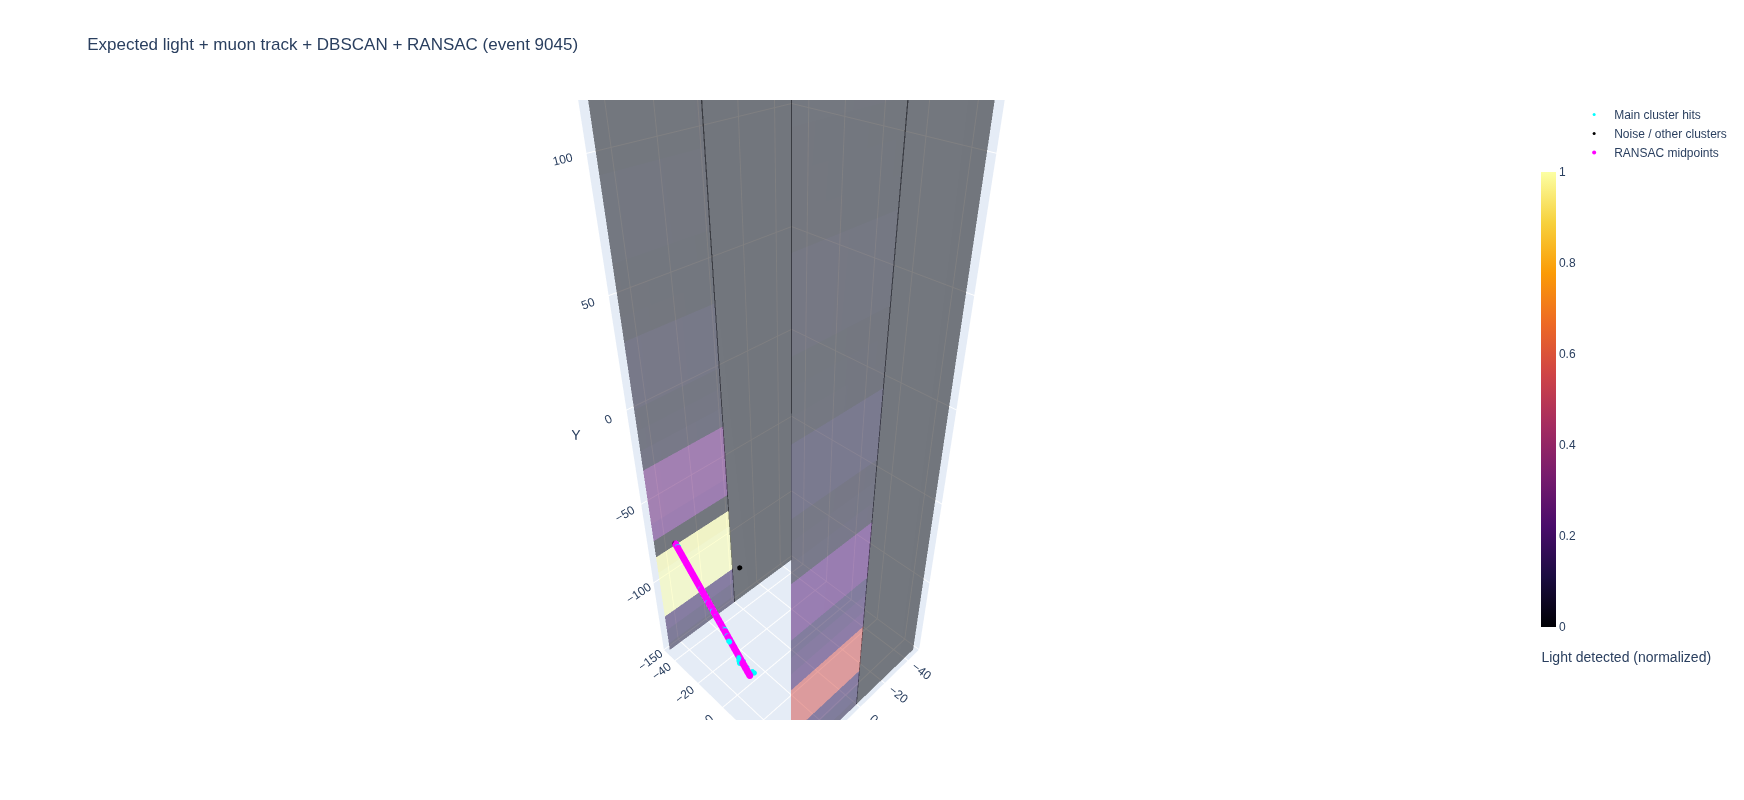

In [31]:
# v4 plots: change 

event=500
event=44
event=1289
event = 9045
# problematic events: 7493, 69528
# very nice ones 97, 17359

# Create cluster filtered light signal and 

my_muon_hits = f['charge/events', 'charge/calib_prompt_hits', event]

x = my_muon_hits['x'].reshape(-1)
y = my_muon_hits['y'].reshape(-1)
z = my_muon_hits['z'].reshape(-1)

coords = np.column_stack((x, y, z))

# ---------------------------------
# Global DBSCAN: keep only largest cluster
# ---------------------------------
db = DBSCAN(eps=5.0, min_samples=3)
labels = db.fit_predict(coords)

mask_non_noise = labels != -1
if np.any(mask_non_noise):
    labels_nn = labels[mask_non_noise]
    uniq, counts = np.unique(labels_nn, return_counts=True)
    main_label = uniq[np.argmax(counts)]
    cluster_mask = labels == main_label
    print(f"Event {event}: main cluster label {{main_label}}, size {{np.sum(cluster_mask)}}")
else:
    cluster_mask = np.zeros_like(labels, dtype=bool)
    print(f"Event {event}: no non-noise clusters, falling back to all hits.")

# ---------------------------------
# RANSAC line on the main cluster
# ---------------------------------
if np.sum(cluster_mask) >= 2:
    x_c = x[cluster_mask]
    y_c = y[cluster_mask]
    z_c = z[cluster_mask]

    centroid, direction, inliers_r = ransac_line_3d(
        x_c, y_c, z_c,
        distance_threshold=1.0,
        min_inliers=5,
        max_trials=500,
        random_state=42
    )

    pts_c = np.column_stack((x_c, y_c, z_c))
    seg_length = 0.1  # cm
    x_mid, y_mid, z_mid, step_length = line_midpoints_from_model(
        centroid, direction, pts_c, seg_length
    )

    # After calling line_midpoints_from_model(...)
    num_midpoints = len(x_mid)
    track_length = np.sum(step_length)

    # print("----- RANSAC Track Summary -----")
    # print(f"Segment length (cm):         {seg_length}")
    # print(f"Total track length (cm):     {track_length:.2f}")
    # print(f"Number of midpoints:         {num_midpoints}")
    # print(f"Approx expected midpoints:   {track_length / seg_length:.2f}")
    # print("---------------------------------")


    print(f"Event {event}: RANSAC inliers {{np.sum(inliers_r)}} / {{len(x_c)}} in cluster")
else:
    print(f"Event {event}: not enough clustered hits for RANSAC; using PCA line fit.")
    seg_length = 0.1
    x_mid, y_mid, z_mid, step_length = line_fit_3d_segment_midpoints(x, y, z, seg_length)

# ---------------------------------
# Use the global line to compute light TPC-by-TPC
# ---------------------------------
all_results = []

for tpc_idx in range(len(tpc_bounds)):
    results = process_tpc_from_line_LTcrossing(
        tpc_idx,
        x_mid, y_mid, z_mid, step_length,
        tpc_bounds, geom_data
    )
    all_results.extend(results)

# ------------------------------------------
# 1) Compute detector colors from all_results
# ------------------------------------------
detected_all = np.array([r[5] for r in all_results])
produced_all = np.array([r[6] for r in all_results])

# For plotting, treat NaNs as 0 expected light
det_safe = np.nan_to_num(detected_all, nan=0.0, posinf=0.0, neginf=0.0)
prod_safe = np.nan_to_num(produced_all, nan=0.0, posinf=0.0, neginf=0.0)

total_produced = np.sum(prod_safe)
if total_produced <= 0:
    colors_raw = np.zeros_like(det_safe)
else:
    colors_raw = det_safe / total_produced

# Normalize to [0, 1], ignoring any non-finite values just in case
finite_mask = np.isfinite(colors_raw)
if np.any(finite_mask):
    cmin = np.min(colors_raw[finite_mask])
    cmax = np.max(colors_raw[finite_mask])
    if cmax == cmin:
        colors_norm = np.zeros_like(colors_raw)
    else:
        colors_norm = (colors_raw - cmin) / (cmax - cmin)
else:
    colors_norm = np.zeros_like(colors_raw)

cmap = cm.get_cmap("inferno")

xs_det, ys_det, zs_det = [], [], []
i_idx, j_idx, k_idx = [], [], []
intensity = []

for idx, (result, cnorm) in enumerate(zip(all_results, colors_norm)):
    x0, y0, x1, y1, z_det, *_ = result

    base = len(xs_det)

    # Same coordinate convention as before: (X, Z, Y) -> (x, y, z) for Plotly
    xs_det.extend([x0, x1, x1, x0])
    ys_det.extend([z_det, z_det, z_det, z_det])
    zs_det.extend([y0, y0, y1, y1])

    i_idx.extend([base, base])
    j_idx.extend([base + 1, base + 2])
    k_idx.extend([base + 2, base + 3])

    intensity.extend([cnorm] * 4)

mesh_det = go.Mesh3d(
    x=xs_det,
    y=ys_det,
    z=zs_det,
    i=i_idx,
    j=j_idx,
    k=k_idx,
    intensity=intensity,
    colorscale='Inferno',
    showscale=True,
    colorbar=dict(
        title=dict(
            text='Light detected (normalized)',
            side='bottom'
        ),
        thickness=15,
        len=0.8,
    ),
    opacity=0.5,
    name='Light traps'
)


# ------------------------------------------
# 2) Global muon hits for this event
# ------------------------------------------
my_muon_hits = f['charge/events', 'charge/calib_prompt_hits', event]

x = my_muon_hits['x'].reshape(-1)
y = my_muon_hits['y'].reshape(-1)
z = my_muon_hits['z'].reshape(-1)

coords = np.column_stack((x, y, z))

# ------------------------------------------
# 3) DBSCAN: keep ONLY the largest non-noise cluster
# ------------------------------------------
db = DBSCAN(eps=5.0, min_samples=3)
labels = db.fit_predict(coords)

mask_non_noise = labels != -1

if np.any(mask_non_noise):
    labels_nn = labels[mask_non_noise]
    uniq, counts = np.unique(labels_nn, return_counts=True)
    main_label = uniq[np.argmax(counts)]
    cluster_mask = labels == main_label
    print(f"DBSCAN: main cluster label {main_label}, size {np.sum(cluster_mask)}")
else:
    cluster_mask = np.zeros_like(labels, dtype=bool)
    print("DBSCAN: no non-noise clusters, everything is noise.")

noise_mask = ~cluster_mask

print(f"Total hits: {len(x)}")
print(f"Main-cluster hits: {np.sum(cluster_mask)}")
print(f"Noise/other hits: {np.sum(noise_mask)}")

# ------------------------------------------
# 4) RANSAC line fit
# ------------------------------------------
if np.sum(cluster_mask) >= 2:
    x_c = x[cluster_mask]
    y_c = y[cluster_mask]
    z_c = z[cluster_mask]

    centroid, direction, inliers_r = ransac_line_3d(
        x_c, y_c, z_c,
        distance_threshold=1.0,
        min_inliers=5,
        max_trials=500,
        random_state=42
    )

    print(f"RANSAC inliers: {np.sum(inliers_r)} out of {len(x_c)} in cluster")

    pts_c = np.column_stack((x_c, y_c, z_c))
    seg_length = 0.1  # cm
    x_mid, y_mid, z_mid, step_len = line_midpoints_from_model(
        centroid, direction, pts_c, seg_length
    )
else:
    print("Not enough clustered hits for RANSAC; falling back to SVD.")
    seg_length = 0.1
    x_mid, y_mid, z_mid, step_len = line_fit_3d_segment_midpoints(x, y, z, seg_length)

# ------------------------------------------
# 5) Plotly traces
# ------------------------------------------

# Clustered hits
hits_cluster = go.Scatter3d(
    x=x[cluster_mask],
    y=z[cluster_mask],
    z=y[cluster_mask],
    mode='markers',
    marker=dict(size=3, color='cyan'),
    name='Main cluster hits'
)

# Noise
hits_noise = go.Scatter3d(
    x=x[noise_mask],
    y=z[noise_mask],
    z=y[noise_mask],
    mode='markers',
    marker=dict(size=3, color='black'),
    name='Noise / other clusters'
)

# RANSAC segment midpoints
fit_midpoints = go.Scatter3d(
    x=x_mid,
    y=z_mid,
    z=y_mid,
    mode='markers',
    marker=dict(size=4, color='magenta'),
    name='RANSAC midpoints'
)

fig = go.Figure(data=[mesh_det, hits_cluster, hits_noise, fit_midpoints])

# ------------------------------------------
# Layout (legend moved to the right!)
# ------------------------------------------
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Z',
        zaxis_title='Y',
        xaxis=dict(range=[-50, 50]),
        yaxis=dict(range=[-50, 50]),
        zaxis=dict(range=[-150, 150]),
    ),
    title=f'Expected light + muon track + DBSCAN + RANSAC (event {event})',
    width=900,
    height=800,

    legend=dict(
        x=1.05,  # move legend outside the right boundary
        y=1.0,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.6)'
    )
)

fig.show()


## 4 Calculating PDE

In [33]:
# baseline correction function from James Tutorials
def min_range_baseline(array, segment_size=15, num_segments=40, num_means=4):

    # Define start and end indices for segments
    indices = np.arange(num_segments + 1) * segment_size  # (41,)
    start_indices, end_indices = indices[:-1], indices[1:]  # (40,)

    # Generate index array for advanced indexing
    segment_range = np.arange(segment_size)  # (25,)
    index_array = start_indices[:, None] + segment_range  # Shape: (40, 25)

    # Extract data from segments using indexing
    sliced_data = array[..., index_array]  # Shape (..., 40, 25)

    # Compute range (peak-to-peak difference) and mean for each segment
    ranges = np.abs(np.ptp(sliced_data, axis=-1))  # Shape (..., 40)
    means = np.mean(sliced_data, axis=-1)  # Shape (..., 40)

    # Mask zero ranges
    mask_zero = (ranges != 0)
    ranges = np.where(mask_zero, ranges, np.nan)
    means = np.where(mask_zero, means, np.nan)

    # Find the ordering of the segments based on the smallest range
    smallest_ordering = np.argsort(ranges, axis=-1)  # Shape (..., 40)

    # Sort means according to the ordering of smallest ranges
    sorted_means = np.take_along_axis(means, smallest_ordering, axis=-1)  # Shape (..., 40)

    # Compute the average of the 2nd, 3rd, and 4th smallest means
    average_mean = np.mean(sorted_means[..., 1:num_means], axis=-1)  # Shape (...)

    # calculate RMS for the ranges of the smallest range segments
    rms = np.sqrt(np.mean(np.square(np.take_along_axis(ranges, smallest_ordering[..., :num_means], axis=-1)), axis=-1))

    return average_mean, rms

### 4.1 Old way, dont use this section

In [23]:
pde = []
expectation = []
sum_total_pe = []
max_events = len(p_events)
for i in range(len(p_events)):

    event = p_events[i]

    # ---------------------------------
    # Global muon hits for this event
    # ---------------------------------
    my_muon_hits = f['charge/events', 'charge/calib_prompt_hits', event]

    x = my_muon_hits['x'].reshape(-1)
    y = my_muon_hits['y'].reshape(-1)
    z = my_muon_hits['z'].reshape(-1)

    coords = np.column_stack((x, y, z))

    # ---------------------------------
    # Global DBSCAN: keep only largest cluster
    # ---------------------------------
    db = DBSCAN(eps=5.0, min_samples=3)
    labels = db.fit_predict(coords)

    mask_non_noise = labels != -1
    if np.any(mask_non_noise):
        labels_nn = labels[mask_non_noise]
        uniq, counts = np.unique(labels_nn, return_counts=True)
        main_label = uniq[np.argmax(counts)]
        cluster_mask = labels == main_label
        print(f"Event {event}: main cluster label {{main_label}}, size {{np.sum(cluster_mask)}}")
    else:
        cluster_mask = np.zeros_like(labels, dtype=bool)
        print(f"Event {event}: no non-noise clusters, falling back to all hits.")

    # ---------------------------------
    # RANSAC line on the main cluster
    # ---------------------------------
    if np.sum(cluster_mask) >= 2:
        x_c = x[cluster_mask]
        y_c = y[cluster_mask]
        z_c = z[cluster_mask]

        centroid, direction, inliers_r = ransac_line_3d(
            x_c, y_c, z_c,
            distance_threshold=1.0,
            min_inliers=5,
            max_trials=500,
            random_state=42
        )

        pts_c = np.column_stack((x_c, y_c, z_c))
        seg_length = 0.1  # cm
        x_mid, y_mid, z_mid, step_length = line_midpoints_from_model(
            centroid, direction, pts_c, seg_length
        )

        print(f"Event {event}: RANSAC inliers {{np.sum(inliers_r)}} / {{len(x_c)}} in cluster")
    else:
        print(f"Event {event}: not enough clustered hits for RANSAC; using PCA line fit.")
        seg_length = 0.1
        x_mid, y_mid, z_mid, step_length = line_fit_3d_segment_midpoints(x, y, z, seg_length)

    # ---------------------------------
    # Use the global line to compute light TPC-by-TPC
    # ---------------------------------
    all_results = []

    for tpc_idx in range(len(tpc_bounds)):
        results = process_tpc_from_line(
            tpc_idx,
            x_mid, y_mid, z_mid, step_length,
            tpc_bounds, geom_data
        )
        all_results.extend(results)  # Flatten everything into one big list

    # Compute total detected and produced light across all detectors
    detected_all = np.array([r[5] for r in all_results])
    produced_all = np.array([r[6] for r in all_results])

    total_produced = np.sum(produced_all)

    total_pe_trap = []
    # dets = file['analysis/rock_muon_tracks', 'charge/events', 'light/events', 'light/sum_hits', event]['det']
    # tpcs = file['analysis/rock_muon_tracks', 'charge/events', 'light/events', 'light/sum_hits', event]['tpc']
    wvfms = f['charge/events', 'light/events', 'light/wvfm', event]['samples']/4.0
    # pe_sums = file['analysis/rock_muon_tracks', 'charge/events', 'light/events', 'light/sum_hits', event]['sum']
    #print(wvfms.shape)#(1, 1, 1, 4, 64, 600)

    #for i in range(64):
    #    plt.plot(wvfms[0,0,0,0,i,:])
    #    plt.show()

    ####pedestal###
    # baselines, rms = min_range_baseline(wvfms)
    # light_wvfms_n = wvfms - baselines[:, :, :, np.newaxis]
    # cwvfms = light_wvfms_baselined * calib[np.newaxis, :, :, np.newaxis]
    # rms_calib = rms * calib[np.newaxis, :, :]


    baselines, rms = min_range_baseline(wvfms)

    # Add sample/time axis at the end (correct broadcasting)
    light_wvfms_n = wvfms - baselines[..., np.newaxis]
    # del baselines, rms,# light_wvfms_baselined  


    #do the baseline correction (check if for differnet flow still needed)
    # Subtract pedestals for data: # TO DO: FIX PEDESTAL SUBTRACTION IF ADDITIONAL LIGHT CALIBRATIONS OCCUR        
    light_wvfm_get_peds = np.mean(wvfms[0,0,0,:,:,520:600], axis=-1)
    print(baselines, light_wvfm_get_peds)

    # light_wvfm_peds_exp = np.expand_dims(light_wvfm_get_peds, axis=-1)
    # #print(light_wvfm_peds_exp.shape)
    # light_wvfm_peds = light_wvfm_peds_exp * np.ones((1, 1, 1, 600))
    # #print(light_wvfm_peds.shape)

    # #print(light_wvfms[light_wvfm_ref].dtype)
    # # light_wvfms_n = wvfms - light_wvfm_peds
    # print(light_wvfms_n.shape)
    # print(light_wvfms_n[0,0,0,0,3,:])

    ####pedestal###

    #for i in range(64):
    #    plt.plot(light_wvfms_n[0,0,0,0,i,:])
    #    plt.show()

    #####calibration####
    # Read the file, assuming whitespace or tab separation
    df = pd.read_csv('Gains_FSDrun1_final_1(mean_if_needed).txt', sep=r'\s+')
    ##do VGA correction
    db_difference = 24 - 10  #dB #from 24db to 10db
    amplitude_ratio = 10 ** (db_difference / 20)
    factor_of_VGA = amplitude_ratio
    ##calibrate to PE
    light_wvfs_calib = np.zeros_like(light_wvfms_n)

    for adc in range(4):
        for ch in range(64):
            if ch == 63 or ch == 62 or ch == 30 or ch == 31:
                continue
            row = df[(df['adc'] == adc) & (df['ch'] == ch)]
            #print(row)
            if not row.empty:
                gain = row.iloc[0]['Mean_gain']/factor_of_VGA
                #print(f"ADC {adc}, CH {ch} -> Mean Gain: {gain}")
                if gain == 0:
                    gain = -1
                    #print("ch " + str(ch) + " in adc " +str(adc) + " is zero")
            else:
                print(f"ADC {adc}, CH {ch} -> No data")
                gain = -1
            #print(str(ch)+" ch gain: "+str(gain))
            if gain == -1:
                light_wvfs_calib[0,0,0,adc,ch,:] = np.zeros_like(light_wvfms_n[0,0,0,adc,ch,:])
            else:
                light_wvfs_calib[0,0,0,adc,ch,:] = light_wvfms_n[0,0,0,adc,ch,:]/gain
    #
    # ####get the sum per trap#####
    det_chan = geom_data['det_chan']   # {tpc: {trap: [channels...]}}
    tpc_list = [1,0]#sorted(det_chan.keys(), key=int)  # e.g. [0, 1]

    # Helper: infer ADC from (tpc, trap) given your rule

    def infer_adc(tpc: int, trap: int) -> int:
        # 40 traps per TPC; traps 0..19 -> first ADC; 20..39 -> second ADC
        # Global ADC layout: TPC 0 -> ADC 0,1 ; TPC 1 -> ADC 2,3
        return 2 * int(tpc) + (0 if int(trap) < 20 else 1)

    """
    def infer_adc(tpc: int, trap: int) -> int:
        #40 traps per TPC; traps 0..19 -> first ADC; 20..39 -> second ADC
        #Global ADC layout: TPC 0 -> ADC 2,3 ; TPC 1 -> ADC 0,1  (swapped)
        tpc = int(tpc)
        trap = int(trap)

        # Swap TPC numbering
        swapped_tpc = 1 - tpc  # 0→1, 1→0

        return 2 * swapped_tpc + (0 if trap < 20 else 1)
    """

    trap_summaries_flat = []  # (global_trap_id, tpc, adc, [chs...], pe_sum)
    light_trap_pe_sums = []   # flat, aligned to (tpc, trap) order we define below

    # Define the canonical order: TPC-major, local trap 0..39
    ordered_pairs = [(tpc, trap)
                     for tpc in tpc_list
                     for trap in sorted(det_chan[tpc].keys(), key=int)]  # expect 0..39 per TPC


    ######################## old code #######################
    for tpc, trap in ordered_pairs:
        adc = infer_adc(tpc, trap)
        chs = np.asarray(det_chan[tpc][trap], dtype=int)

        # Safety checks (comment out if not needed)
        assert 0 <= adc < light_wvfs_calib.shape[3], f"ADC {adc} out of range"
        assert np.all((0 <= chs) & (chs < light_wvfs_calib.shape[4])), f"Channels out of range for TPC {tpc}, trap {trap}"

        if chs.size == 0:
            pe_sum = 0.0
        else:
            w = light_wvfs_calib[0, 0, 0, adc, chs, :]  # (n_chs, 600)
            ##TIS WOULD BE THE BEST WAY BUT FOR ME THERE IS NOISE ETC SO: I CAN NOT USE IT
            pe_sum = float(w.sum())# sum over channels & time
            #print("first"+str(pe_sum))
            #####HERE IS A FILTER#####
            min_pe = 0#2
            entry_sums = w.sum(axis=1) #adc*np.sum(chs)#  # sum each row
            #pe_sum = float(np.sum(entry_sums[entry_sums > min_pe])) if np.any(entry_sums > min_pe) else 0.0
            pe_sum = float(np.sum(entry_sums[entry_sums > min_pe]))
            #print(pe_sum)

        # Use a unique global ID if handy: global_trap_id = tpc*40 + trap
        global_trap_id = int(tpc) * 40 + int(trap)

        trap_summaries_flat.append((global_trap_id, int(tpc), int(adc), chs.tolist(), pe_sum))
        light_trap_pe_sums.append(pe_sum)
    
    # ################## new code #########################

    # for tpc, trap in ordered_pairs:
    #     adc = infer_adc(tpc, trap)
    #     chs = np.asarray(det_chan[tpc][trap], dtype=int)

    #     # Safety checks (comment out if not needed)
    #     assert 0 <= adc < light_wvfs_calib.shape[3], f"ADC {adc} out of range"
    #     assert np.all((0 <= chs) & (chs < light_wvfs_calib.shape[4])), f"Channels out of range for TPC {tpc}, trap {trap}"

    #     if chs.size == 0:
    #         pe_sum = 0.0
    #     else:
    #         w = light_wvfs_calib[0, 0, 0, adc, chs, :]  # (n_chs, 600)

    #         # --- Trapezoidal integration over time ---
    #         # If your sampling spacing is Δt (in ns, µs, whatever), use:
    #         # entry_integrals = np.trapz(w, axis=-1, dx=dt)
    #         entry_integrals = np.trapz(w, axis=-1)

    #         # Filter on per-channel integrated charge
    #         min_pe = 0  # change if you want a threshold
    #         valid_integrals = entry_integrals[entry_integrals > min_pe]
    #         pe_sum = float(np.sum(valid_integrals)) if valid_integrals.size > 0 else 0.0
    #         # --- end trapezoidal integration ---

    #     global_trap_id = int(tpc) * 40 + int(trap)

    #     trap_summaries_flat.append((global_trap_id, int(tpc), int(adc), chs.tolist(), pe_sum))
    #     light_trap_pe_sums.append(pe_sum)
    






    # Convert to numpy array if you like
    light_trap_pe_sums = np.asarray(light_trap_pe_sums, dtype=float)

    safe0 = np.nan_to_num(light_trap_pe_sums, nan=0.0, posinf=0.0, neginf=0.0)

    #####get the sum per trap#####

    ####get the PDE#####

    # Our sums are already ordered as (TPC-major, trap 0..39), matching `ordered_pairs`
    total_pe_trap = light_trap_pe_sums


    detected_all = np.asarray(detected_all, dtype=float)
    assert detected_all.shape == total_pe_trap.shape, \
        f"Shape mismatch: detected_all {detected_all.shape} vs total_pe_trap {total_pe_trap.shape}"

    pde_per_trap = total_pe_trap / detected_all

    pde.append(pde_per_trap)
    expectation.append(detected_all)
    sum_total_pe.append(total_pe_trap)

    #print(expectation)


    # Optional: keep the order mapping for reference
    trap_order = ordered_pairs  # list of (tpc, local_trap)

# print(pde)

#### read the fucking code! #### quote from a wise guy.

Event 548: main cluster label {main_label}, size {np.sum(cluster_mask)}
Event 548: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster

Processing TPC 0 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 1 from global line


[[[[[-6.86582222e+03 -6.81975556e+03 -6.78115556e+03 -6.60220000e+03
     -6.85968889e+03 -6.89277778e+03 -6.83500000e+03 -6.76948889e+03
     -6.48760000e+03 -6.65480000e+03 -6.91408889e+03 -6.90211111e+03
     -6.85028889e+03 -6.85615556e+03 -6.78895556e+03 -6.73033333e+03
     -6.72788889e+03 -6.42920000e+03 -6.75822222e+03 -6.60122222e+03
     -6.85377778e+03 -6.59166667e+03 -6.63791111e+03 -6.60284444e+03
     -6.86308889e+03 -6.58237778e+03 -6.73642222e+03 -6.68711111e+03
     -6.67740000e+03 -6.68411111e+03  6.06666667e+01  5.11333333e+01
     -6.68546667e+03 -6.66364444e+03 -6.57746667e+03 -6.43480000e+03
     -6.96522222e+03 -6.74000000e+03 -6.82357778e+03 -6.72213333e+03
     -6.83964444e+03 -6.71908889e+03 -6.75260000e+03 -6.85328889e+03
     -6.74926667e+03 -6.71540000e+03 -6.93433333e+03 -6.79420000e+03
     -6.43846667e+03 -6.75497778e+03 -6.60835556e+03 -6.51091111e+03
     -6.72826667e+03 -6.54020000e+03 -6.78544444e+03 -6.78060000e+03
     -6.76571111e+03 -6.70057778e+

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



[[[[[-6.86408889e+03 -6.82064444e+03 -6.77920000e+03 -6.60075556e+03
     -6.85524444e+03 -6.89237778e+03 -6.83597778e+03 -6.76791111e+03
     -6.48562222e+03 -6.65382222e+03 -6.91380000e+03 -6.90013333e+03
     -6.84877778e+03 -6.85533333e+03 -6.78775556e+03 -6.73026667e+03
     -6.72831111e+03 -6.42977778e+03 -6.75817778e+03 -6.60128889e+03
     -6.85264444e+03 -6.58980000e+03 -6.63600000e+03 -6.60088889e+03
     -6.86333333e+03 -6.58180000e+03 -6.73306667e+03 -6.68620000e+03
     -6.67691111e+03 -6.68264444e+03  6.10444444e+01  5.09333333e+01
     -6.68522222e+03 -6.66373333e+03 -6.57191111e+03 -6.43655556e+03
     -6.96513333e+03 -6.73988889e+03 -6.82153333e+03 -6.72384444e+03
     -6.84286667e+03 -6.71713333e+03 -6.75073333e+03 -6.85280000e+03
     -6.74711111e+03 -6.71382222e+03 -6.93326667e+03 -6.79353333e+03
     -6.43768889e+03 -6.75593333e+03 -6.60862222e+03 -6.50957778e+03
     -6.72768889e+03 -6.54013333e+03 -6.78464444e+03 -6.78157778e+03
     -6.76564444e+03 -6.70168889e+

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:





Processing TPC 1 from global line
[[[[[-6.86453333e+03 -6.82091111e+03 -6.78131111e+03 -6.60288889e+03
     -6.85717778e+03 -6.89288889e+03 -6.83515556e+03 -6.76851111e+03
     -6.48893333e+03 -6.65497778e+03 -6.91437778e+03 -6.90320000e+03
     -6.84971111e+03 -6.85833333e+03 -6.78960000e+03 -6.73380000e+03
     -6.72966667e+03 -6.43151111e+03 -6.75642222e+03 -6.59873333e+03
     -6.85324444e+03 -6.59246667e+03 -6.63713333e+03 -6.60266667e+03
     -6.86506667e+03 -6.58380000e+03 -6.73533333e+03 -6.68744444e+03
     -6.67886667e+03 -6.68508889e+03  6.06222222e+01  5.09111111e+01
     -6.68688889e+03 -6.66595556e+03 -6.57393333e+03 -6.43375556e+03
     -6.96724444e+03 -6.73971111e+03 -6.82244444e+03 -6.72471111e+03
     -6.84342222e+03 -6.71968889e+03 -6.75408889e+03 -6.85317778e+03
     -6.74966667e+03 -6.71726667e+03 -6.93473333e+03 -6.79580000e+03
     -6.43940000e+03 -6.75544444e+03 -6.60922222e+03 -6.50942222e+03
     -6.72851111e+03 -6.54086667e+03 -6.78660000e+03 -6.78093333e+03

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



Event 2130: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster

Processing TPC 0 from global line

Processing TPC 1 from global line
[[[[[-6.86746667e+03 -6.82293333e+03 -6.78188889e+03 -6.60273333e+03
     -6.85753333e+03 -6.89368889e+03 -6.83497778e+03 -6.77031111e+03
     -6.48755556e+03 -6.65613333e+03 -6.91482222e+03 -6.90264444e+03
     -6.85037778e+03 -6.85708889e+03 -6.79053333e+03 -6.73188889e+03
     -6.73073333e+03 -6.43137778e+03 -6.75933333e+03 -6.60237778e+03
     -6.85431111e+03 -6.59104444e+03 -6.63806667e+03 -6.60326667e+03
     -6.86371111e+03 -6.58213333e+03 -6.73826667e+03 -6.68948889e+03
     -6.67786667e+03 -6.68408889e+03  6.10888889e+01  5.11555556e+01
     -6.68744444e+03 -6.66522222e+03 -6.57453333e+03 -6.43442222e+03
     -6.96657778e+03 -6.73900000e+03 -6.82300000e+03 -6.72408889e+03
     -6.84357778e+03 -6.71895556e+03 -6.75431111e+03 -6.85351111e+03
     -6.74657778e+03 -6.71571111e+03 -6.93411111e+03 -6.79477778e+03
     -6.43784444e+03 -6.7555333

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:





Processing TPC 1 from global line
[[[[[-6.86348889e+03 -6.81951111e+03 -6.77986667e+03 -6.59973333e+03
     -6.85497778e+03 -6.89131111e+03 -6.83484444e+03 -6.76955556e+03
     -6.48515556e+03 -6.65426667e+03 -6.91386667e+03 -6.90117778e+03
     -6.84864444e+03 -6.85555556e+03 -6.78862222e+03 -6.73142222e+03
     -6.72944444e+03 -6.42908889e+03 -6.75771111e+03 -6.59928889e+03
     -6.85240000e+03 -6.58868889e+03 -6.63711111e+03 -6.60024444e+03
     -6.86213333e+03 -6.58253333e+03 -6.73564444e+03 -6.68675556e+03
     -6.67657778e+03 -6.68104444e+03  6.07555556e+01  5.11111111e+01
     -6.68613333e+03 -6.66253333e+03 -6.57362222e+03 -6.43433333e+03
     -6.96637778e+03 -6.74004444e+03 -6.82344444e+03 -6.72317778e+03
     -6.84188889e+03 -6.71877778e+03 -6.75308889e+03 -6.85317778e+03
     -6.74884444e+03 -6.71480000e+03 -6.93395556e+03 -6.79284444e+03
     -6.43913333e+03 -6.75322222e+03 -6.60520000e+03 -6.50811111e+03
     -6.72577778e+03 -6.53960000e+03 -6.78593333e+03 -6.77997778e+03

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.
[[[[[-6.86580000e+03 -6.82280000e+03 -6.78220000e+03 -6.60337778e+03
     -6.85997778e+03 -6.89533333e+03 -6.83531111e+03 -6.77228889e+03
     -6.49002222e+03 -6.65744444e+03 -6.91537778e+03 -6.90411111e+03
     -6.85300000e+03 -6.85884444e+03 -6.79002222e+03 -6.73368889e+03
     -6.73297778e+03 -6.43220000e+03 -6.76326667e+03 -6.60326667e+03
     -6.85522222e+03 -6.59286667e+03 -6.63931111e+03 -6.60493333e+03
     -6.86624444e+03 -6.58497778e+03 -6.73948889e+03 -6.68993333e+03
     -6.67995556e+03 -6.68453333e+03  6.09111111e+01  5.13777778e+01
     -6.68997778e+03 -6.66637778e+03 -6.57444444e+03 -6.43615556e+03
     -6.96615556e+03 -6.74024444e+03 -6.82595556e+03 -6.72497778e+03
     -6.84566667e+03 -6.71968889e+03 -6.75344444e+03 -6.85317778e+03
     -6.75044444e+03 -6.71657778e+03 -6.93506667e+03 -6.79240000e+03
     -6.43944444e+03 -6.75460000e+03 -6.60926667e+03 -6.51120000e+03
     -6

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



Event 3988: main cluster label {main_label}, size {np.sum(cluster_mask)}
Event 3988: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster

Processing TPC 0 from global line

Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.
[[[[[-6.86204444e+03 -6.81866667e+03 -6.77968889e+03 -6.60042222e+03
     -6.85653333e+03 -6.89264444e+03 -6.83504444e+03 -6.76788889e+03
     -6.48646667e+03 -6.65177778e+03 -6.91291111e+03 -6.89991111e+03
     -6.84822222e+03 -6.85502222e+03 -6.78851111e+03 -6.73086667e+03
     -6.72706667e+03 -6.42900000e+03 -6.75860000e+03 -6.60044444e+03
     -6.85300000e+03 -6.58984444e+03 -6.63582222e+03 -6.60168889e+03
     -6.86226667e+03 -6.58142222e+03 -6.73444444e+03 -6.68740000e+03
     -6.67644444e+03 -6.68291111e+03  6.05555556e+01  5.13111111e+01
     -6.68704444e+03 -6.66577778e+03 -6.57217778e+03 -6.43488889e+03
     -6.96626667e+03 -6.73942222e+03 -6.82240000e+03 -6.72491111e+03
     -6.84346667e+03 -6.71871111e+0

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.
[[[[[-6.86408889e+03 -6.82024444e+03 -6.78095556e+03 -6.60108889e+03
     -6.85588889e+03 -6.89193333e+03 -6.83491111e+03 -6.76986667e+03
     -6.48637778e+03 -6.65413333e+03 -6.91495556e+03 -6.90142222e+03
     -6.85115556e+03 -6.85640000e+03 -6.79048889e+03 -6.73120000e+03
     -6.72773333e+03 -6.43035556e+03 -6.75857778e+03 -6.60320000e+03
     -6.85435556e+03 -6.59037778e+03 -6.63691111e+03 -6.60215556e+03
     -6.86337778e+03 -6.58320000e+03 -6.73515556e+03 -6.68960000e+03
     -6.67688889e+03 -6.68373333e+03  6.03777778e+01  5.09333333e+01
     -6.68775556e+03 -6.66384444e+03 -6.57348889e+03 -6.43548889e+03
     -6.96680000e+03 -6.73951111e+03 -6.82257778e+03 -6.72384444e+03
     -6.84271111e+03 -6.71660000e+03 -6.75202222e+03 -6.85320000e+03
     -6.74842222e+03 -6.71324444e+03 -6.93537778e+03 -6.79455556e+03
     -6.43753333e+03 -6.75444444e+03 -6.60497778e+03 -6.50960000e+03
     -6

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



[[[[[-6.86340000e+03 -6.81946667e+03 -6.77933333e+03 -6.60186667e+03
     -6.85595556e+03 -6.89104444e+03 -6.83557778e+03 -6.76795556e+03
     -6.48491111e+03 -6.65393333e+03 -6.91391111e+03 -6.90215556e+03
     -6.84960000e+03 -6.85711111e+03 -6.78855556e+03 -6.73153333e+03
     -6.72717778e+03 -6.42937778e+03 -6.75808889e+03 -6.60188889e+03
     -6.85373333e+03 -6.58940000e+03 -6.63640000e+03 -6.60140000e+03
     -6.86215556e+03 -6.58206667e+03 -6.73388889e+03 -6.68582222e+03
     -6.67722222e+03 -6.68328889e+03  6.06888889e+01  5.16888889e+01
     -6.68724444e+03 -6.66442222e+03 -6.57406667e+03 -6.43500000e+03
     -6.96564444e+03 -6.73964444e+03 -6.82368889e+03 -6.72388889e+03
     -6.84193333e+03 -6.71962222e+03 -6.75282222e+03 -6.85344444e+03
     -6.74764444e+03 -6.71446667e+03 -6.93313333e+03 -6.79304444e+03
     -6.43924444e+03 -6.75522222e+03 -6.60342222e+03 -6.51042222e+03
     -6.72800000e+03 -6.54184444e+03 -6.78640000e+03 -6.78120000e+03
     -6.76600000e+03 -6.70028889e+

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



Event 4956: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster

Processing TPC 0 from global line

Processing TPC 1 from global line
[[[[[-6.86428889e+03 -6.82146667e+03 -6.78037778e+03 -6.59993333e+03
     -6.85786667e+03 -6.89333333e+03 -6.83504444e+03 -6.76995556e+03
     -6.48675556e+03 -6.65408889e+03 -6.91533333e+03 -6.90291111e+03
     -6.84926667e+03 -6.85846667e+03 -6.78866667e+03 -6.73202222e+03
     -6.73131111e+03 -6.43157778e+03 -6.75884444e+03 -6.60111111e+03
     -6.85431111e+03 -6.59066667e+03 -6.63822222e+03 -6.60233333e+03
     -6.86302222e+03 -6.58264444e+03 -6.73451111e+03 -6.68746667e+03
     -6.67684444e+03 -6.68466667e+03  6.05777778e+01  5.12000000e+01
     -6.68557778e+03 -6.66520000e+03 -6.57268889e+03 -6.43475556e+03
     -6.96662222e+03 -6.73911111e+03 -6.82193333e+03 -6.72355556e+03
     -6.84226667e+03 -6.71851111e+03 -6.75333333e+03 -6.85540000e+03
     -6.74984444e+03 -6.71608889e+03 -6.93464444e+03 -6.79540000e+03
     -6.43857778e+03 -6.7548888

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:





Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.
[[[[[-6.86373333e+03 -6.82044444e+03 -6.78084444e+03 -6.60166667e+03
     -6.85877778e+03 -6.89220000e+03 -6.83491111e+03 -6.77013333e+03
     -6.48577778e+03 -6.65555556e+03 -6.91457778e+03 -6.90191111e+03
     -6.84933333e+03 -6.85708889e+03 -6.78953333e+03 -6.73226667e+03
     -6.73026667e+03 -6.43120000e+03 -6.75973333e+03 -6.60117778e+03
     -6.85477778e+03 -6.59017778e+03 -6.63702222e+03 -6.60282222e+03
     -6.86231111e+03 -6.58291111e+03 -6.73475556e+03 -6.68788889e+03
     -6.67684444e+03 -6.68380000e+03  6.03777778e+01  5.09555556e+01
     -6.69206667e+03 -6.66368889e+03 -6.57475556e+03 -6.43748889e+03
     -6.96691111e+03 -6.74213333e+03 -6.82871111e+03 -6.72360000e+03
     -6.84517778e+03 -6.71968889e+03 -6.75293333e+03 -6.85404444e+03
     -6.75035556e+03 -6.71397778e+03 -6.93344444e+03 -6.79273333e+03
     -6.43711111e+03 -6.75388889e+03 -6.60586667e+03 -6.51035556e+03
     -6

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



Event 5760: no non-noise clusters, falling back to all hits.
Event 5760: not enough clustered hits for RANSAC; using PCA line fit.

Processing TPC 0 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 1 from global line
[[[[[-6.86333333e+03 -6.82042222e+03 -6.78195556e+03 -6.60051111e+03
     -6.85922222e+03 -6.89206667e+03 -6.83524444e+03 -6.76882222e+03
     -6.48660000e+03 -6.65446667e+03 -6.91384444e+03 -6.90075556e+03
     -6.85000000e+03 -6.85780000e+03 -6.79000000e+03 -6.73075556e+03
     -6.72793333e+03 -6.43037778e+03 -6.75871111e+03 -6.60235556e+03
     -6.85297778e+03 -6.59006667e+03 -6.63582222e+03 -6.60213333e+03
     -6.86231111e+03 -6.58300000e+03 -6.73635556e+03 -6.68677778e+03
     -6.67686667e+03 -6.68295556e+03  6.06888889e+01  5.09555556e+01
     -6.68588889e+03 -6.66482222e+03 -6.57246667e+03 -6.43451111e+03
     -6.96657778e+03 -6.73855556e+03 -6.82088889e+03 -6.72282222e+03
     -6.83997778e+03 -6.71782222e+03 -6.75242222

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
[[[[[-6.86468889e+03 -6.82117778e+03 -6.78068889e+03 -6.60308889e+03
     -6.85928889e+03 -6.89208889e+03 -6.83462222e+03 -6.77073333e+03
     -6.48717778e+03 -6.65375556e+03 -6.91506667e+03 -6.90175556e+03
     -6.85055556e+03 -6.85844444e+03 -6.78924444e+03 -6.73217778e+03
     -6.72875556e+03 -6.43022222e+03 -6.75920000e+03 -6.60548889e+03
     -6.85377778e+03 -6.59000000e+03 -6.63833333e+03 -6.60166667e+03
     -6.86311111e+03 -6.58244444e+03 -6.73457778e+03 -6.68788889e+03
     -6.67753333e+03 -6.68426667e+03  6.10444444e+01  5.09777778e+01
     -6.68691111e+03 -6.66446667e+03 -6.57277778e+03 -6.43431111e+03
     -6.96588889e+03 -6.73937778e+03 -6.82233333e+03 -6.72386667e+03
     -6.83991111e+03 -6.71944444e+03 -6.75377778e+03 -6.85355556e+03
     -6.74982222e+03 -6.71535556e+03 -6.93393333e+03 -6.79368889e+03
     -6.43824444e+03 -6.75500000e+03 -6.60837778e+03 -6.51124444e+03
     -6.72764444e+03 -6.53866667e+03 -6.78748889e+03 -6.78131111e+03

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:




Event 5922: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster

Processing TPC 0 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 1 from global line
[[[[[-6.86348889e+03 -6.81940000e+03 -6.78282222e+03 -6.60273333e+03
     -6.85891111e+03 -6.89308889e+03 -6.83466667e+03 -6.76837778e+03
     -6.48668889e+03 -6.65420000e+03 -6.91491111e+03 -6.90226667e+03
     -6.84968889e+03 -6.85748889e+03 -6.78982222e+03 -6.73088889e+03
     -6.72924444e+03 -6.43057778e+03 -6.75902222e+03 -6.60364444e+03
     -6.85404444e+03 -6.59031111e+03 -6.63657778e+03 -6.60115556e+03
     -6.86288889e+03 -6.58457778e+03 -6.73582222e+03 -6.68642222e+03
     -6.67740000e+03 -6.68366667e+03  6.11777778e+01  5.16000000e+01
     -6.68600000e+03 -6.66602222e+03 -6.57342222e+03 -6.43520000e+03
     -6.96446667e+03 -6.73877778e+03 -6.82237778e+03 -6.72317778e+03
     -6.83917778e+03 -6.71833333e+03 -6.75257778e+03 -6.85228889e+03
     -6.74846667e+03 -6.71724444e+03 -6

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.
[[[[[-6.86364444e+03 -6.81960000e+03 -6.78131111e+03 -6.60331111e+03
     -6.85711111e+03 -6.89402222e+03 -6.83513333e+03 -6.77142222e+03
     -6.48517778e+03 -6.65471111e+03 -6.91446667e+03 -6.90200000e+03
     -6.85008889e+03 -6.85751111e+03 -6.78940000e+03 -6.73175556e+03
     -6.72986667e+03 -6.43171111e+03 -6.75964444e+03 -6.60122222e+03
     -6.85348889e+03 -6.59171111e+03 -6.63764444e+03 -6.60188889e+03
     -6.86255556e+03 -6.58382222e+03 -6.73717778e+03 -6.68913333e+03
     -6.67764444e+03 -6.68413333e+03  6.07111111e+01  5.09333333e+01
     -6.68746667e+03 -6.66480000e+03 -6.57382222e+03 -6.43562222e+03
     -6.96520000e+03 -6.74111111e+03 -6.82544444e+03 -6.72471111e+03
     -6.84148889e+03 -6.71717778e+03 -6.75248889e+03 -6.85317778e+03
     -6.74873333e+03 -6.71708889e+03 -6.93604444e+03 -6.79675556e+03
     -6.44073333e+03 -6.75475556e+03 -6.60648889e+03 -6.50924444e+03
     -6

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
[[[[[-6.86273333e+03 -6.82017778e+03 -6.78106667e+03 -6.60235556e+03
     -6.85686667e+03 -6.89415556e+03 -6.83540000e+03 -6.77044444e+03
     -6.48808889e+03 -6.65644444e+03 -6.91484444e+03 -6.90277778e+03
     -6.84937778e+03 -6.85764444e+03 -6.78982222e+03 -6.73240000e+03
     -6.72828889e+03 -6.43153333e+03 -6.76020000e+03 -6.60342222e+03
     -6.85406667e+03 -6.59040000e+03 -6.63768889e+03 -6.60388889e+03
     -6.86411111e+03 -6.58293333e+03 -6.73440000e+03 -6.68851111e+03
     -6.67817778e+03 -6.68342222e+03  6.14444444e+01  5.10000000e+01
     -6.68508889e+03 -6.66428889e+03 -6.57500000e+03 -6.43571111e+03
     -6.96564444e+03 -6.73991111e+03 -6.82231111e+03 -6.72424444e+03
     -6.84444444e+03 -6.71740000e+03 -6.75217778e+03 -6.85340000e+03
     -6.74877778e+03 -6.71580000e+03 -6.93424444e+03 -6.79411111e+03
     -6.43897778e+03 -6.75491111e+03 -6.60482222e+03 -6.50995556e+03
     -6.72766667e+03 -6.54086667e+03 -6.78695556e+03 -6.78180000e+03

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:




Event 7809: no non-noise clusters, falling back to all hits.
Event 7809: not enough clustered hits for RANSAC; using PCA line fit.

Processing TPC 0 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 1 from global line
[[[[[-6.86317778e+03 -6.81871111e+03 -6.78064444e+03 -6.60051111e+03
     -6.85620000e+03 -6.89175556e+03 -6.83557778e+03 -6.76806667e+03
     -6.48364444e+03 -6.65440000e+03 -6.91311111e+03 -6.90111111e+03
     -6.84822222e+03 -6.85448889e+03 -6.78808889e+03 -6.72877778e+03
     -6.72668889e+03 -6.42895556e+03 -6.75822222e+03 -6.60053333e+03
     -6.85255556e+03 -6.58877778e+03 -6.63582222e+03 -6.60188889e+03
     -6.86151111e+03 -6.58317778e+03 -6.73484444e+03 -6.68806667e+03
     -6.67755556e+03 -6.68286667e+03  6.06000000e+01  5.12888889e+01
     -6.68524444e+03 -6.66377778e+03 -6.57351111e+03 -6.43457778e+03
     -6.96546667e+03 -6.73862222e+03 -6.82140000e+03 -6.72240000e+03
     -6.84102222e+03 -6.71731111e+03 -6.75117778

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.
[[[[[-6.86528889e+03 -6.82091111e+03 -6.78140000e+03 -6.60233333e+03
     -6.85846667e+03 -6.89220000e+03 -6.83488889e+03 -6.77028889e+03
     -6.48895556e+03 -6.65464444e+03 -6.91428889e+03 -6.90126667e+03
     -6.85124444e+03 -6.85746667e+03 -6.78855556e+03 -6.73180000e+03
     -6.72906667e+03 -6.43108889e+03 -6.75991111e+03 -6.60291111e+03
     -6.85393333e+03 -6.59075556e+03 -6.63624444e+03 -6.60304444e+03
     -6.86246667e+03 -6.58531111e+03 -6.73528889e+03 -6.68817778e+03
     -6.67735556e+03 -6.68613333e+03  6.16666667e+01  5.11333333e+01
     -6.68628889e+03 -6.66573333e+03 -6.57466667e+03 -6.43582222e+03
     -6.96715556e+03 -6.74202222e+03 -6.82313333e+03 -6.72520000e+03
     -6.84215556e+03 -6.71902222e+03 -6.75475556e+03 -6.85444444e+03
     -6.74920000e+03 -6.71746667e+03 -6.93466667e+03 -6.79660000e+03
     -6.44182222e+03 -6.75668889e+03 -6.60744444e+03 -6.51097778e+03
     -6

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



Event 8977: main cluster label {main_label}, size {np.sum(cluster_mask)}
Event 8977: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster

Processing TPC 0 from global line

Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.
[[[[[-6.86331111e+03 -6.81953333e+03 -6.78140000e+03 -6.60117778e+03
     -6.85802222e+03 -6.89160000e+03 -6.83488889e+03 -6.76944444e+03
     -6.48686667e+03 -6.65435556e+03 -6.91306667e+03 -6.90044444e+03
     -6.84793333e+03 -6.85684444e+03 -6.78757778e+03 -6.73204444e+03
     -6.72764444e+03 -6.43000000e+03 -6.75771111e+03 -6.60031111e+03
     -6.85340000e+03 -6.59088889e+03 -6.63786667e+03 -6.60220000e+03
     -6.86335556e+03 -6.58228889e+03 -6.73495556e+03 -6.68686667e+03
     -6.67726667e+03 -6.68480000e+03  6.10888889e+01  5.14000000e+01
     -6.68600000e+03 -6.66462222e+03 -6.57357778e+03 -6.43533333e+03
     -6.96542222e+03 -6.73924444e+03 -6.82391111e+03 -6.72304444e+03
     -6.84277778e+03 -6.71877778e+0

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



[[[[[-6.86408889e+03 -6.82111111e+03 -6.78111111e+03 -6.60315556e+03
     -6.85835556e+03 -6.89228889e+03 -6.83444444e+03 -6.77044444e+03
     -6.48575556e+03 -6.65500000e+03 -6.91466667e+03 -6.90273333e+03
     -6.84893333e+03 -6.85777778e+03 -6.79028889e+03 -6.73106667e+03
     -6.72995556e+03 -6.42920000e+03 -6.76024444e+03 -6.60197778e+03
     -6.85553333e+03 -6.59208889e+03 -6.63808889e+03 -6.60097778e+03
     -6.86413333e+03 -6.58375556e+03 -6.73675556e+03 -6.68844444e+03
     -6.67773333e+03 -6.68457778e+03  6.08666667e+01  5.12222222e+01
     -6.68864444e+03 -6.66795556e+03 -6.57388889e+03 -6.43497778e+03
     -6.96560000e+03 -6.73922222e+03 -6.82104444e+03 -6.72320000e+03
     -6.84502222e+03 -6.71997778e+03 -6.75468889e+03 -6.85437778e+03
     -6.74855556e+03 -6.71680000e+03 -6.93500000e+03 -6.79628889e+03
     -6.43846667e+03 -6.75642222e+03 -6.60808889e+03 -6.51224444e+03
     -6.72904444e+03 -6.54031111e+03 -6.78744444e+03 -6.78422222e+03
     -6.76506667e+03 -6.69722222e+

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.
[[[[[-6.86373333e+03 -6.82177778e+03 -6.77884444e+03 -6.60202222e+03
     -6.85862222e+03 -6.89266667e+03 -6.83524444e+03 -6.77008889e+03
     -6.48826667e+03 -6.65315556e+03 -6.91340000e+03 -6.90157778e+03
     -6.84904444e+03 -6.85700000e+03 -6.78931111e+03 -6.73104444e+03
     -6.73026667e+03 -6.43035556e+03 -6.75846667e+03 -6.60106667e+03
     -6.85448889e+03 -6.59180000e+03 -6.63782222e+03 -6.60308889e+03
     -6.86246667e+03 -6.58546667e+03 -6.73491111e+03 -6.68791111e+03
     -6.67837778e+03 -6.68253333e+03  6.03111111e+01  5.14000000e+01
     -6.68384444e+03 -6.66624444e+03 -6.57293333e+03 -6.43557778e+03
     -6.96646667e+03 -6.73937778e+03 -6.82131111e+03 -6.72673333e+03
     -6.83977778e+03 -6.71777778e+03 -6.75211111e+03 -6.85406667e+03
     -6.74815556e+03 -6.71564444e+03 -6.93433333e+03 -6.79513333e+03
     -6.43871111e+03 -6.75551111e+03 -6.60757778e+03 -6.50864444e+03
     -6

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
[[[[[-6.86693333e+03 -6.82091111e+03 -6.78286667e+03 -6.60388889e+03
     -6.86028889e+03 -6.89333333e+03 -6.83448889e+03 -6.77020000e+03
     -6.48651111e+03 -6.65524444e+03 -6.91437778e+03 -6.90337778e+03
     -6.85177778e+03 -6.85800000e+03 -6.78880000e+03 -6.73197778e+03
     -6.72900000e+03 -6.43295556e+03 -6.75900000e+03 -6.60246667e+03
     -6.85437778e+03 -6.59288889e+03 -6.63777778e+03 -6.60324444e+03
     -6.86477778e+03 -6.58484444e+03 -6.73700000e+03 -6.68942222e+03
     -6.67891111e+03 -6.68346667e+03  5.98888889e+01  5.08888889e+01
     -6.68591111e+03 -6.66166667e+03 -6.57391111e+03 -6.43622222e+03
     -6.96608889e+03 -6.74044444e+03 -6.82308889e+03 -6.72415556e+03
     -6.84255556e+03 -6.71873333e+03 -6.75344444e+03 -6.85406667e+03
     -6.74886667e+03 -6.71642222e+03 -6.93484444e+03 -6.79191111e+03
     -6.43744444e+03 -6.75495556e+03 -6.60577778e+03 -6.50988889e+03
     -6.72793333e+03 -6.54066667e+03 -6.78597778e+03 -6.78393333e+03

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.
[[[[[-6.86375556e+03 -6.82146667e+03 -6.78188889e+03 -6.60175556e+03
     -6.86040000e+03 -6.89202222e+03 -6.83500000e+03 -6.76842222e+03
     -6.48580000e+03 -6.65460000e+03 -6.91344444e+03 -6.90317778e+03
     -6.85013333e+03 -6.85728889e+03 -6.78953333e+03 -6.73206667e+03
     -6.72688889e+03 -6.43026667e+03 -6.76013333e+03 -6.60242222e+03
     -6.85495556e+03 -6.59017778e+03 -6.63828889e+03 -6.60364444e+03
     -6.86188889e+03 -6.58286667e+03 -6.73562222e+03 -6.68864444e+03
     -6.67657778e+03 -6.68400000e+03  6.10888889e+01  5.06888889e+01
     -6.68837778e+03 -6.66628889e+03 -6.57311111e+03 -6.43442222e+03
     -6.96608889e+03 -6.74073333e+03 -6.82088889e+03 -6.72384444e+03
     -6.83984444e+03 -6.71808889e+03 -6.75395556e+03 -6.85286667e+03
     -6.74873333e+03 -6.71388889e+03 -6.93400000e+03 -6.79553333e+03
     -6.43653333e+03 -6.75375556e+03 -6.60548889e+03 -6.50940000e+03
     -6

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



Event 10149: main cluster label {main_label}, size {np.sum(cluster_mask)}
Event 10149: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster

Processing TPC 0 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 1 from global line
[[[[[-6.86215556e+03 -6.81946667e+03 -6.78066667e+03 -6.59984444e+03
     -6.85515556e+03 -6.89131111e+03 -6.83540000e+03 -6.76784444e+03
     -6.48684444e+03 -6.65328889e+03 -6.91433333e+03 -6.90060000e+03
     -6.84800000e+03 -6.85460000e+03 -6.78862222e+03 -6.73000000e+03
     -6.72622222e+03 -6.43080000e+03 -6.75842222e+03 -6.60228889e+03
     -6.85326667e+03 -6.59037778e+03 -6.63493333e+03 -6.60277778e+03
     -6.86315556e+03 -6.58128889e+03 -6.73551111e+03 -6.68724444e+03
     -6.67806667e+03 -6.68426667e+03  6.03111111e+01  5.14444444e+01
     -6.68500000e+03 -6.66391111e+03 -6.57277778e+03 -6.43411111e+03
     -6.96433333e+03 -6.73751111e+03 -6.82306667e+03 -6.72402222e+03
     -6.84193333e+03 -6.71755556e

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.
[[[[[-6.86306667e+03 -6.81873333e+03 -6.77891111e+03 -6.60024444e+03
     -6.85611111e+03 -6.89160000e+03 -6.83533333e+03 -6.76866667e+03
     -6.48542222e+03 -6.65444444e+03 -6.91284444e+03 -6.89942222e+03
     -6.85055556e+03 -6.85555556e+03 -6.78802222e+03 -6.72922222e+03
     -6.72735556e+03 -6.43053333e+03 -6.75786667e+03 -6.60104444e+03
     -6.85446667e+03 -6.58880000e+03 -6.63560000e+03 -6.60026667e+03
     -6.86175556e+03 -6.58173333e+03 -6.73484444e+03 -6.68691111e+03
     -6.67637778e+03 -6.68240000e+03  6.09111111e+01  5.06444444e+01
     -6.68604444e+03 -6.66306667e+03 -6.57137778e+03 -6.43482222e+03
     -6.96486667e+03 -6.73895556e+03 -6.82106667e+03 -6.72275556e+03
     -6.84140000e+03 -6.71793333e+03 -6.75411111e+03 -6.85137778e+03
     -6.74902222e+03 -6.71544444e+03 -6.93202222e+03 -6.79455556e+03
     -6.43731111e+03 -6.75391111e+03 -6.60335556e+03 -6.50977778e+03
     -6

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.
[[[[[-6.86262222e+03 -6.82011111e+03 -6.77953333e+03 -6.60182222e+03
     -6.85782222e+03 -6.89286667e+03 -6.83528889e+03 -6.76875556e+03
     -6.48571111e+03 -6.65500000e+03 -6.91477778e+03 -6.90126667e+03
     -6.84993333e+03 -6.85773333e+03 -6.79020000e+03 -6.73146667e+03
     -6.72791111e+03 -6.43086667e+03 -6.76017778e+03 -6.60193333e+03
     -6.85406667e+03 -6.59097778e+03 -6.63646667e+03 -6.60153333e+03
     -6.86346667e+03 -6.58364444e+03 -6.73704444e+03 -6.68813333e+03
     -6.67775556e+03 -6.68353333e+03  6.11333333e+01  5.10666667e+01
     -6.68735556e+03 -6.66575556e+03 -6.57411111e+03 -6.43675556e+03
     -6.96697778e+03 -6.74020000e+03 -6.82273333e+03 -6.72380000e+03
     -6.84404444e+03 -6.71746667e+03 -6.75355556e+03 -6.85300000e+03
     -6.74944444e+03 -6.71655556e+03 -6.93562222e+03 -6.79548889e+03
     -6.43926667e+03 -6.75724444e+03 -6.60551111e+03 -6.51108889e+03
     -6

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.
[[[[[-6.86486667e+03 -6.82171111e+03 -6.78146667e+03 -6.59975556e+03
     -6.85817778e+03 -6.89188889e+03 -6.83486667e+03 -6.76882222e+03
     -6.48608889e+03 -6.65508889e+03 -6.91384444e+03 -6.90251111e+03
     -6.85197778e+03 -6.85671111e+03 -6.79028889e+03 -6.73142222e+03
     -6.73195556e+03 -6.43124444e+03 -6.75833333e+03 -6.60215556e+03
     -6.85331111e+03 -6.59097778e+03 -6.63711111e+03 -6.60331111e+03
     -6.86357778e+03 -6.58411111e+03 -6.73673333e+03 -6.68826667e+03
     -6.67864444e+03 -6.68537778e+03  6.07555556e+01  5.12000000e+01
     -6.68608889e+03 -6.66520000e+03 -6.57404444e+03 -6.43531111e+03
     -6.96711111e+03 -6.74048889e+03 -6.82320000e+03 -6.72422222e+03
     -6.84217778e+03 -6.71824444e+03 -6.75380000e+03 -6.85411111e+03
     -6.74973333e+03 -6.71431111e+03 -6.93480000e+03 -6.79493333e+03
     -6.43900000e+03 -6.75215556e+03 -6.60537778e+03 -6.50944444e+03
     -6

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.
[[[[[-6.86548889e+03 -6.81800000e+03 -6.78157778e+03 -6.60415556e+03
     -6.85777778e+03 -6.89177778e+03 -6.83468889e+03 -6.76891111e+03
     -6.48451111e+03 -6.65288889e+03 -6.91286667e+03 -6.90053333e+03
     -6.85064444e+03 -6.85664444e+03 -6.78928889e+03 -6.73153333e+03
     -6.72935556e+03 -6.42984444e+03 -6.75848889e+03 -6.60117778e+03
     -6.85428889e+03 -6.59068889e+03 -6.63640000e+03 -6.60242222e+03
     -6.86295556e+03 -6.58191111e+03 -6.73524444e+03 -6.68800000e+03
     -6.67644444e+03 -6.68457778e+03  6.08444444e+01  5.07333333e+01
     -6.68704444e+03 -6.66353333e+03 -6.57411111e+03 -6.43548889e+03
     -6.96584444e+03 -6.73908889e+03 -6.82195556e+03 -6.72311111e+03
     -6.84186667e+03 -6.71926667e+03 -6.75095556e+03 -6.85206667e+03
     -6.74946667e+03 -6.71353333e+03 -6.93313333e+03 -6.79355556e+03
     -6.43751111e+03 -6.75315556e+03 -6.60682222e+03 -6.51002222e+03
     -6

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



Event 12438: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster

Processing TPC 0 from global line

Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.
[[[[[-6.86662222e+03 -6.82166667e+03 -6.78155556e+03 -6.60302222e+03
     -6.85953333e+03 -6.89257778e+03 -6.83537778e+03 -6.76891111e+03
     -6.48613333e+03 -6.65508889e+03 -6.91500000e+03 -6.90197778e+03
     -6.85026667e+03 -6.85828889e+03 -6.79111111e+03 -6.73175556e+03
     -6.73040000e+03 -6.43088889e+03 -6.75826667e+03 -6.60362222e+03
     -6.85544444e+03 -6.59188889e+03 -6.63795556e+03 -6.60488889e+03
     -6.86264444e+03 -6.58393333e+03 -6.73746667e+03 -6.68851111e+03
     -6.67700000e+03 -6.68635556e+03  6.08444444e+01  5.12444444e+01
     -6.68655556e+03 -6.66448889e+03 -6.57386667e+03 -6.43500000e+03
     -6.96653333e+03 -6.73964444e+03 -6.82095556e+03 -6.72302222e+03
     -6.84506667e+03 -6.71848889e+03 -6.75366667e+03 -6.85606667e+03
     -6.74895556e+03 -6.71711111e+03 -

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



Event 12609: main cluster label {main_label}, size {np.sum(cluster_mask)}
Event 12609: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster

Processing TPC 0 from global line

Processing TPC 1 from global line
[[[[[-6.86215556e+03 -6.81864444e+03 -6.78091111e+03 -6.60308889e+03
     -6.85857778e+03 -6.89275556e+03 -6.83460000e+03 -6.76817778e+03
     -6.48628889e+03 -6.65508889e+03 -6.91446667e+03 -6.90262222e+03
     -6.84951111e+03 -6.85724444e+03 -6.78960000e+03 -6.73213333e+03
     -6.72717778e+03 -6.42982222e+03 -6.75788889e+03 -6.60131111e+03
     -6.85255556e+03 -6.59055556e+03 -6.63600000e+03 -6.60337778e+03
     -6.86317778e+03 -6.58326667e+03 -6.73582222e+03 -6.68668889e+03
     -6.67646667e+03 -6.68413333e+03  6.11111111e+01  5.10000000e+01
     -6.68604444e+03 -6.66486667e+03 -6.57217778e+03 -6.43406667e+03
     -6.96608889e+03 -6.73935556e+03 -6.82257778e+03 -6.72355556e+03
     -6.84146667e+03 -6.71762222e+03 -6.75253333e+03 -6.85308889e+03
     -6.74844444e+03 -6.7

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:




[[[[[-6.86357778e+03 -6.82086667e+03 -6.78073333e+03 -6.60137778e+03
     -6.85755556e+03 -6.89226667e+03 -6.83475556e+03 -6.76906667e+03
     -6.48753333e+03 -6.65331111e+03 -6.91291111e+03 -6.90035556e+03
     -6.84928889e+03 -6.85644444e+03 -6.78771111e+03 -6.73151111e+03
     -6.73097778e+03 -6.43035556e+03 -6.75995556e+03 -6.60117778e+03
     -6.85382222e+03 -6.59022222e+03 -6.63655556e+03 -6.60131111e+03
     -6.86122222e+03 -6.58284444e+03 -6.73531111e+03 -6.68753333e+03
     -6.67751111e+03 -6.68133333e+03  6.09333333e+01  5.13111111e+01
     -6.68835556e+03 -6.66337778e+03 -6.57522222e+03 -6.43586667e+03
     -6.96477778e+03 -6.73937778e+03 -6.82015556e+03 -6.72188889e+03
     -6.84168889e+03 -6.71833333e+03 -6.75433333e+03 -6.85435556e+03
     -6.74935556e+03 -6.71640000e+03 -6.93386667e+03 -6.79233333e+03
     -6.44060000e+03 -6.75653333e+03 -6.60540000e+03 -6.51017778e+03
     -6.72842222e+03 -6.54017778e+03 -6.78506667e+03 -6.77993333e+03
     -6.76428889e+03 -6.69802222e+

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
[[[[[-6.86175556e+03 -6.81928889e+03 -6.78051111e+03 -6.60166667e+03
     -6.85788889e+03 -6.89268889e+03 -6.83453333e+03 -6.76840000e+03
     -6.48642222e+03 -6.65286667e+03 -6.91291111e+03 -6.90111111e+03
     -6.84848889e+03 -6.85591111e+03 -6.78882222e+03 -6.73186667e+03
     -6.72800000e+03 -6.43086667e+03 -6.75913333e+03 -6.60197778e+03
     -6.85404444e+03 -6.59102222e+03 -6.63691111e+03 -6.60115556e+03
     -6.86382222e+03 -6.58328889e+03 -6.73482222e+03 -6.68782222e+03
     -6.67648889e+03 -6.68273333e+03  6.08888889e+01  5.11777778e+01
     -6.68680000e+03 -6.66377778e+03 -6.57300000e+03 -6.43437778e+03
     -6.96657778e+03 -6.73795556e+03 -6.82315556e+03 -6.72188889e+03
     -6.84288889e+03 -6.71842222e+03 -6.75411111e+03 -6.85162222e+03
     -6.75011111e+03 -6.71380000e+03 -6.93388889e+03 -6.79360000e+03
     -6.43866667e+03 -6.75502222e+03 -6.60597778e+03 -6.50966667e+03
     -6.72784444e+03 -6.54035556e+03 -6.78648889e+03 -6.78408889e+03

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:





Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.
[[[[[-6.86417778e+03 -6.82084444e+03 -6.78160000e+03 -6.60380000e+03
     -6.85611111e+03 -6.89306667e+03 -6.83517778e+03 -6.76975556e+03
     -6.48828889e+03 -6.65504444e+03 -6.91397778e+03 -6.90288889e+03
     -6.85013333e+03 -6.85784444e+03 -6.79040000e+03 -6.73155556e+03
     -6.72926667e+03 -6.43124444e+03 -6.75968889e+03 -6.60417778e+03
     -6.85402222e+03 -6.59175556e+03 -6.63844444e+03 -6.60275556e+03
     -6.86395556e+03 -6.58286667e+03 -6.73586667e+03 -6.68888889e+03
     -6.67857778e+03 -6.68571111e+03  6.12666667e+01  5.10000000e+01
     -6.68491111e+03 -6.66406667e+03 -6.57355556e+03 -6.43535556e+03
     -6.96797778e+03 -6.74011111e+03 -6.82157778e+03 -6.72448889e+03
     -6.84015556e+03 -6.71693333e+03 -6.75333333e+03 -6.85391111e+03
     -6.75102222e+03 -6.71640000e+03 -6.93360000e+03 -6.79435556e+03
     -6.43931111e+03 -6.75468889e+03 -6.60624444e+03 -6.50957778e+03
     -6

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



Event 14163: main cluster label {main_label}, size {np.sum(cluster_mask)}
Event 14163: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster

Processing TPC 0 from global line

Processing TPC 1 from global line
[[[[[-6.86242222e+03 -6.81982222e+03 -6.78120000e+03 -6.60277778e+03
     -6.85735556e+03 -6.89322222e+03 -6.83442222e+03 -6.76777778e+03
     -6.48708889e+03 -6.65311111e+03 -6.91431111e+03 -6.90344444e+03
     -6.85193333e+03 -6.85771111e+03 -6.78962222e+03 -6.73213333e+03
     -6.72793333e+03 -6.42977778e+03 -6.75895556e+03 -6.60240000e+03
     -6.85411111e+03 -6.59073333e+03 -6.63748889e+03 -6.60324444e+03
     -6.86211111e+03 -6.58397778e+03 -6.73533333e+03 -6.68888889e+03
     -6.67731111e+03 -6.68495556e+03  6.05777778e+01  5.13555556e+01
     -6.68644444e+03 -6.66540000e+03 -6.57431111e+03 -6.43588889e+03
     -6.96688889e+03 -6.73997778e+03 -6.82388889e+03 -6.72388889e+03
     -6.84413333e+03 -6.71855556e+03 -6.75282222e+03 -6.85326667e+03
     -6.75040000e+03 -6.7

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:





Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.
[[[[[-6.86208889e+03 -6.81926667e+03 -6.78135556e+03 -6.60033333e+03
     -6.85482222e+03 -6.89126667e+03 -6.83435556e+03 -6.76840000e+03
     -6.48588889e+03 -6.65215556e+03 -6.91275556e+03 -6.89993333e+03
     -6.84853333e+03 -6.85475556e+03 -6.78791111e+03 -6.72993333e+03
     -6.72724444e+03 -6.42984444e+03 -6.75784444e+03 -6.60124444e+03
     -6.85415556e+03 -6.58937778e+03 -6.63446667e+03 -6.60226667e+03
     -6.86171111e+03 -6.58204444e+03 -6.73393333e+03 -6.68553333e+03
     -6.67633333e+03 -6.68388889e+03  6.04000000e+01  5.17333333e+01
     -6.68475556e+03 -6.66666667e+03 -6.57408889e+03 -6.43453333e+03
     -6.96508889e+03 -6.73708889e+03 -6.82177778e+03 -6.72351111e+03
     -6.84180000e+03 -6.71880000e+03 -6.75322222e+03 -6.85335556e+03
     -6.74937778e+03 -6.71611111e+03 -6.93322222e+03 -6.79504444e+03
     -6.43911111e+03 -6.75457778e+03 -6.60573333e+03 -6.51028889e+03
     -6

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.
[[[[[-6.86466667e+03 -6.82044444e+03 -6.78137778e+03 -6.60293333e+03
     -6.85877778e+03 -6.89237778e+03 -6.83480000e+03 -6.76937778e+03
     -6.48591111e+03 -6.65464444e+03 -6.91533333e+03 -6.90204444e+03
     -6.85000000e+03 -6.85724444e+03 -6.79093333e+03 -6.73064444e+03
     -6.72855556e+03 -6.43006667e+03 -6.75973333e+03 -6.60324444e+03
     -6.85528889e+03 -6.59071111e+03 -6.63740000e+03 -6.60351111e+03
     -6.86353333e+03 -6.58220000e+03 -6.73613333e+03 -6.68724444e+03
     -6.67777778e+03 -6.68531111e+03  6.12222222e+01  5.08222222e+01
     -6.68597778e+03 -6.66522222e+03 -6.57328889e+03 -6.43706667e+03
     -6.96702222e+03 -6.73971111e+03 -6.82306667e+03 -6.72471111e+03
     -6.84433333e+03 -6.71940000e+03 -6.75382222e+03 -6.85435556e+03
     -6.74924444e+03 -6.71486667e+03 -6.93448889e+03 -6.79486667e+03
     -6.43802222e+03 -6.75522222e+03 -6.60731111e+03 -6.51111111e+03
     -6

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
[[[[[-6.86146667e+03 -6.81900000e+03 -6.78042222e+03 -6.60088889e+03
     -6.85568889e+03 -6.89197778e+03 -6.83442222e+03 -6.76915556e+03
     -6.48544444e+03 -6.65431111e+03 -6.91262222e+03 -6.90228889e+03
     -6.84806667e+03 -6.85511111e+03 -6.78880000e+03 -6.73102222e+03
     -6.72686667e+03 -6.43057778e+03 -6.75944444e+03 -6.60160000e+03
     -6.85291111e+03 -6.58811111e+03 -6.63535556e+03 -6.60117778e+03
     -6.86197778e+03 -6.58162222e+03 -6.73528889e+03 -6.68835556e+03
     -6.67608889e+03 -6.68322222e+03  6.07777778e+01  5.12666667e+01
     -6.68560000e+03 -6.66440000e+03 -6.57351111e+03 -6.43455556e+03
     -6.96717778e+03 -6.73775556e+03 -6.82193333e+03 -6.72344444e+03
     -6.84146667e+03 -6.71857778e+03 -6.75153333e+03 -6.85431111e+03
     -6.74873333e+03 -6.71584444e+03 -6.93255556e+03 -6.79533333e+03
     -6.43775556e+03 -6.75464444e+03 -6.60566667e+03 -6.50935556e+03
     -6.72695556e+03 -6.53995556e+03 -6.78544444e+03 -6.78108889e+03

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.
[[[[[-6.86535556e+03 -6.82177778e+03 -6.78213333e+03 -6.60388889e+03
     -6.85913333e+03 -6.89437778e+03 -6.83508889e+03 -6.76942222e+03
     -6.48788889e+03 -6.65642222e+03 -6.91402222e+03 -6.90093333e+03
     -6.85017778e+03 -6.85793333e+03 -6.79082222e+03 -6.73242222e+03
     -6.73153333e+03 -6.43180000e+03 -6.76080000e+03 -6.60342222e+03
     -6.85473333e+03 -6.59235556e+03 -6.63768889e+03 -6.60404444e+03
     -6.86382222e+03 -6.58473333e+03 -6.73935556e+03 -6.68962222e+03
     -6.67891111e+03 -6.68828889e+03  6.14444444e+01  5.08000000e+01
     -6.68457778e+03 -6.66397778e+03 -6.57377778e+03 -6.43731111e+03
     -6.96771111e+03 -6.74017778e+03 -6.82435556e+03 -6.72571111e+03
     -6.84220000e+03 -6.71946667e+03 -6.75344444e+03 -6.85506667e+03
     -6.75137778e+03 -6.71393333e+03 -6.93544444e+03 -6.79533333e+03
     -6.44066667e+03 -6.75486667e+03 -6.60773333e+03 -6.51082222e+03
     -6

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



Event 16251: main cluster label {main_label}, size {np.sum(cluster_mask)}
Event 16251: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster

Processing TPC 0 from global line

Processing TPC 1 from global line
[[[[[-6.86357778e+03 -6.81811111e+03 -6.78111111e+03 -6.60006667e+03
     -6.85715556e+03 -6.89122222e+03 -6.83442222e+03 -6.76775556e+03
     -6.48573333e+03 -6.65295556e+03 -6.91293333e+03 -6.89975556e+03
     -6.84851111e+03 -6.85484444e+03 -6.78891111e+03 -6.72895556e+03
     -6.72613333e+03 -6.42886667e+03 -6.75724444e+03 -6.59957778e+03
     -6.85371111e+03 -6.58755556e+03 -6.63357778e+03 -6.59975556e+03
     -6.86180000e+03 -6.58055556e+03 -6.73417778e+03 -6.68540000e+03
     -6.67653333e+03 -6.68195556e+03  6.03777778e+01  5.18444444e+01
     -6.68557778e+03 -6.66171111e+03 -6.57397778e+03 -6.43375556e+03
     -6.96582222e+03 -6.73766667e+03 -6.82128889e+03 -6.72337778e+03
     -6.84191111e+03 -6.71753333e+03 -6.75268889e+03 -6.85286667e+03
     -6.74871111e+03 -6.7

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.
[[[[[-6.86535556e+03 -6.82013333e+03 -6.77926667e+03 -6.60206667e+03
     -6.85542222e+03 -6.89242222e+03 -6.83426667e+03 -6.76837778e+03
     -6.48564444e+03 -6.65453333e+03 -6.91346667e+03 -6.90217778e+03
     -6.85002222e+03 -6.85571111e+03 -6.78842222e+03 -6.73008889e+03
     -6.72904444e+03 -6.43055556e+03 -6.75913333e+03 -6.60126667e+03
     -6.85433333e+03 -6.58980000e+03 -6.63766667e+03 -6.60233333e+03
     -6.86371111e+03 -6.58235556e+03 -6.73680000e+03 -6.68684444e+03
     -6.67704444e+03 -6.68611111e+03  6.08222222e+01  5.11333333e+01
     -6.68628889e+03 -6.66535556e+03 -6.57333333e+03 -6.43588889e+03
     -6.96682222e+03 -6.73953333e+03 -6.82246667e+03 -6.72431111e+03
     -6.83977778e+03 -6.71895556e+03 -6.75340000e+03 -6.85324444e+03
     -6.74835556e+03 -6.71653333e+03 -6.93464444e+03 -6.79386667e+03
     -6.43817778e+03 -6.75540000e+03 -6.60880000e+03 -6.51002222e+03
     -6

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.
[[[[[-6.86464444e+03 -6.82033333e+03 -6.78153333e+03 -6.60044444e+03
     -6.85620000e+03 -6.89344444e+03 -6.83453333e+03 -6.76824444e+03
     -6.48706667e+03 -6.65322222e+03 -6.91328889e+03 -6.90171111e+03
     -6.84953333e+03 -6.85582222e+03 -6.78880000e+03 -6.73108889e+03
     -6.73037778e+03 -6.43026667e+03 -6.75935556e+03 -6.60168889e+03
     -6.85455556e+03 -6.59037778e+03 -6.63580000e+03 -6.60255556e+03
     -6.86128889e+03 -6.58306667e+03 -6.73502222e+03 -6.68880000e+03
     -6.67711111e+03 -6.68300000e+03  6.06222222e+01  5.12888889e+01
     -6.68684444e+03 -6.66504444e+03 -6.57342222e+03 -6.43406667e+03
     -6.96646667e+03 -6.73795556e+03 -6.82315556e+03 -6.72437778e+03
     -6.84282222e+03 -6.71855556e+03 -6.75371111e+03 -6.85348889e+03
     -6.74786667e+03 -6.71453333e+03 -6.93386667e+03 -6.79431111e+03
     -6.43911111e+03 -6.75315556e+03 -6.60662222e+03 -6.51106667e+03
     -6

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



[[[[[-6.86431111e+03 -6.82017778e+03 -6.78184444e+03 -6.60197778e+03
     -6.85653333e+03 -6.89288889e+03 -6.83473333e+03 -6.76915556e+03
     -6.48804444e+03 -6.65586667e+03 -6.91491111e+03 -6.90148889e+03
     -6.85028889e+03 -6.85795556e+03 -6.79033333e+03 -6.73211111e+03
     -6.73280000e+03 -6.43124444e+03 -6.75935556e+03 -6.60220000e+03
     -6.85495556e+03 -6.58962222e+03 -6.63888889e+03 -6.60395556e+03
     -6.86333333e+03 -6.58375556e+03 -6.73706667e+03 -6.68677778e+03
     -6.67731111e+03 -6.68357778e+03  6.09555556e+01  5.07333333e+01
     -6.68653333e+03 -6.66624444e+03 -6.57435556e+03 -6.43626667e+03
     -6.96520000e+03 -6.73833333e+03 -6.82248889e+03 -6.72520000e+03
     -6.84420000e+03 -6.71993333e+03 -6.75308889e+03 -6.85284444e+03
     -6.74962222e+03 -6.71486667e+03 -6.93322222e+03 -6.79415556e+03
     -6.43964444e+03 -6.75457778e+03 -6.60720000e+03 -6.51060000e+03
     -6.72891111e+03 -6.54093333e+03 -6.78520000e+03 -6.78251111e+03
     -6.76566667e+03 -6.70077778e+

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
[[[[[-6.86380000e+03 -6.81768889e+03 -6.78053333e+03 -6.60233333e+03
     -6.85882222e+03 -6.89295556e+03 -6.83464444e+03 -6.77044444e+03
     -6.48633333e+03 -6.65564444e+03 -6.91448889e+03 -6.90146667e+03
     -6.84895556e+03 -6.85755556e+03 -6.79055556e+03 -6.73200000e+03
     -6.72866667e+03 -6.43124444e+03 -6.76066667e+03 -6.59955556e+03
     -6.85422222e+03 -6.59002222e+03 -6.63595556e+03 -6.59911111e+03
     -6.86268889e+03 -6.58371111e+03 -6.73735556e+03 -6.68788889e+03
     -6.67693333e+03 -6.68326667e+03  6.07333333e+01  5.11333333e+01
     -6.68342222e+03 -6.66413333e+03 -6.57406667e+03 -6.43633333e+03
     -6.96751111e+03 -6.74262222e+03 -6.82222222e+03 -6.72368889e+03
     -6.84197778e+03 -6.71795556e+03 -6.75468889e+03 -6.85040000e+03
     -6.74873333e+03 -6.71624444e+03 -6.93295556e+03 -6.79257778e+03
     -6.43835556e+03 -6.75460000e+03 -6.60868889e+03 -6.51031111e+03
     -6.72757778e+03 -6.54275556e+03 -6.78706667e+03 -6.77940000e+03

/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



[[[[[-6.86480000e+03 -6.82013333e+03 -6.77864444e+03 -6.60124444e+03
     -6.85528889e+03 -6.89306667e+03 -6.83482222e+03 -6.76811111e+03
     -6.48646667e+03 -6.65308889e+03 -6.91388889e+03 -6.90180000e+03
     -6.84988889e+03 -6.85584444e+03 -6.78862222e+03 -6.73266667e+03
     -6.72760000e+03 -6.43037778e+03 -6.75835556e+03 -6.59906667e+03
     -6.85428889e+03 -6.59115556e+03 -6.63664444e+03 -6.60191111e+03
     -6.86280000e+03 -6.58271111e+03 -6.73708889e+03 -6.68884444e+03
     -6.67742222e+03 -6.68435556e+03  6.07111111e+01  5.12666667e+01
     -6.68555556e+03 -6.66360000e+03 -6.57477778e+03 -6.43413333e+03
     -6.96477778e+03 -6.73804444e+03 -6.82371111e+03 -6.72362222e+03
     -6.83757778e+03 -6.71864444e+03 -6.75380000e+03 -6.85115556e+03
     -6.74977778e+03 -6.71357778e+03 -6.93342222e+03 -6.79200000e+03
     -6.43875556e+03 -6.75497778e+03 -6.60677778e+03 -6.50960000e+03
     -6.72775556e+03 -6.53917778e+03 -6.78331111e+03 -6.77995556e+03
     -6.76495556e+03 -6.70080000e+

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



Event 17908: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster

Processing TPC 0 from global line

Processing TPC 1 from global line
[[[[[-6.86595556e+03 -6.82028889e+03 -6.78208889e+03 -6.60271111e+03
     -6.85715556e+03 -6.89320000e+03 -6.83466667e+03 -6.77100000e+03
     -6.48608889e+03 -6.65448889e+03 -6.91457778e+03 -6.90228889e+03
     -6.84848889e+03 -6.85628889e+03 -6.78886667e+03 -6.73082222e+03
     -6.72877778e+03 -6.43102222e+03 -6.75960000e+03 -6.60177778e+03
     -6.85277778e+03 -6.59242222e+03 -6.63680000e+03 -6.60328889e+03
     -6.86404444e+03 -6.58262222e+03 -6.73706667e+03 -6.68704444e+03
     -6.67926667e+03 -6.68400000e+03  6.08888889e+01  5.12000000e+01
     -6.68815556e+03 -6.66522222e+03 -6.57384444e+03 -6.43493333e+03
     -6.96631111e+03 -6.73808889e+03 -6.82453333e+03 -6.72628889e+03
     -6.84337778e+03 -6.71795556e+03 -6.75326667e+03 -6.85451111e+03
     -6.74986667e+03 -6.71577778e+03 -6.93380000e+03 -6.79513333e+03
     -6.43860000e+03 -6.755577

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:




Event 18024: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster

Processing TPC 0 from global line

Processing TPC 1 from global line
[[[[[-6.86382222e+03 -6.82084444e+03 -6.78111111e+03 -6.60275556e+03
     -6.85862222e+03 -6.89253333e+03 -6.83433333e+03 -6.76902222e+03
     -6.48751111e+03 -6.65537778e+03 -6.91415556e+03 -6.90240000e+03
     -6.85051111e+03 -6.85697778e+03 -6.78871111e+03 -6.73213333e+03
     -6.72966667e+03 -6.43068889e+03 -6.75902222e+03 -6.60255556e+03
     -6.85415556e+03 -6.59102222e+03 -6.63771111e+03 -6.60326667e+03
     -6.86504444e+03 -6.58317778e+03 -6.73731111e+03 -6.68775556e+03
     -6.67864444e+03 -6.68426667e+03  6.10000000e+01  5.08444444e+01
     -6.68544444e+03 -6.66433333e+03 -6.57408889e+03 -6.43548889e+03
     -6.96744444e+03 -6.74055556e+03 -6.82397778e+03 -6.72277778e+03
     -6.84164444e+03 -6.71895556e+03 -6.75277778e+03 -6.85422222e+03
     -6.75037778e+03 -6.71544444e+03 -6.93304444e+03 -6.79431111e+03
     -6.43771111e+03 -6.755044

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:




[[[[[-6.86304444e+03 -6.81813333e+03 -6.78015556e+03 -6.60088889e+03
     -6.85644444e+03 -6.89155556e+03 -6.83464444e+03 -6.76811111e+03
     -6.48484444e+03 -6.65313333e+03 -6.91326667e+03 -6.90111111e+03
     -6.84915556e+03 -6.85591111e+03 -6.78888889e+03 -6.73008889e+03
     -6.72808889e+03 -6.42973333e+03 -6.75702222e+03 -6.60137778e+03
     -6.85315556e+03 -6.58964444e+03 -6.63677778e+03 -6.60102222e+03
     -6.86402222e+03 -6.58224444e+03 -6.73464444e+03 -6.68708889e+03
     -6.67720000e+03 -6.68266667e+03  6.10444444e+01  5.08444444e+01
     -6.68800000e+03 -6.66373333e+03 -6.57424444e+03 -6.43491111e+03
     -6.96435556e+03 -6.73935556e+03 -6.82135556e+03 -6.72233333e+03
     -6.84035556e+03 -6.71864444e+03 -6.75128889e+03 -6.85206667e+03
     -6.74828889e+03 -6.71417778e+03 -6.93382222e+03 -6.79475556e+03
     -6.43871111e+03 -6.75388889e+03 -6.60291111e+03 -6.50988889e+03
     -6.72702222e+03 -6.53891111e+03 -6.78437778e+03 -6.78053333e+03
     -6.76415556e+03 -6.69966667e+

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
[[[[[-6.86264444e+03 -6.82100000e+03 -6.78111111e+03 -6.60177778e+03
     -6.85768889e+03 -6.89482222e+03 -6.83491111e+03 -6.76882222e+03
     -6.48628889e+03 -6.65464444e+03 -6.91300000e+03 -6.90240000e+03
     -6.84915556e+03 -6.85655556e+03 -6.78946667e+03 -6.73148889e+03
     -6.73011111e+03 -6.43086667e+03 -6.76033333e+03 -6.60000000e+03
     -6.85375556e+03 -6.59197778e+03 -6.63735556e+03 -6.60020000e+03
     -6.86237778e+03 -6.58242222e+03 -6.73468889e+03 -6.68953333e+03
     -6.67713333e+03 -6.68480000e+03  6.08888889e+01  5.10888889e+01
     -6.68564444e+03 -6.66857778e+03 -6.57353333e+03 -6.43422222e+03
     -6.96593333e+03 -6.73940000e+03 -6.82446667e+03 -6.72482222e+03
     -6.84504444e+03 -6.72015556e+03 -6.75260000e+03 -6.85488889e+03
     -6.74942222e+03 -6.71557778e+03 -6.93524444e+03 -6.79395556e+03
     -6.44053333e+03 -6.75464444e+03 -6.60773333e+03 -6.51071111e+03
     -6.72786667e+03 -6.53946667e+03 -6.78757778e+03 -6.78097778e+03

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
[[[[[-6.86357778e+03 -6.81791111e+03 -6.77991111e+03 -6.60062222e+03
     -6.85762222e+03 -6.89320000e+03 -6.83475556e+03 -6.76531111e+03
     -6.48553333e+03 -6.65322222e+03 -6.91222222e+03 -6.90180000e+03
     -6.84842222e+03 -6.85571111e+03 -6.78891111e+03 -6.73100000e+03
     -6.72717778e+03 -6.42993333e+03 -6.75635556e+03 -6.60057778e+03
     -6.85320000e+03 -6.58877778e+03 -6.63535556e+03 -6.60231111e+03
     -6.86251111e+03 -6.58240000e+03 -6.73575556e+03 -6.68728889e+03
     -6.67737778e+03 -6.68231111e+03  6.12222222e+01  5.10000000e+01
     -6.68397778e+03 -6.66293333e+03 -6.57428889e+03 -6.43306667e+03
     -6.96495556e+03 -6.73871111e+03 -6.82253333e+03 -6.72257778e+03
     -6.84322222e+03 -6.71766667e+03 -6.75291111e+03 -6.85226667e+03
     -6.74915556e+03 -6.71424444e+03 -6.93273333e+03 -6.79402222e+03
     -6.43882222e+03 -6.75211111e+03 -6.60584444e+03 -6.50762222e+03
     -6.72746667e+03 -6.53920000e+03 -6.78591111e+03 -6.78011111e+03

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.
[[[[[-6.86266667e+03 -6.81784444e+03 -6.78162222e+03 -6.60075556e+03
     -6.85517778e+03 -6.89195556e+03 -6.83466667e+03 -6.76666667e+03
     -6.48608889e+03 -6.65262222e+03 -6.91260000e+03 -6.90046667e+03
     -6.84884444e+03 -6.85586667e+03 -6.78922222e+03 -6.73075556e+03
     -6.72660000e+03 -6.42880000e+03 -6.75780000e+03 -6.60215556e+03
     -6.85364444e+03 -6.58937778e+03 -6.63495556e+03 -6.60100000e+03
     -6.86217778e+03 -6.58117778e+03 -6.73360000e+03 -6.68693333e+03
     -6.67633333e+03 -6.68340000e+03  6.10222222e+01  5.14888889e+01
     -6.68591111e+03 -6.66448889e+03 -6.57384444e+03 -6.43540000e+03
     -6.96482222e+03 -6.73968889e+03 -6.82137778e+03 -6.72253333e+03
     -6.84062222e+03 -6.72000000e+03 -6.75200000e+03 -6.85326667e+03
     -6.74940000e+03 -6.71522222e+03 -6.93357778e+03 -6.79524444e+03
     -6.43844444e+03 -6.75362222e+03 -6.60526667e+03 -6.50844444e+03
     -6

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
[[[[[-6.86295556e+03 -6.82071111e+03 -6.77888889e+03 -6.60068889e+03
     -6.85564444e+03 -6.89228889e+03 -6.83428889e+03 -6.76782222e+03
     -6.48455556e+03 -6.65393333e+03 -6.91277778e+03 -6.90104444e+03
     -6.84846667e+03 -6.85631111e+03 -6.78997778e+03 -6.73140000e+03
     -6.72664444e+03 -6.43004444e+03 -6.75686667e+03 -6.60231111e+03
     -6.85333333e+03 -6.58957778e+03 -6.63657778e+03 -6.60231111e+03
     -6.86440000e+03 -6.58200000e+03 -6.73460000e+03 -6.68693333e+03
     -6.67606667e+03 -6.68306667e+03  6.09111111e+01  5.11555556e+01
     -6.68535556e+03 -6.66402222e+03 -6.57393333e+03 -6.43568889e+03
     -6.96715556e+03 -6.74004444e+03 -6.82413333e+03 -6.72384444e+03
     -6.84240000e+03 -6.71975556e+03 -6.75284444e+03 -6.85395556e+03
     -6.74848889e+03 -6.71491111e+03 -6.93391111e+03 -6.79395556e+03
     -6.43782222e+03 -6.75386667e+03 -6.60673333e+03 -6.50893333e+03
     -6.72842222e+03 -6.53931111e+03 -6.78555556e+03 -6.78244444e+03

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:




[[[[[-6.86444444e+03 -6.82006667e+03 -6.78153333e+03 -6.60100000e+03
     -6.85664444e+03 -6.89220000e+03 -6.83471111e+03 -6.76844444e+03
     -6.48246667e+03 -6.65444444e+03 -6.91348889e+03 -6.90017778e+03
     -6.84960000e+03 -6.85646667e+03 -6.78888889e+03 -6.73091111e+03
     -6.72786667e+03 -6.43017778e+03 -6.75908889e+03 -6.59944444e+03
     -6.85348889e+03 -6.58922222e+03 -6.63662222e+03 -6.60166667e+03
     -6.86157778e+03 -6.58213333e+03 -6.73497778e+03 -6.68791111e+03
     -6.67780000e+03 -6.68368889e+03  6.05777778e+01  5.10666667e+01
     -6.68777778e+03 -6.66626667e+03 -6.57337778e+03 -6.43608889e+03
     -6.96611111e+03 -6.74160000e+03 -6.82353333e+03 -6.72515556e+03
     -6.84328889e+03 -6.71880000e+03 -6.75484444e+03 -6.85284444e+03
     -6.75015556e+03 -6.71537778e+03 -6.93437778e+03 -6.79360000e+03
     -6.43775556e+03 -6.75482222e+03 -6.60417778e+03 -6.50988889e+03
     -6.72820000e+03 -6.54106667e+03 -6.78502222e+03 -6.78057778e+03
     -6.76568889e+03 -6.70022222e+

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



[[[[[-6.86240000e+03 -6.82002222e+03 -6.78075556e+03 -6.59986667e+03
     -6.85591111e+03 -6.89180000e+03 -6.83471111e+03 -6.76735556e+03
     -6.48364444e+03 -6.65202222e+03 -6.91260000e+03 -6.90091111e+03
     -6.84882222e+03 -6.85600000e+03 -6.78862222e+03 -6.73024444e+03
     -6.72713333e+03 -6.42926667e+03 -6.75804444e+03 -6.60035556e+03
     -6.85317778e+03 -6.59053333e+03 -6.63431111e+03 -6.60108889e+03
     -6.86020000e+03 -6.58164444e+03 -6.73455556e+03 -6.68724444e+03
     -6.67748889e+03 -6.68435556e+03  6.08888889e+01  5.10000000e+01
     -6.68573333e+03 -6.66317778e+03 -6.57393333e+03 -6.43575556e+03
     -6.96633333e+03 -6.73875556e+03 -6.82251111e+03 -6.72315556e+03
     -6.84340000e+03 -6.71877778e+03 -6.75353333e+03 -6.85273333e+03
     -6.74915556e+03 -6.71568889e+03 -6.93460000e+03 -6.79302222e+03
     -6.43826667e+03 -6.75268889e+03 -6.60671111e+03 -6.50800000e+03
     -6.72631111e+03 -6.54091111e+03 -6.78617778e+03 -6.78277778e+03
     -6.76288889e+03 -6.69886667e+

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



Event 21238: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster

Processing TPC 0 from global line

Processing TPC 1 from global line
[[[[[-6.86362222e+03 -6.81960000e+03 -6.78140000e+03 -6.60280000e+03
     -6.85704444e+03 -6.89366667e+03 -6.83446667e+03 -6.76864444e+03
     -6.48748889e+03 -6.65373333e+03 -6.91322222e+03 -6.90075556e+03
     -6.85068889e+03 -6.85646667e+03 -6.78900000e+03 -6.72988889e+03
     -6.72626667e+03 -6.42980000e+03 -6.75900000e+03 -6.60286667e+03
     -6.85242222e+03 -6.58933333e+03 -6.63513333e+03 -6.60275556e+03
     -6.86495556e+03 -6.58420000e+03 -6.73571111e+03 -6.68793333e+03
     -6.67968889e+03 -6.68455556e+03  6.10444444e+01  5.11333333e+01
     -6.68704444e+03 -6.66335556e+03 -6.57446667e+03 -6.43493333e+03
     -6.96475556e+03 -6.73842222e+03 -6.82193333e+03 -6.72384444e+03
     -6.84355556e+03 -6.71948889e+03 -6.75515556e+03 -6.85257778e+03
     -6.74888889e+03 -6.71475556e+03 -6.93544444e+03 -6.79513333e+03
     -6.43813333e+03 -6.753266

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:




[[[[[-6.86428889e+03 -6.82102222e+03 -6.78133333e+03 -6.60160000e+03
     -6.86046667e+03 -6.89264444e+03 -6.83462222e+03 -6.76717778e+03
     -6.48726667e+03 -6.65584444e+03 -6.91393333e+03 -6.90288889e+03
     -6.84928889e+03 -6.85751111e+03 -6.78888889e+03 -6.73195556e+03
     -6.72713333e+03 -6.43104444e+03 -6.76557778e+03 -6.60453333e+03
     -6.85404444e+03 -6.59142222e+03 -6.63624444e+03 -6.60471111e+03
     -6.86360000e+03 -6.58340000e+03 -6.73624444e+03 -6.68662222e+03
     -6.67931111e+03 -6.68380000e+03  6.12888889e+01  5.14444444e+01
     -6.68568889e+03 -6.66406667e+03 -6.57393333e+03 -6.43577778e+03
     -6.96686667e+03 -6.74048889e+03 -6.82686667e+03 -6.72604444e+03
     -6.84300000e+03 -6.72077778e+03 -6.75417778e+03 -6.85391111e+03
     -6.75113333e+03 -6.71582222e+03 -6.93462222e+03 -6.79504444e+03
     -6.44017778e+03 -6.75415556e+03 -6.60664444e+03 -6.51051111e+03
     -6.72875556e+03 -6.54117778e+03 -6.78700000e+03 -6.78326667e+03
     -6.76508889e+03 -6.70097778e+

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
[[[[[-6.86577778e+03 -6.82017778e+03 -6.78077778e+03 -6.60102222e+03
     -6.85846667e+03 -6.89291111e+03 -6.83468889e+03 -6.76822222e+03
     -6.48686667e+03 -6.65415556e+03 -6.91286667e+03 -6.90233333e+03
     -6.84853333e+03 -6.85713333e+03 -6.78897778e+03 -6.73117778e+03
     -6.72828889e+03 -6.43173333e+03 -6.75617778e+03 -6.60248889e+03
     -6.85584444e+03 -6.59284444e+03 -6.63600000e+03 -6.60240000e+03
     -6.86364444e+03 -6.58366667e+03 -6.73633333e+03 -6.68851111e+03
     -6.67833333e+03 -6.68320000e+03  6.05777778e+01  5.15777778e+01
     -6.68688889e+03 -6.66653333e+03 -6.57346667e+03 -6.43582222e+03
     -6.96775556e+03 -6.74066667e+03 -6.82646667e+03 -6.72722222e+03
     -6.84420000e+03 -6.71902222e+03 -6.75364444e+03 -6.85360000e+03
     -6.74980000e+03 -6.71633333e+03 -6.93608889e+03 -6.79366667e+03
     -6.43835556e+03 -6.75348889e+03 -6.60766667e+03 -6.51120000e+03
     -6.72866667e+03 -6.53944444e+03 -6.78637778e+03 -6.78266667e+03

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:





Processing TPC 1 from global line
[[[[[-6.86382222e+03 -6.82042222e+03 -6.78097778e+03 -6.59971111e+03
     -6.85891111e+03 -6.89113333e+03 -6.83493333e+03 -6.76855556e+03
     -6.48733333e+03 -6.65555556e+03 -6.91435556e+03 -6.90253333e+03
     -6.84937778e+03 -6.85735556e+03 -6.78973333e+03 -6.73260000e+03
     -6.72895556e+03 -6.43044444e+03 -6.76088889e+03 -6.60317778e+03
     -6.85473333e+03 -6.59308889e+03 -6.63653333e+03 -6.60217778e+03
     -6.86526667e+03 -6.58417778e+03 -6.73506667e+03 -6.68773333e+03
     -6.67944444e+03 -6.68560000e+03  6.09111111e+01  5.11111111e+01
     -6.68786667e+03 -6.66511111e+03 -6.57533333e+03 -6.43595556e+03
     -6.96440000e+03 -6.73960000e+03 -6.82115556e+03 -6.72566667e+03
     -6.84137778e+03 -6.72033333e+03 -6.75400000e+03 -6.85433333e+03
     -6.74851111e+03 -6.71702222e+03 -6.93415556e+03 -6.79224444e+03
     -6.43957778e+03 -6.75395556e+03 -6.60588889e+03 -6.51017778e+03
     -6.72855556e+03 -6.54006667e+03 -6.78660000e+03 -6.78280000e+03

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:





Processing TPC 1 from global line
[[[[[-6.86415556e+03 -6.82046667e+03 -6.78177778e+03 -6.60177778e+03
     -6.85711111e+03 -6.89335556e+03 -6.83475556e+03 -6.76813333e+03
     -6.48617778e+03 -6.65415556e+03 -6.91477778e+03 -6.90048889e+03
     -6.84862222e+03 -6.85697778e+03 -6.79051111e+03 -6.73164444e+03
     -6.72826667e+03 -6.42962222e+03 -6.75937778e+03 -6.60233333e+03
     -6.85266667e+03 -6.59060000e+03 -6.63680000e+03 -6.60340000e+03
     -6.86420000e+03 -6.58522222e+03 -6.73531111e+03 -6.68906667e+03
     -6.67868889e+03 -6.68677778e+03  6.07333333e+01  5.08222222e+01
     -6.68573333e+03 -6.66526667e+03 -6.57442222e+03 -6.43635556e+03
     -6.96391111e+03 -6.73837778e+03 -6.82331111e+03 -6.72486667e+03
     -6.84277778e+03 -6.71868889e+03 -6.75215556e+03 -6.85457778e+03
     -6.75002222e+03 -6.71562222e+03 -6.93424444e+03 -6.79351111e+03
     -6.44177778e+03 -6.75415556e+03 -6.60604444e+03 -6.50948889e+03
     -6.72920000e+03 -6.54182222e+03 -6.78557778e+03 -6.78071111e+03

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
[[[[[-6.86644444e+03 -6.82062222e+03 -6.78108889e+03 -6.60322222e+03
     -6.85851111e+03 -6.89220000e+03 -6.83477778e+03 -6.76997778e+03
     -6.48815556e+03 -6.65568889e+03 -6.91371111e+03 -6.90217778e+03
     -6.85062222e+03 -6.85766667e+03 -6.79037778e+03 -6.73293333e+03
     -6.73048889e+03 -6.43091111e+03 -6.75735556e+03 -6.60226667e+03
     -6.85382222e+03 -6.59226667e+03 -6.63757778e+03 -6.60277778e+03
     -6.86382222e+03 -6.58542222e+03 -6.73506667e+03 -6.68893333e+03
     -6.67904444e+03 -6.68486667e+03  6.12222222e+01  5.10444444e+01
     -6.68524444e+03 -6.66722222e+03 -6.57440000e+03 -6.43671111e+03
     -6.96688889e+03 -6.74008889e+03 -6.82182222e+03 -6.72486667e+03
     -6.84322222e+03 -6.72071111e+03 -6.75348889e+03 -6.85404444e+03
     -6.74993333e+03 -6.71624444e+03 -6.93448889e+03 -6.79484444e+03
     -6.43931111e+03 -6.75360000e+03 -6.60595556e+03 -6.50944444e+03
     -6.72846667e+03 -6.54008889e+03 -6.78655556e+03 -6.78200000e+03

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
[[[[[-6.86486667e+03 -6.81995556e+03 -6.78208889e+03 -6.60033333e+03
     -6.85866667e+03 -6.89368889e+03 -6.83513333e+03 -6.76975556e+03
     -6.48746667e+03 -6.65575556e+03 -6.91417778e+03 -6.90402222e+03
     -6.84911111e+03 -6.85602222e+03 -6.78877778e+03 -6.73195556e+03
     -6.72711111e+03 -6.43248889e+03 -6.76460000e+03 -6.60066667e+03
     -6.85395556e+03 -6.59257778e+03 -6.63382222e+03 -6.60457778e+03
     -6.86548889e+03 -6.58377778e+03 -6.73613333e+03 -6.68802222e+03
     -6.67617778e+03 -6.68322222e+03  6.08444444e+01  5.12222222e+01
     -6.68593333e+03 -6.66415556e+03 -6.57344444e+03 -6.43493333e+03
     -6.96437778e+03 -6.73891111e+03 -6.82288889e+03 -6.72420000e+03
     -6.84002222e+03 -6.71964444e+03 -6.75264444e+03 -6.85340000e+03
     -6.74875556e+03 -6.71606667e+03 -6.93326667e+03 -6.79313333e+03
     -6.43811111e+03 -6.75306667e+03 -6.60446667e+03 -6.50940000e+03
     -6.72777778e+03 -6.53920000e+03 -6.78544444e+03 -6.78215556e+03

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



[[[[[-6.86428889e+03 -6.82066667e+03 -6.78224444e+03 -6.60100000e+03
     -6.85882222e+03 -6.89297778e+03 -6.83508889e+03 -6.76911111e+03
     -6.48600000e+03 -6.65495556e+03 -6.91340000e+03 -6.90224444e+03
     -6.84926667e+03 -6.85704444e+03 -6.78944444e+03 -6.73195556e+03
     -6.73071111e+03 -6.43028889e+03 -6.75611111e+03 -6.60206667e+03
     -6.85393333e+03 -6.59057778e+03 -6.63504444e+03 -6.60286667e+03
     -6.86491111e+03 -6.58355556e+03 -6.73615556e+03 -6.68575556e+03
     -6.67824444e+03 -6.68293333e+03  6.08666667e+01  5.10666667e+01
     -6.69102222e+03 -6.66835556e+03 -6.57455556e+03 -6.43733333e+03
     -6.96484444e+03 -6.74080000e+03 -6.82464444e+03 -6.72448889e+03
     -6.84440000e+03 -6.71975556e+03 -6.75402222e+03 -6.85506667e+03
     -6.75020000e+03 -6.71706667e+03 -6.93555556e+03 -6.79364444e+03
     -6.43926667e+03 -6.75411111e+03 -6.60491111e+03 -6.51140000e+03
     -6.72786667e+03 -6.53951111e+03 -6.78631111e+03 -6.78362222e+03
     -6.76637778e+03 -6.69951111e+

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
[[[[[-6.86337778e+03 -6.81866667e+03 -6.77926667e+03 -6.60062222e+03
     -6.85731111e+03 -6.89126667e+03 -6.83442222e+03 -6.76728889e+03
     -6.48444444e+03 -6.65368889e+03 -6.91277778e+03 -6.90102222e+03
     -6.84940000e+03 -6.85615556e+03 -6.78882222e+03 -6.73104444e+03
     -6.72902222e+03 -6.42980000e+03 -6.75742222e+03 -6.60133333e+03
     -6.85253333e+03 -6.59093333e+03 -6.63595556e+03 -6.60095556e+03
     -6.86326667e+03 -6.58328889e+03 -6.73648889e+03 -6.68651111e+03
     -6.67751111e+03 -6.68273333e+03  6.08000000e+01  5.10000000e+01
     -6.68711111e+03 -6.66468889e+03 -6.57502222e+03 -6.43624444e+03
     -6.96631111e+03 -6.74002222e+03 -6.82411111e+03 -6.72388889e+03
     -6.84240000e+03 -6.71753333e+03 -6.75171111e+03 -6.85317778e+03
     -6.74946667e+03 -6.71348889e+03 -6.93340000e+03 -6.79286667e+03
     -6.43888889e+03 -6.75442222e+03 -6.60633333e+03 -6.51020000e+03
     -6.72706667e+03 -6.54022222e+03 -6.78624444e+03 -6.78224444e+03

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:




Event 25213: no non-noise clusters, falling back to all hits.
Event 25213: not enough clustered hits for RANSAC; using PCA line fit.

Processing TPC 0 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 1 from global line
[[[[[-6.86462222e+03 -6.81820000e+03 -6.78106667e+03 -6.60026667e+03
     -6.85611111e+03 -6.89260000e+03 -6.83420000e+03 -6.76797778e+03
     -6.48695556e+03 -6.65397778e+03 -6.91357778e+03 -6.90262222e+03
     -6.84957778e+03 -6.85808889e+03 -6.78824444e+03 -6.72946667e+03
     -6.73144444e+03 -6.43148889e+03 -6.75853333e+03 -6.60133333e+03
     -6.85366667e+03 -6.59033333e+03 -6.63735556e+03 -6.60222222e+03
     -6.86424444e+03 -6.58315556e+03 -6.73720000e+03 -6.68860000e+03
     -6.67735556e+03 -6.68295556e+03  6.10888889e+01  5.12222222e+01
     -6.68706667e+03 -6.66626667e+03 -6.57526667e+03 -6.43524444e+03
     -6.96535556e+03 -6.73851111e+03 -6.82264444e+03 -6.72466667e+03
     -6.84340000e+03 -6.71888889e+03 -6.753644

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



Event 25242: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster

Processing TPC 0 from global line

Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.
[[[[[-6.86502222e+03 -6.82026667e+03 -6.78186667e+03 -6.60280000e+03
     -6.85857778e+03 -6.89540000e+03 -6.83422222e+03 -6.77186667e+03
     -6.48644444e+03 -6.65606667e+03 -6.91431111e+03 -6.90204444e+03
     -6.85006667e+03 -6.85768889e+03 -6.79013333e+03 -6.73097778e+03
     -6.73311111e+03 -6.43180000e+03 -6.75915556e+03 -6.60324444e+03
     -6.85424444e+03 -6.59268889e+03 -6.63766667e+03 -6.60366667e+03
     -6.86364444e+03 -6.58502222e+03 -6.73862222e+03 -6.68915556e+03
     -6.67846667e+03 -6.68562222e+03  6.07555556e+01  5.12222222e+01
     -6.68953333e+03 -6.66515556e+03 -6.57455556e+03 -6.43742222e+03
     -6.96662222e+03 -6.74017778e+03 -6.82508889e+03 -6.72384444e+03
     -6.84271111e+03 -6.72013333e+03 -6.75195556e+03 -6.85313333e+03
     -6.74940000e+03 -6.71693333e+03 -

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
[[[[[-6.86415556e+03 -6.81937778e+03 -6.78040000e+03 -6.60037778e+03
     -6.85804444e+03 -6.89333333e+03 -6.83482222e+03 -6.76924444e+03
     -6.48677778e+03 -6.65515556e+03 -6.91337778e+03 -6.90104444e+03
     -6.85004444e+03 -6.85562222e+03 -6.78937778e+03 -6.73151111e+03
     -6.72964444e+03 -6.43126667e+03 -6.75935556e+03 -6.60042222e+03
     -6.85355556e+03 -6.59035556e+03 -6.63751111e+03 -6.60322222e+03
     -6.86333333e+03 -6.58175556e+03 -6.73540000e+03 -6.68891111e+03
     -6.67802222e+03 -6.68264444e+03  6.08888889e+01  5.10444444e+01
     -6.68555556e+03 -6.66391111e+03 -6.57380000e+03 -6.43684444e+03
     -6.96482222e+03 -6.74006667e+03 -6.82157778e+03 -6.72473333e+03
     -6.84440000e+03 -6.72008889e+03 -6.75391111e+03 -6.85333333e+03
     -6.75051111e+03 -6.71548889e+03 -6.93415556e+03 -6.79664444e+03
     -6.43868889e+03 -6.75366667e+03 -6.60664444e+03 -6.51033333e+03
     -6.72848889e+03 -6.54248889e+03 -6.78615556e+03 -6.78242222e+03

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:




[[[[[-6.86484444e+03 -6.82004444e+03 -6.78142222e+03 -6.60077778e+03
     -6.85500000e+03 -6.89222222e+03 -6.83440000e+03 -6.76768889e+03
     -6.48600000e+03 -6.65357778e+03 -6.91457778e+03 -6.90195556e+03
     -6.84977778e+03 -6.85628889e+03 -6.78917778e+03 -6.73131111e+03
     -6.73084444e+03 -6.43086667e+03 -6.75948889e+03 -6.60322222e+03
     -6.85566667e+03 -6.59053333e+03 -6.63635556e+03 -6.60120000e+03
     -6.86362222e+03 -6.58057778e+03 -6.73646667e+03 -6.68704444e+03
     -6.67788889e+03 -6.68340000e+03  6.08000000e+01  5.11555556e+01
     -6.68813333e+03 -6.66442222e+03 -6.57686667e+03 -6.43626667e+03
     -6.96502222e+03 -6.74073333e+03 -6.82348889e+03 -6.72488889e+03
     -6.84297778e+03 -6.71468889e+03 -6.75151111e+03 -6.85133333e+03
     -6.74902222e+03 -6.71502222e+03 -6.93324444e+03 -6.79333333e+03
     -6.44028889e+03 -6.75451111e+03 -6.60864444e+03 -6.51131111e+03
     -6.72846667e+03 -6.54028889e+03 -6.78542222e+03 -6.78397778e+03
     -6.76462222e+03 -6.70048889e+

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



[[[[[-6.86522222e+03 -6.82140000e+03 -6.78137778e+03 -6.60231111e+03
     -6.85917778e+03 -6.89200000e+03 -6.83500000e+03 -6.76837778e+03
     -6.48740000e+03 -6.65544444e+03 -6.91466667e+03 -6.90140000e+03
     -6.85064444e+03 -6.85773333e+03 -6.78877778e+03 -6.73233333e+03
     -6.73300000e+03 -6.43142222e+03 -6.75948889e+03 -6.60168889e+03
     -6.85386667e+03 -6.59228889e+03 -6.63751111e+03 -6.60297778e+03
     -6.86260000e+03 -6.58220000e+03 -6.73462222e+03 -6.68600000e+03
     -6.67746667e+03 -6.68417778e+03  6.06444444e+01  5.04666667e+01
     -6.68624444e+03 -6.66577778e+03 -6.57433333e+03 -6.43571111e+03
     -6.96517778e+03 -6.73897778e+03 -6.82437778e+03 -6.72377778e+03
     -6.84175556e+03 -6.71880000e+03 -6.75268889e+03 -6.85286667e+03
     -6.74960000e+03 -6.71624444e+03 -6.93306667e+03 -6.79348889e+03
     -6.43884444e+03 -6.75284444e+03 -6.60586667e+03 -6.50935556e+03
     -6.72764444e+03 -6.53915556e+03 -6.78557778e+03 -6.78140000e+03
     -6.76524444e+03 -6.70131111e+

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
[[[[[-6.86582222e+03 -6.82128889e+03 -6.78144444e+03 -6.60177778e+03
     -6.85924444e+03 -6.89224444e+03 -6.83384444e+03 -6.76835556e+03
     -6.48748889e+03 -6.65404444e+03 -6.91528889e+03 -6.90195556e+03
     -6.84951111e+03 -6.85697778e+03 -6.79017778e+03 -6.73195556e+03
     -6.72962222e+03 -6.43195556e+03 -6.75831111e+03 -6.60240000e+03
     -6.85420000e+03 -6.59151111e+03 -6.63671111e+03 -6.60266667e+03
     -6.86273333e+03 -6.58182222e+03 -6.73548889e+03 -6.68877778e+03
     -6.67875556e+03 -6.68280000e+03  6.08222222e+01  5.05333333e+01
     -6.68617778e+03 -6.66468889e+03 -6.57508889e+03 -6.43677778e+03
     -6.96520000e+03 -6.73957778e+03 -6.82277778e+03 -6.72335556e+03
     -6.84375556e+03 -6.71980000e+03 -6.75222222e+03 -6.85331111e+03
     -6.74915556e+03 -6.71580000e+03 -6.93351111e+03 -6.79255556e+03
     -6.43842222e+03 -6.75388889e+03 -6.60633333e+03 -6.51028889e+03
     -6.72795556e+03 -6.54068889e+03 -6.78620000e+03 -6.78157778e+03

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:





Processing TPC 1 from global line
[[[[[-6.86322222e+03 -6.81733333e+03 -6.78084444e+03 -6.60126667e+03
     -6.85582222e+03 -6.89140000e+03 -6.83417778e+03 -6.76784444e+03
     -6.48668889e+03 -6.65337778e+03 -6.91535556e+03 -6.90160000e+03
     -6.85028889e+03 -6.85451111e+03 -6.79122222e+03 -6.73037778e+03
     -6.72760000e+03 -6.42984444e+03 -6.75871111e+03 -6.60028889e+03
     -6.85797778e+03 -6.59217778e+03 -6.63480000e+03 -6.60242222e+03
     -6.86262222e+03 -6.58366667e+03 -6.73655556e+03 -6.68548889e+03
     -6.67657778e+03 -6.68066667e+03  6.07111111e+01  5.11333333e+01
     -6.68695556e+03 -6.66155556e+03 -6.57426667e+03 -6.43560000e+03
     -6.96568889e+03 -6.73913333e+03 -6.82362222e+03 -6.72304444e+03
     -6.84264444e+03 -6.72013333e+03 -6.75293333e+03 -6.85504444e+03
     -6.74940000e+03 -6.71504444e+03 -6.93464444e+03 -6.79388889e+03
     -6.43948889e+03 -6.75246667e+03 -6.60675556e+03 -6.51057778e+03
     -6.73071111e+03 -6.54246667e+03 -6.78582222e+03 -6.78244444e+03

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:





Processing TPC 1 from global line
[[[[[-6.86504444e+03 -6.82108889e+03 -6.78166667e+03 -6.60202222e+03
     -6.85902222e+03 -6.89333333e+03 -6.83451111e+03 -6.77082222e+03
     -6.48713333e+03 -6.65546667e+03 -6.91502222e+03 -6.90337778e+03
     -6.85191111e+03 -6.85671111e+03 -6.79026667e+03 -6.73115556e+03
     -6.73195556e+03 -6.43093333e+03 -6.75646667e+03 -6.60273333e+03
     -6.85388889e+03 -6.58877778e+03 -6.63724444e+03 -6.60326667e+03
     -6.86382222e+03 -6.58462222e+03 -6.73668889e+03 -6.68968889e+03
     -6.67831111e+03 -6.68504444e+03  6.05333333e+01  5.10666667e+01
     -6.68322222e+03 -6.66491111e+03 -6.57462222e+03 -6.43551111e+03
     -6.96575556e+03 -6.73942222e+03 -6.82402222e+03 -6.72422222e+03
     -6.84464444e+03 -6.72013333e+03 -6.75313333e+03 -6.85351111e+03
     -6.75044444e+03 -6.71606667e+03 -6.93415556e+03 -6.79460000e+03
     -6.43908889e+03 -6.75364444e+03 -6.60491111e+03 -6.51024444e+03
     -6.72844444e+03 -6.54106667e+03 -6.78631111e+03 -6.78208889e+03

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:





Processing TPC 1 from global line
[[[[[-6.86453333e+03 -6.82162222e+03 -6.78088889e+03 -6.60068889e+03
     -6.85666667e+03 -6.89177778e+03 -6.83424444e+03 -6.76864444e+03
     -6.49184444e+03 -6.66171111e+03 -6.91717778e+03 -6.90137778e+03
     -6.85164444e+03 -6.85717778e+03 -6.78891111e+03 -6.73093333e+03
     -6.72962222e+03 -6.43135556e+03 -6.75864444e+03 -6.60062222e+03
     -6.85493333e+03 -6.59228889e+03 -6.63662222e+03 -6.60251111e+03
     -6.86306667e+03 -6.58377778e+03 -6.73560000e+03 -6.68740000e+03
     -6.67782222e+03 -6.68417778e+03  6.04888889e+01  5.10222222e+01
     -6.68573333e+03 -6.66582222e+03 -6.57457778e+03 -6.43573333e+03
     -6.96575556e+03 -6.73946667e+03 -6.82242222e+03 -6.72464444e+03
     -6.84048889e+03 -6.72066667e+03 -6.75322222e+03 -6.85271111e+03
     -6.74962222e+03 -6.71691111e+03 -6.93471111e+03 -6.79484444e+03
     -6.43871111e+03 -6.75308889e+03 -6.60515556e+03 -6.50860000e+03
     -6.72946667e+03 -6.54104444e+03 -6.78633333e+03 -6.78426667e+03

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:




Event 26282: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster

Processing TPC 0 from global line

Processing TPC 1 from global line
[[[[[-6.86551111e+03 -6.82026667e+03 -6.78080000e+03 -6.60382222e+03
     -6.85866667e+03 -6.89315556e+03 -6.83437778e+03 -6.76993333e+03
     -6.48724444e+03 -6.65500000e+03 -6.91562222e+03 -6.90166667e+03
     -6.85035556e+03 -6.85642222e+03 -6.79040000e+03 -6.73042222e+03
     -6.72866667e+03 -6.43175556e+03 -6.75853333e+03 -6.60175556e+03
     -6.85391111e+03 -6.59197778e+03 -6.63688889e+03 -6.60315556e+03
     -6.86448889e+03 -6.58297778e+03 -6.73631111e+03 -6.68724444e+03
     -6.67713333e+03 -6.68457778e+03  6.05777778e+01  5.13111111e+01
     -6.68537778e+03 -6.66766667e+03 -6.57411111e+03 -6.43415556e+03
     -6.96604444e+03 -6.74175556e+03 -6.82437778e+03 -6.72506667e+03
     -6.84297778e+03 -6.72108889e+03 -6.75446667e+03 -6.85244444e+03
     -6.75060000e+03 -6.71506667e+03 -6.93440000e+03 -6.79560000e+03
     -6.43831111e+03 -6.756022

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



[[[[[-6.86526667e+03 -6.81960000e+03 -6.78051111e+03 -6.60244444e+03
     -6.85764444e+03 -6.89162222e+03 -6.83466667e+03 -6.76693333e+03
     -6.48664444e+03 -6.65320000e+03 -6.91391111e+03 -6.90151111e+03
     -6.85051111e+03 -6.85733333e+03 -6.78966667e+03 -6.73153333e+03
     -6.73126667e+03 -6.43064444e+03 -6.75862222e+03 -6.60031111e+03
     -6.85291111e+03 -6.59700000e+03 -6.63620000e+03 -6.60357778e+03
     -6.86222222e+03 -6.58424444e+03 -6.73504444e+03 -6.68782222e+03
     -6.67646667e+03 -6.68222222e+03  6.05777778e+01  5.12888889e+01
     -6.68695556e+03 -6.66626667e+03 -6.57124444e+03 -6.43464444e+03
     -6.96508889e+03 -6.73897778e+03 -6.82244444e+03 -6.72286667e+03
     -6.84006667e+03 -6.71820000e+03 -6.75131111e+03 -6.85155556e+03
     -6.74793333e+03 -6.71586667e+03 -6.93348889e+03 -6.79471111e+03
     -6.43808889e+03 -6.75291111e+03 -6.60591111e+03 -6.51068889e+03
     -6.72726667e+03 -6.53988889e+03 -6.78433333e+03 -6.78113333e+03
     -6.76237778e+03 -6.69902222e+

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



Event 27113: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster

Processing TPC 0 from global line

Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.
[[[[[-6.86600000e+03 -6.82075556e+03 -6.78175556e+03 -6.60277778e+03
     -6.85862222e+03 -6.89440000e+03 -6.83426667e+03 -6.77104444e+03
     -6.48726667e+03 -6.65615556e+03 -6.91397778e+03 -6.90220000e+03
     -6.85020000e+03 -6.85704444e+03 -6.79062222e+03 -6.73406667e+03
     -6.73017778e+03 -6.43124444e+03 -6.75886667e+03 -6.60273333e+03
     -6.85468889e+03 -6.59255556e+03 -6.63768889e+03 -6.60220000e+03
     -6.86280000e+03 -6.58448889e+03 -6.73673333e+03 -6.68848889e+03
     -6.67848889e+03 -6.68517778e+03  6.04444444e+01  5.12444444e+01
     -6.68795556e+03 -6.66468889e+03 -6.57426667e+03 -6.43635556e+03
     -6.96575556e+03 -6.73980000e+03 -6.82422222e+03 -6.72431111e+03
     -6.84228889e+03 -6.71906667e+03 -6.75408889e+03 -6.85251111e+03
     -6.75013333e+03 -6.71666667e+03 -

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



Event 27161: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster

Processing TPC 0 from global line

Processing TPC 1 from global line
[[[[[-6.86668889e+03 -6.82180000e+03 -6.78108889e+03 -6.60180000e+03
     -6.85811111e+03 -6.89386667e+03 -6.83471111e+03 -6.76917778e+03
     -6.48666667e+03 -6.65571111e+03 -6.91424444e+03 -6.90182222e+03
     -6.84955556e+03 -6.85824444e+03 -6.78984444e+03 -6.73255556e+03
     -6.72877778e+03 -6.43091111e+03 -6.75951111e+03 -6.60417778e+03
     -6.85402222e+03 -6.59097778e+03 -6.63602222e+03 -6.60240000e+03
     -6.86342222e+03 -6.58433333e+03 -6.73546667e+03 -6.68800000e+03
     -6.67748889e+03 -6.68522222e+03  6.07333333e+01  5.10444444e+01
     -6.68526667e+03 -6.66582222e+03 -6.57402222e+03 -6.43517778e+03
     -6.96497778e+03 -6.74033333e+03 -6.82406667e+03 -6.72488889e+03
     -6.84331111e+03 -6.71875556e+03 -6.75395556e+03 -6.85177778e+03
     -6.74937778e+03 -6.71486667e+03 -6.93495556e+03 -6.79273333e+03
     -6.43933333e+03 -6.753466

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:




[[[[[-6.86511111e+03 -6.81988889e+03 -6.78124444e+03 -6.60028889e+03
     -6.85755556e+03 -6.89262222e+03 -6.83484444e+03 -6.76966667e+03
     -6.48771111e+03 -6.65533333e+03 -6.91377778e+03 -6.90175556e+03
     -6.85028889e+03 -6.85642222e+03 -6.78951111e+03 -6.73240000e+03
     -6.73226667e+03 -6.43162222e+03 -6.75851111e+03 -6.60248889e+03
     -6.85315556e+03 -6.58800000e+03 -6.63720000e+03 -6.60273333e+03
     -6.86371111e+03 -6.58375556e+03 -6.73433333e+03 -6.68580000e+03
     -6.67873333e+03 -6.68388889e+03  6.07111111e+01  5.10444444e+01
     -6.68657778e+03 -6.66402222e+03 -6.57075556e+03 -6.43431111e+03
     -6.96608889e+03 -6.74373333e+03 -6.81844444e+03 -6.72384444e+03
     -6.83902222e+03 -6.71586667e+03 -6.75053333e+03 -6.85233333e+03
     -6.74733333e+03 -6.71320000e+03 -6.93308889e+03 -6.79124444e+03
     -6.44035556e+03 -6.75277778e+03 -6.60673333e+03 -6.50895556e+03
     -6.72706667e+03 -6.54040000e+03 -6.78477778e+03 -6.78157778e+03
     -6.76415556e+03 -6.69782222e+

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
[[[[[-6.86322222e+03 -6.81993333e+03 -6.78126667e+03 -6.59957778e+03
     -6.85591111e+03 -6.89231111e+03 -6.83442222e+03 -6.77006667e+03
     -6.48780000e+03 -6.65564444e+03 -6.91355556e+03 -6.90164444e+03
     -6.84897778e+03 -6.85482222e+03 -6.78737778e+03 -6.73073333e+03
     -6.72904444e+03 -6.43048889e+03 -6.75806667e+03 -6.60120000e+03
     -6.85377778e+03 -6.59020000e+03 -6.63668889e+03 -6.60175556e+03
     -6.86320000e+03 -6.58215556e+03 -6.73526667e+03 -6.68746667e+03
     -6.67666667e+03 -6.68288889e+03  6.06444444e+01  5.13111111e+01
     -6.68646667e+03 -6.66588889e+03 -6.57357778e+03 -6.43564444e+03
     -6.96442222e+03 -6.73877778e+03 -6.82275556e+03 -6.72382222e+03
     -6.84184444e+03 -6.71784444e+03 -6.75251111e+03 -6.85220000e+03
     -6.74806667e+03 -6.71562222e+03 -6.93320000e+03 -6.79353333e+03
     -6.43913333e+03 -6.75313333e+03 -6.60668889e+03 -6.50706667e+03
     -6.72744444e+03 -6.54068889e+03 -6.78642222e+03 -6.78026667e+03

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
[[[[[-6.86442222e+03 -6.82160000e+03 -6.78111111e+03 -6.60211111e+03
     -6.85893333e+03 -6.89286667e+03 -6.83462222e+03 -6.76946667e+03
     -6.48651111e+03 -6.65546667e+03 -6.91286667e+03 -6.90082222e+03
     -6.85002222e+03 -6.85742222e+03 -6.79031111e+03 -6.73197778e+03
     -6.73146667e+03 -6.43015556e+03 -6.75775556e+03 -6.60315556e+03
     -6.85453333e+03 -6.59046667e+03 -6.63724444e+03 -6.60397778e+03
     -6.86444444e+03 -6.58280000e+03 -6.73448889e+03 -6.68811111e+03
     -6.67722222e+03 -6.68402222e+03  6.06000000e+01  5.09111111e+01
     -6.68711111e+03 -6.66715556e+03 -6.57437778e+03 -6.43482222e+03
     -6.96753333e+03 -6.73826667e+03 -6.81788889e+03 -6.72342222e+03
     -6.83840000e+03 -6.71924444e+03 -6.75266667e+03 -6.85408889e+03
     -6.75053333e+03 -6.71622222e+03 -6.93337778e+03 -6.79275556e+03
     -6.43902222e+03 -6.75300000e+03 -6.60764444e+03 -6.50928889e+03
     -6.72953333e+03 -6.54182222e+03 -6.78451111e+03 -6.78180000e+03

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.
[[[[[-6.86253333e+03 -6.81875556e+03 -6.77944444e+03 -6.60075556e+03
     -6.85600000e+03 -6.89173333e+03 -6.83431111e+03 -6.76860000e+03
     -6.48642222e+03 -6.65273333e+03 -6.91357778e+03 -6.90002222e+03
     -6.84900000e+03 -6.85535556e+03 -6.78873333e+03 -6.72875556e+03
     -6.72742222e+03 -6.43013333e+03 -6.75802222e+03 -6.60168889e+03
     -6.85324444e+03 -6.59095556e+03 -6.63506667e+03 -6.60117778e+03
     -6.86288889e+03 -6.58104444e+03 -6.73637778e+03 -6.68757778e+03
     -6.67826667e+03 -6.68344444e+03  6.09333333e+01  5.12000000e+01
     -6.68524444e+03 -6.66446667e+03 -6.57355556e+03 -6.43460000e+03
     -6.96404444e+03 -6.73855556e+03 -6.82106667e+03 -6.72202222e+03
     -6.83951111e+03 -6.71811111e+03 -6.75153333e+03 -6.85140000e+03
     -6.74955556e+03 -6.71326667e+03 -6.93273333e+03 -6.79406667e+03
     -6.43875556e+03 -6.75191111e+03 -6.60560000e+03 -6.50888889e+03
     -6

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



Event 30021: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster

Processing TPC 0 from global line

Processing TPC 1 from global line
[[[[[-6.86255556e+03 -6.82051111e+03 -6.78113333e+03 -6.60088889e+03
     -6.85717778e+03 -6.89480000e+03 -6.83460000e+03 -6.77068889e+03
     -6.49075556e+03 -6.65613333e+03 -6.91408889e+03 -6.90346667e+03
     -6.84968889e+03 -6.85597778e+03 -6.78986667e+03 -6.73055556e+03
     -6.72740000e+03 -6.43173333e+03 -6.75931111e+03 -6.60402222e+03
     -6.85368889e+03 -6.59200000e+03 -6.63688889e+03 -6.60433333e+03
     -6.86411111e+03 -6.58415556e+03 -6.73775556e+03 -6.68811111e+03
     -6.67940000e+03 -6.68573333e+03  6.02000000e+01  5.10222222e+01
     -6.68768889e+03 -6.66617778e+03 -6.57351111e+03 -6.43715556e+03
     -6.96697778e+03 -6.73920000e+03 -6.82415556e+03 -6.72426667e+03
     -6.84133333e+03 -6.72093333e+03 -6.75495556e+03 -6.85288889e+03
     -6.74860000e+03 -6.71651111e+03 -6.93522222e+03 -6.79446667e+03
     -6.44035556e+03 -6.754577

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



[[[[[-6.86580000e+03 -6.82162222e+03 -6.78191111e+03 -6.60364444e+03
     -6.85960000e+03 -6.89493333e+03 -6.83517778e+03 -6.76982222e+03
     -6.48688889e+03 -6.65686667e+03 -6.91346667e+03 -6.90435556e+03
     -6.85046667e+03 -6.85782222e+03 -6.79017778e+03 -6.73253333e+03
     -6.73148889e+03 -6.43062222e+03 -6.75782222e+03 -6.60302222e+03
     -6.85575556e+03 -6.59117778e+03 -6.63640000e+03 -6.60231111e+03
     -6.86395556e+03 -6.58346667e+03 -6.73762222e+03 -6.68853333e+03
     -6.67828889e+03 -6.68580000e+03  6.05333333e+01  5.14222222e+01
     -6.68877778e+03 -6.66571111e+03 -6.57444444e+03 -6.43684444e+03
     -6.96522222e+03 -6.74040000e+03 -6.82377778e+03 -6.72371111e+03
     -6.83908889e+03 -6.71917778e+03 -6.75335556e+03 -6.85413333e+03
     -6.74980000e+03 -6.71704444e+03 -6.93306667e+03 -6.79453333e+03
     -6.43904444e+03 -6.75133333e+03 -6.60577778e+03 -6.51144444e+03
     -6.72851111e+03 -6.53966667e+03 -6.78700000e+03 -6.78024444e+03
     -6.76397778e+03 -6.69993333e+

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



[[[[[-6.86373333e+03 -6.81935556e+03 -6.78151111e+03 -6.60177778e+03
     -6.85975556e+03 -6.89297778e+03 -6.83448889e+03 -6.76828889e+03
     -6.48906667e+03 -6.65493333e+03 -6.91268889e+03 -6.90546667e+03
     -6.85064444e+03 -6.85640000e+03 -6.79075556e+03 -6.73162222e+03
     -6.72991111e+03 -6.43164444e+03 -6.76095556e+03 -6.60195556e+03
     -6.85497778e+03 -6.58995556e+03 -6.63762222e+03 -6.60382222e+03
     -6.86428889e+03 -6.58468889e+03 -6.73684444e+03 -6.68786667e+03
     -6.67904444e+03 -6.68460000e+03  6.02222222e+01  5.12888889e+01
     -6.68651111e+03 -6.66504444e+03 -6.57351111e+03 -6.43557778e+03
     -6.96466667e+03 -6.73962222e+03 -6.82468889e+03 -6.72526667e+03
     -6.84042222e+03 -6.71837778e+03 -6.75384444e+03 -6.85466667e+03
     -6.74966667e+03 -6.71462222e+03 -6.93513333e+03 -6.79431111e+03
     -6.43833333e+03 -6.75302222e+03 -6.60446667e+03 -6.50875556e+03
     -6.72802222e+03 -6.53997778e+03 -6.78600000e+03 -6.77968889e+03
     -6.76497778e+03 -6.70191111e+

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.
[[[[[-6.86531111e+03 -6.81995556e+03 -6.78177778e+03 -6.60322222e+03
     -6.85944444e+03 -6.89304444e+03 -6.83464444e+03 -6.77075556e+03
     -6.48686667e+03 -6.65635556e+03 -6.91480000e+03 -6.90264444e+03
     -6.85064444e+03 -6.85753333e+03 -6.78962222e+03 -6.73240000e+03
     -6.73111111e+03 -6.43228889e+03 -6.75815556e+03 -6.60357778e+03
     -6.85415556e+03 -6.59202222e+03 -6.63700000e+03 -6.60208889e+03
     -6.86422222e+03 -6.58477778e+03 -6.73640000e+03 -6.68808889e+03
     -6.67737778e+03 -6.68428889e+03  6.04222222e+01  5.12888889e+01
     -6.68680000e+03 -6.66566667e+03 -6.57406667e+03 -6.43577778e+03
     -6.96715556e+03 -6.73977778e+03 -6.82284444e+03 -6.72620000e+03
     -6.84384444e+03 -6.71848889e+03 -6.75193333e+03 -6.85422222e+03
     -6.74948889e+03 -6.71724444e+03 -6.93553333e+03 -6.79542222e+03
     -6.43804444e+03 -6.75406667e+03 -6.60357778e+03 -6.51177778e+03
     -6

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



Event 31796: main cluster label {main_label}, size {np.sum(cluster_mask)}
Event 31796: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster

Processing TPC 0 from global line

Processing TPC 1 from global line
[[[[[-6.86440000e+03 -6.82060000e+03 -6.78062222e+03 -6.60333333e+03
     -6.85764444e+03 -6.89248889e+03 -6.83453333e+03 -6.76968889e+03
     -6.48540000e+03 -6.65417778e+03 -6.91475556e+03 -6.90206667e+03
     -6.85033333e+03 -6.85731111e+03 -6.79073333e+03 -6.73337778e+03
     -6.73144444e+03 -6.43228889e+03 -6.76020000e+03 -6.60151111e+03
     -6.85595556e+03 -6.59140000e+03 -6.63457778e+03 -6.60377778e+03
     -6.86446667e+03 -6.58415556e+03 -6.73622222e+03 -6.68886667e+03
     -6.67940000e+03 -6.68546667e+03  6.09555556e+01  5.14444444e+01
     -6.68795556e+03 -6.66631111e+03 -6.57311111e+03 -6.43595556e+03
     -6.96548889e+03 -6.74133333e+03 -6.82402222e+03 -6.72540000e+03
     -6.84560000e+03 -6.72004444e+03 -6.75455556e+03 -6.85506667e+03
     -6.74995556e+03 -6.7

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
[[[[[-6.86580000e+03 -6.82097778e+03 -6.78213333e+03 -6.60413333e+03
     -6.86073333e+03 -6.89400000e+03 -6.83426667e+03 -6.76915556e+03
     -6.48980000e+03 -6.65642222e+03 -6.91502222e+03 -6.90357778e+03
     -6.85177778e+03 -6.85880000e+03 -6.79144444e+03 -6.73386667e+03
     -6.73277778e+03 -6.43226667e+03 -6.76286667e+03 -6.60580000e+03
     -6.85520000e+03 -6.59206667e+03 -6.63826667e+03 -6.60333333e+03
     -6.86622222e+03 -6.58466667e+03 -6.73824444e+03 -6.69015556e+03
     -6.67808889e+03 -6.68511111e+03  6.05777778e+01  5.02888889e+01
     -6.68922222e+03 -6.66695556e+03 -6.57486667e+03 -6.43686667e+03
     -6.96742222e+03 -6.74097778e+03 -6.82484444e+03 -6.72502222e+03
     -6.84402222e+03 -6.71991111e+03 -6.75446667e+03 -6.85388889e+03
     -6.75022222e+03 -6.71324444e+03 -6.93275556e+03 -6.79491111e+03
     -6.44004444e+03 -6.75491111e+03 -6.60573333e+03 -6.51184444e+03
     -6.72886667e+03 -6.54297778e+03 -6.78833333e+03 -6.78166667e+03

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:




Event 32868: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster

Processing TPC 0 from global line

Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.
[[[[[-6.86388889e+03 -6.82035556e+03 -6.78215556e+03 -6.60322222e+03
     -6.85886667e+03 -6.89482222e+03 -6.83473333e+03 -6.77191111e+03
     -6.48851111e+03 -6.65613333e+03 -6.91453333e+03 -6.90348889e+03
     -6.85086667e+03 -6.85844444e+03 -6.79091111e+03 -6.73262222e+03
     -6.73211111e+03 -6.43217778e+03 -6.75944444e+03 -6.60448889e+03
     -6.85555556e+03 -6.59333333e+03 -6.63735556e+03 -6.60353333e+03
     -6.86613333e+03 -6.58426667e+03 -6.73740000e+03 -6.68951111e+03
     -6.67871111e+03 -6.68544444e+03  6.10000000e+01  5.10000000e+01
     -6.68757778e+03 -6.66557778e+03 -6.57375556e+03 -6.43726667e+03
     -6.96640000e+03 -6.73993333e+03 -6.82380000e+03 -6.72388889e+03
     -6.84337778e+03 -6.71995556e+03 -6.75311111e+03 -6.85324444e+03
     -6.74953333e+03 -6.71546667e+03 -

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



Event 33179: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster

Processing TPC 0 from global line

Processing TPC 1 from global line
[[[[[-6.86362222e+03 -6.81884444e+03 -6.78035556e+03 -6.60060000e+03
     -6.85717778e+03 -6.89155556e+03 -6.83397778e+03 -6.76853333e+03
     -6.48655556e+03 -6.65346667e+03 -6.91360000e+03 -6.90217778e+03
     -6.84880000e+03 -6.85602222e+03 -6.78955556e+03 -6.73100000e+03
     -6.72784444e+03 -6.42860000e+03 -6.75973333e+03 -6.60253333e+03
     -6.85328889e+03 -6.58922222e+03 -6.63602222e+03 -6.60271111e+03
     -6.86248889e+03 -6.58364444e+03 -6.73324444e+03 -6.68782222e+03
     -6.67802222e+03 -6.68382222e+03  6.07111111e+01  5.12222222e+01
     -6.68711111e+03 -6.66493333e+03 -6.57433333e+03 -6.43515556e+03
     -6.96653333e+03 -6.74168889e+03 -6.82242222e+03 -6.72235556e+03
     -6.84322222e+03 -6.71897778e+03 -6.75197778e+03 -6.85266667e+03
     -6.74855556e+03 -6.71540000e+03 -6.93355556e+03 -6.79348889e+03
     -6.43877778e+03 -6.753777

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:




[[[[[-6.86457778e+03 -6.82026667e+03 -6.78037778e+03 -6.60340000e+03
     -6.85877778e+03 -6.89415556e+03 -6.83420000e+03 -6.76906667e+03
     -6.49088889e+03 -6.65553333e+03 -6.91404444e+03 -6.90297778e+03
     -6.84926667e+03 -6.85682222e+03 -6.79062222e+03 -6.73175556e+03
     -6.73155556e+03 -6.43220000e+03 -6.75888889e+03 -6.60111111e+03
     -6.85302222e+03 -6.59077778e+03 -6.63513333e+03 -6.60371111e+03
     -6.86422222e+03 -6.58364444e+03 -6.73762222e+03 -6.68880000e+03
     -6.67951111e+03 -6.68420000e+03  6.02000000e+01  5.08444444e+01
     -6.68726667e+03 -6.66322222e+03 -6.57508889e+03 -6.43782222e+03
     -6.96751111e+03 -6.74175556e+03 -6.82468889e+03 -6.72555556e+03
     -6.84473333e+03 -6.72055556e+03 -6.75413333e+03 -6.85440000e+03
     -6.75124444e+03 -6.71380000e+03 -6.93500000e+03 -6.79531111e+03
     -6.43986667e+03 -6.75471111e+03 -6.60542222e+03 -6.51106667e+03
     -6.72860000e+03 -6.54073333e+03 -6.78453333e+03 -6.78208889e+03
     -6.76593333e+03 -6.70008889e+

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.
[[[[[-6.86417778e+03 -6.81960000e+03 -6.77988889e+03 -6.60262222e+03
     -6.85682222e+03 -6.89204444e+03 -6.83424444e+03 -6.76795556e+03
     -6.48808889e+03 -6.65517778e+03 -6.91362222e+03 -6.90113333e+03
     -6.84933333e+03 -6.85613333e+03 -6.78860000e+03 -6.73255556e+03
     -6.73024444e+03 -6.42966667e+03 -6.75971111e+03 -6.60271111e+03
     -6.85397778e+03 -6.59071111e+03 -6.63655556e+03 -6.60288889e+03
     -6.86357778e+03 -6.58317778e+03 -6.73517778e+03 -6.68744444e+03
     -6.67764444e+03 -6.68442222e+03  6.11777778e+01  5.09333333e+01
     -6.68657778e+03 -6.66606667e+03 -6.57466667e+03 -6.43644444e+03
     -6.96693333e+03 -6.73846667e+03 -6.82226667e+03 -6.72471111e+03
     -6.84284444e+03 -6.72037778e+03 -6.75302222e+03 -6.85368889e+03
     -6.75031111e+03 -6.71504444e+03 -6.93504444e+03 -6.79331111e+03
     -6.43866667e+03 -6.75426667e+03 -6.60493333e+03 -6.51168889e+03
     -6

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
[[[[[-6.86477778e+03 -6.81971111e+03 -6.78095556e+03 -6.60288889e+03
     -6.85657778e+03 -6.89324444e+03 -6.83422222e+03 -6.76720000e+03
     -6.48588889e+03 -6.65448889e+03 -6.91364444e+03 -6.90333333e+03
     -6.85035556e+03 -6.85695556e+03 -6.78948889e+03 -6.73320000e+03
     -6.72853333e+03 -6.43171111e+03 -6.75962222e+03 -6.60340000e+03
     -6.85373333e+03 -6.58995556e+03 -6.63544444e+03 -6.60108889e+03
     -6.86397778e+03 -6.58508889e+03 -6.73608889e+03 -6.69004444e+03
     -6.67711111e+03 -6.68482222e+03  6.05777778e+01  5.08444444e+01
     -6.68808889e+03 -6.66435556e+03 -6.57353333e+03 -6.43575556e+03
     -6.96751111e+03 -6.73855556e+03 -6.82397778e+03 -6.72406667e+03
     -6.84393333e+03 -6.72131111e+03 -6.75331111e+03 -6.85211111e+03
     -6.75062222e+03 -6.71673333e+03 -6.93673333e+03 -6.79315556e+03
     -6.44024444e+03 -6.75417778e+03 -6.60671111e+03 -6.50982222e+03
     -6.72788889e+03 -6.53966667e+03 -6.78731111e+03 -6.78126667e+03

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.
[[[[[-6.86242222e+03 -6.81897778e+03 -6.78091111e+03 -6.59991111e+03
     -6.85651111e+03 -6.89324444e+03 -6.83464444e+03 -6.76937778e+03
     -6.48620000e+03 -6.65380000e+03 -6.91442222e+03 -6.90013333e+03
     -6.84880000e+03 -6.85586667e+03 -6.79006667e+03 -6.73353333e+03
     -6.72702222e+03 -6.43002222e+03 -6.75808889e+03 -6.60186667e+03
     -6.85308889e+03 -6.59048889e+03 -6.63646667e+03 -6.60020000e+03
     -6.86260000e+03 -6.58204444e+03 -6.73400000e+03 -6.68573333e+03
     -6.67740000e+03 -6.68415556e+03  6.06666667e+01  5.09333333e+01
     -6.68573333e+03 -6.66333333e+03 -6.57257778e+03 -6.43457778e+03
     -6.96415556e+03 -6.73900000e+03 -6.82126667e+03 -6.72342222e+03
     -6.83957778e+03 -6.71771111e+03 -6.75184444e+03 -6.85346667e+03
     -6.74844444e+03 -6.71451111e+03 -6.93284444e+03 -6.79295556e+03
     -6.43817778e+03 -6.75208889e+03 -6.60477778e+03 -6.50884444e+03
     -6

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



[[[[[-6.86506667e+03 -6.81915556e+03 -6.78195556e+03 -6.60293333e+03
     -6.85766667e+03 -6.89084444e+03 -6.83437778e+03 -6.76982222e+03
     -6.48802222e+03 -6.65462222e+03 -6.91544444e+03 -6.90344444e+03
     -6.85048889e+03 -6.85660000e+03 -6.78973333e+03 -6.73233333e+03
     -6.73022222e+03 -6.43082222e+03 -6.75757778e+03 -6.60140000e+03
     -6.85311111e+03 -6.58922222e+03 -6.63571111e+03 -6.60248889e+03
     -6.86446667e+03 -6.58242222e+03 -6.73711111e+03 -6.68915556e+03
     -6.67682222e+03 -6.68204444e+03  6.04444444e+01  5.06444444e+01
     -6.68873333e+03 -6.66542222e+03 -6.57346667e+03 -6.43486667e+03
     -6.96604444e+03 -6.73922222e+03 -6.82217778e+03 -6.72380000e+03
     -6.84277778e+03 -6.71984444e+03 -6.75311111e+03 -6.85251111e+03
     -6.75033333e+03 -6.71660000e+03 -6.93422222e+03 -6.79588889e+03
     -6.43962222e+03 -6.75386667e+03 -6.60800000e+03 -6.51055556e+03
     -6.72848889e+03 -6.54077778e+03 -6.78671111e+03 -6.78013333e+03
     -6.76602222e+03 -6.70157778e+

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



Event 34815: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster

Processing TPC 0 from global line

Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.
[[[[[-6.86184444e+03 -6.81808889e+03 -6.77995556e+03 -6.60122222e+03
     -6.85531111e+03 -6.89148889e+03 -6.83406667e+03 -6.76693333e+03
     -6.48475556e+03 -6.65364444e+03 -6.91233333e+03 -6.90233333e+03
     -6.84880000e+03 -6.85737778e+03 -6.78911111e+03 -6.72966667e+03
     -6.72724444e+03 -6.43073333e+03 -6.75771111e+03 -6.60233333e+03
     -6.85428889e+03 -6.58944444e+03 -6.63697778e+03 -6.60308889e+03
     -6.86342222e+03 -6.58206667e+03 -6.73515556e+03 -6.68688889e+03
     -6.67722222e+03 -6.68446667e+03  6.02888889e+01  5.09333333e+01
     -6.68568889e+03 -6.66326667e+03 -6.57302222e+03 -6.43437778e+03
     -6.96397778e+03 -6.73900000e+03 -6.82137778e+03 -6.72377778e+03
     -6.83784444e+03 -6.71864444e+03 -6.75400000e+03 -6.85206667e+03
     -6.74857778e+03 -6.71346667e+03 -

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



Event 34893: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster

Processing TPC 0 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 1 from global line
[[[[[-6.86346667e+03 -6.81913333e+03 -6.78124444e+03 -6.60308889e+03
     -6.85640000e+03 -6.89266667e+03 -6.83455556e+03 -6.77186667e+03
     -6.48595556e+03 -6.65464444e+03 -6.91611111e+03 -6.90200000e+03
     -6.84988889e+03 -6.85786667e+03 -6.79024444e+03 -6.73191111e+03
     -6.73164444e+03 -6.43251111e+03 -6.75877778e+03 -6.60222222e+03
     -6.85460000e+03 -6.59208889e+03 -6.63722222e+03 -6.60408889e+03
     -6.86466667e+03 -6.58128889e+03 -6.73671111e+03 -6.68826667e+03
     -6.67804444e+03 -6.68451111e+03  6.07777778e+01  5.07777778e+01
     -6.68508889e+03 -6.66471111e+03 -6.57462222e+03 -6.43331111e+03
     -6.96797778e+03 -6.74677778e+03 -6.82306667e+03 -6.72386667e+03
     -6.84193333e+03 -6.71875556e+03 -6.75028889e+03 -6.85411111e+03
     -6.75020000e+03 -6.71522222e+03 -

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



Event 35432: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster

Processing TPC 0 from global line

Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.
[[[[[-6.86355556e+03 -6.82093333e+03 -6.78088889e+03 -6.60311111e+03
     -6.85846667e+03 -6.89251111e+03 -6.83417778e+03 -6.76886667e+03
     -6.48746667e+03 -6.65537778e+03 -6.91495556e+03 -6.90184444e+03
     -6.84968889e+03 -6.85735556e+03 -6.78933333e+03 -6.73153333e+03
     -6.72888889e+03 -6.43180000e+03 -6.76006667e+03 -6.60217778e+03
     -6.85462222e+03 -6.59122222e+03 -6.63660000e+03 -6.60355556e+03
     -6.86417778e+03 -6.58326667e+03 -6.73620000e+03 -6.68988889e+03
     -6.67742222e+03 -6.68477778e+03  6.05555556e+01  5.10444444e+01
     -6.68613333e+03 -6.66595556e+03 -6.57373333e+03 -6.43606667e+03
     -6.96702222e+03 -6.73911111e+03 -6.82337778e+03 -6.72475556e+03
     -6.84302222e+03 -6.71857778e+03 -6.75400000e+03 -6.85291111e+03
     -6.74951111e+03 -6.71533333e+03 -

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



Event 35598: main cluster label {main_label}, size {np.sum(cluster_mask)}
Event 35598: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster

Processing TPC 0 from global line

Processing TPC 1 from global line
  No safe line segments inside this TPC; expected light = 0.
[[[[[-6.86395556e+03 -6.81995556e+03 -6.78046667e+03 -6.60295556e+03
     -6.85784444e+03 -6.89277778e+03 -6.83451111e+03 -6.77104444e+03
     -6.48771111e+03 -6.65540000e+03 -6.91444444e+03 -6.90237778e+03
     -6.85115556e+03 -6.85664444e+03 -6.78973333e+03 -6.73304444e+03
     -6.73122222e+03 -6.43215556e+03 -6.76162222e+03 -6.60297778e+03
     -6.85435556e+03 -6.59091111e+03 -6.63813333e+03 -6.60466667e+03
     -6.86602222e+03 -6.58268889e+03 -6.73704444e+03 -6.68846667e+03
     -6.67873333e+03 -6.68537778e+03  6.12888889e+01  5.05111111e+01
     -6.68884444e+03 -6.66642222e+03 -6.57364444e+03 -6.43562222e+03
     -6.96786667e+03 -6.73882222e+03 -6.82251111e+03 -6.72613333e+03
     -6.84135556e+03 -6.71862222e

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



Event 36770: main cluster label {main_label}, size {np.sum(cluster_mask)}
Event 36770: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster

Processing TPC 0 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 1 from global line
[[[[[-6.86337778e+03 -6.81882222e+03 -6.78008889e+03 -6.60144444e+03
     -6.85548889e+03 -6.89282222e+03 -6.83442222e+03 -6.76817778e+03
     -6.48553333e+03 -6.65346667e+03 -6.91391111e+03 -6.90197778e+03
     -6.84971111e+03 -6.85473333e+03 -6.78960000e+03 -6.72855556e+03
     -6.72844444e+03 -6.42995556e+03 -6.75820000e+03 -6.59928889e+03
     -6.85475556e+03 -6.58946667e+03 -6.63495556e+03 -6.60328889e+03
     -6.86240000e+03 -6.58237778e+03 -6.73344444e+03 -6.68484444e+03
     -6.67693333e+03 -6.68304444e+03  6.10444444e+01  5.10222222e+01
     -6.68702222e+03 -6.66231111e+03 -6.57360000e+03 -6.43264444e+03
     -6.96537778e+03 -6.74024444e+03 -6.82248889e+03 -6.72288889e+03
     -6.83922222e+03 -6.71806667e

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
[[[[[-6.86371111e+03 -6.82011111e+03 -6.78208889e+03 -6.60366667e+03
     -6.85762222e+03 -6.89357778e+03 -6.83486667e+03 -6.77020000e+03
     -6.48871111e+03 -6.65511111e+03 -6.91464444e+03 -6.90333333e+03
     -6.84975556e+03 -6.85762222e+03 -6.78988889e+03 -6.73340000e+03
     -6.73111111e+03 -6.43171111e+03 -6.76015556e+03 -6.60397778e+03
     -6.85348889e+03 -6.59313333e+03 -6.63580000e+03 -6.60291111e+03
     -6.86477778e+03 -6.58237778e+03 -6.73715556e+03 -6.68771111e+03
     -6.67782222e+03 -6.68613333e+03  6.10666667e+01  5.10888889e+01
     -6.68613333e+03 -6.66573333e+03 -6.57457778e+03 -6.43437778e+03
     -6.96660000e+03 -6.73997778e+03 -6.82291111e+03 -6.72457778e+03
     -6.84126667e+03 -6.71780000e+03 -6.75446667e+03 -6.85275556e+03
     -6.75022222e+03 -6.71726667e+03 -6.93564444e+03 -6.79157778e+03
     -6.43935556e+03 -6.75444444e+03 -6.60677778e+03 -6.51111111e+03
     -6.72877778e+03 -6.54104444e+03 -6.78617778e+03 -6.78300000e+03

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:




[[[[[-6.86204444e+03 -6.81922222e+03 -6.77964444e+03 -6.60304444e+03
     -6.85484444e+03 -6.89468889e+03 -6.83517778e+03 -6.77002222e+03
     -6.49000000e+03 -6.65982222e+03 -6.91380000e+03 -6.90437778e+03
     -6.84875556e+03 -6.85688889e+03 -6.78953333e+03 -6.73162222e+03
     -6.73006667e+03 -6.43097778e+03 -6.76017778e+03 -6.60291111e+03
     -6.85462222e+03 -6.59011111e+03 -6.63591111e+03 -6.60308889e+03
     -6.86486667e+03 -6.58306667e+03 -6.73635556e+03 -6.68860000e+03
     -6.67671111e+03 -6.68642222e+03  6.13555556e+01  5.08000000e+01
     -6.68615556e+03 -6.66411111e+03 -6.57448889e+03 -6.43582222e+03
     -6.96657778e+03 -6.73895556e+03 -6.82415556e+03 -6.72437778e+03
     -6.84251111e+03 -6.71902222e+03 -6.75400000e+03 -6.85435556e+03
     -6.75013333e+03 -6.71557778e+03 -6.93537778e+03 -6.79495556e+03
     -6.43922222e+03 -6.75275556e+03 -6.60724444e+03 -6.51080000e+03
     -6.72851111e+03 -6.54166667e+03 -6.78653333e+03 -6.78331111e+03
     -6.76655556e+03 -6.70197778e+

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide



[[[[[-6.86520000e+03 -6.81980000e+03 -6.77995556e+03 -6.60173333e+03
     -6.85933333e+03 -6.89322222e+03 -6.83471111e+03 -6.76737778e+03
     -6.48760000e+03 -6.65588889e+03 -6.91433333e+03 -6.90133333e+03
     -6.84864444e+03 -6.85580000e+03 -6.78955556e+03 -6.73295556e+03
     -6.73166667e+03 -6.43153333e+03 -6.76040000e+03 -6.60357778e+03
     -6.85364444e+03 -6.59295556e+03 -6.63622222e+03 -6.60388889e+03
     -6.86526667e+03 -6.58371111e+03 -6.73748889e+03 -6.68928889e+03
     -6.67777778e+03 -6.68464444e+03  6.05555556e+01  5.05777778e+01
     -6.68642222e+03 -6.66524444e+03 -6.57511111e+03 -6.43637778e+03
     -6.96595556e+03 -6.74062222e+03 -6.82295556e+03 -6.72406667e+03
     -6.84402222e+03 -6.71833333e+03 -6.75197778e+03 -6.85282222e+03
     -6.75004444e+03 -6.71406667e+03 -6.93388889e+03 -6.79404444e+03
     -6.43946667e+03 -6.75300000e+03 -6.60817778e+03 -6.51068889e+03
     -6.72908889e+03 -6.54155556e+03 -6.78582222e+03 -6.78346667e+03
     -6.76682222e+03 -6.70117778e+

/tmp/ipykernel_1520972/4034161792.py:214: UserWarning:


/tmp/ipykernel_1520972/4034161792.py:277: RuntimeWarning:

divide by zero encountered in divide




Processing TPC 1 from global line
[[[[[-6.86635556e+03 -6.82073333e+03 -6.78237778e+03 -6.60331111e+03
     -6.85802222e+03 -6.89360000e+03 -6.83422222e+03 -6.76948889e+03
     -6.48860000e+03 -6.65477778e+03 -6.91508889e+03 -6.90188889e+03
     -6.85073333e+03 -6.85726667e+03 -6.78882222e+03 -6.73360000e+03
     -6.73151111e+03 -6.43126667e+03 -6.76022222e+03 -6.60257778e+03
     -6.85440000e+03 -6.59135556e+03 -6.63757778e+03 -6.60293333e+03
     -6.86411111e+03 -6.58422222e+03 -6.73786667e+03 -6.68795556e+03
     -6.67757778e+03 -6.68591111e+03  6.04888889e+01  5.11555556e+01
     -6.68860000e+03 -6.66424444e+03 -6.57262222e+03 -6.43588889e+03
     -6.96771111e+03 -6.73642222e+03 -6.82628889e+03 -6.72275556e+03
     -6.84153333e+03 -6.72100000e+03 -6.75546667e+03 -6.85622222e+03
     -6.75104444e+03 -6.71695556e+03 -6.93404444e+03 -6.79731111e+03
     -6.43755556e+03 -6.75528889e+03 -6.60677778e+03 -6.50862222e+03
     -6.72691111e+03 -6.54077778e+03 -6.78728889e+03 -6.77911111e+03

KeyboardInterrupt: 

In [ ]:
expected_total = np.array(expectation)
expected_total = expected_total.sum(axis=0)
print(expected_total.shape)

real_sum_total_pe = np.array(sum_total_pe)
real_sum_total_pe = np.nan_to_num(real_sum_total_pe, nan=0)
real_sum_total_pe = real_sum_total_pe.sum(axis=0)

print(real_sum_total_pe.shape)
#print(real_sum_total_pe)

(80,)
(80,)


In [ ]:
# Compute weights
weights = np.sqrt(expectation)

# Mask out invalid PDE values
valid_mask = np.isfinite(pde)  # True where values are not inf/-inf/nan

# Set invalid weights to 0
weights[~valid_mask] = 0

# Set invalid pde values to 0 just to avoid undefined operations
pde_clean = np.where(valid_mask, pde, 0)

# Compute weighted average over axis 0
numerator = np.sum(pde_clean * weights, axis=0)
denominator = np.sum(weights, axis=0)

# Avoid division by zero
with np.errstate(divide='ignore', invalid='ignore'):
    pde_avg = np.where(denominator > 0, numerator / denominator, np.nan)

#print(len(pde_avg))
#print(pde_avg[0:39])
#print("TPC1")
#print(pde_avg[40:79])

In [ ]:
import csv

output_file = "pde_extraction.csv"

titles = ["file_name","global_trap_id", "tpc", "adc", "ch_list", "pde_percent(%)"]

with open(output_file, "w", newline="") as f:
    writer = csv.writer(f)

    # First row: file name repeated for each column
    #writer.writerow([file_pattern] * len(titles))

    # Second row: column titles
    writer.writerow(titles)

    # Data rows: one row per tuple in trap_summaries_flat
    for entry, pde in zip(trap_summaries_flat, pde_percent):
        global_trap_id = entry[0]
        tpc = entry[1]
        adc = entry[2]
        ch_list = entry[3]   # stays a list
        # pde comes from the separate pde_percent list

        writer.writerow([file_pattern,global_trap_id, tpc, adc, ch_list, pde])

### 4.2 New method (use this!)

In [34]:
#This one works! 

# Global accumulators (initialized after 1st event)
PE_meas_tot       = None  # sum over events of PE_meas
PE_meas_noLT_tot  = None  # sum over events of PE_meas_noLTcr
PE_exp_tot        = None  # sum over events of PE_exp
PE_exp_noLT_tot   = None  # sum over events of PE_exp_noLTcr

trap_summaries_flat = None  # metadata, fixed order of traps

max_events = len(p_events)

for i in range(len(p_events)):

    event = p_events[i]
    print(f"\n=== Event {event} ({i+1}/{len(p_events)}) ===")

    # ---------------------------------
    # Global muon hits for this event
    # ---------------------------------
    my_muon_hits = f['charge/events', 'charge/calib_prompt_hits', event]

    x = my_muon_hits['x'].reshape(-1)
    y = my_muon_hits['y'].reshape(-1)
    z = my_muon_hits['z'].reshape(-1)

    coords = np.column_stack((x, y, z))

    # ---------------------------------
    # Global DBSCAN: keep only largest cluster
    # ---------------------------------
    db = DBSCAN(eps=5.0, min_samples=3)
    labels = db.fit_predict(coords)

    mask_non_noise = labels != -1
    if np.any(mask_non_noise):
        labels_nn = labels[mask_non_noise]
        uniq, counts = np.unique(labels_nn, return_counts=True)
        main_label = uniq[np.argmax(counts)]
        cluster_mask = labels == main_label
        print(f"Event {event}: main cluster label {main_label}, size {np.sum(cluster_mask)}")
    else:
        cluster_mask = np.zeros_like(labels, dtype=bool)
        print(f"Event {event}: no non-noise clusters, falling back to all hits.")

    # ---------------------------------
    # RANSAC line on the main cluster
    # ---------------------------------
    if np.sum(cluster_mask) >= 2:
        x_c = x[cluster_mask]
        y_c = y[cluster_mask]
        z_c = z[cluster_mask]

        centroid, direction, inliers_r = ransac_line_3d(
            x_c, y_c, z_c,
            distance_threshold=1.0,
            min_inliers=5,
            max_trials=500,
            random_state=42
        )

        pts_c = np.column_stack((x_c, y_c, z_c))
        seg_length = 0.1  # cm
        x_mid, y_mid, z_mid, step_length = line_midpoints_from_model(
            centroid, direction, pts_c, seg_length
        )

        print(f"Event {event}: RANSAC inliers {np.sum(inliers_r)} / {len(x_c)} in cluster")
    else:
        print(f"Event {event}: not enough clustered hits for RANSAC; using PCA line fit.")
        seg_length = 0.1
        x_mid, y_mid, z_mid, step_length = line_fit_3d_segment_midpoints(x, y, z, seg_length)

    # ---------------------------------
    # Expected light per trap (this event)
    # ---------------------------------
    all_results_normal = []
    all_results_noLT   = []

    for tpc_idx in range(len(tpc_bounds)):
        res_norm = process_tpc_from_line(
            tpc_idx,
            x_mid, y_mid, z_mid, step_length,
            tpc_bounds, geom_data
        )
        res_noLT = process_tpc_from_line_LTcrossing(
            tpc_idx,
            x_mid, y_mid, z_mid, step_length,
            tpc_bounds, geom_data
        )
        all_results_normal.extend(res_norm)
        all_results_noLT.extend(res_noLT)

    # Expected photons per trap for THIS event
    detected_all_normal = np.array([r[5] for r in all_results_normal], dtype=float)  # PE_exp_evt
    detected_all_noLT   = np.array([r[5] for r in all_results_noLT],   dtype=float)  # PE_exp_noLT_evt_raw

    # ---------------------------------
    # Waveforms → baseline → calibration → PE sums per trap (THIS event)
    # ---------------------------------
    wvfms = f['charge/events', 'light/events', 'light/wvfm', event]['samples'] / 4.0 

    baselines, rms = min_range_baseline(wvfms)
    light_wvfms_n = wvfms - baselines[..., np.newaxis]

    light_wvfm_get_peds = np.mean(wvfms[0,0,0,:,:,520:600], axis=-1)
    # print(baselines, light_wvfm_get_peds)

    df_gain = pd.read_csv('Gains_FSDrun1_final_1(mean_if_needed).txt', sep=r'\s+')
    db_difference = 24 - 10  # dB
    amplitude_ratio = 10 ** (db_difference / 20)
    factor_of_VGA = amplitude_ratio

    light_wvfs_calib = np.zeros_like(light_wvfms_n)

    for adc in range(4):
        for ch in range(64):
            if ch in (63, 62, 30, 31):
                continue
            row = df_gain[(df_gain['adc'] == adc) & (df_gain['ch'] == ch)]
            if not row.empty:
                gain = row.iloc[0]['Mean_gain'] / factor_of_VGA
                if gain == 0:
                    gain = -1
            else:
                print(f"ADC {adc}, CH {ch} -> No data")
                gain = -1

            if gain == -1:
                light_wvfs_calib[0,0,0,adc,ch,:] = 0.0
            else:
                light_wvfs_calib[0,0,0,adc,ch,:] = light_wvfms_n[0,0,0,adc,ch,:] / gain

    det_chan = geom_data['det_chan']   # {tpc: {trap: [channels...]}}
    tpc_list = [1, 0]

    def infer_adc(tpc: int, trap: int) -> int:
        # 40 traps per TPC; traps 0..19 -> first ADC; 20..39 -> second ADC
        # Global ADC layout: TPC 0 -> ADC 0,1 ; TPC 1 -> ADC 2,3
        return 2 * int(tpc) + (0 if int(trap) < 20 else 1)

    trap_summaries_flat_evt = []
    light_trap_pe_sums = []

    ordered_pairs = [
        (tpc, trap)
        for tpc in tpc_list
        for trap in sorted(det_chan[tpc].keys(), key=int)
    ]

    ###### old code ######
    # for tpc, trap in ordered_pairs:
    #     adc = infer_adc(tpc, trap)
    #     chs = np.asarray(det_chan[tpc][trap], dtype=int)

    #     assert 0 <= adc < light_wvfs_calib.shape[3], f"ADC {adc} out of range"
    #     assert np.all((0 <= chs) & (chs < light_wvfs_calib.shape[4])), \
    #         f"Channels out of range for TPC {tpc}, trap {trap}"

    #     if chs.size == 0:
    #         pe_sum = 0.0
    #     else:
    #         w = light_wvfs_calib[0, 0, 0, adc, chs, :]
    #         entry_sums = w.sum(axis=1)
    #         min_pe = 0
    #         pe_sum = float(np.sum(entry_sums[entry_sums > min_pe]))


    for tpc, trap in ordered_pairs:
        adc = infer_adc(tpc, trap)
        chs = np.asarray(det_chan[tpc][trap], dtype=int)

        assert 0 <= adc < light_wvfs_calib.shape[3], f"ADC {adc} out of range"
        assert np.all((0 <= chs) & (chs < light_wvfs_calib.shape[4])), \
            f"Channels out of range for TPC {tpc}, trap {trap}"

        if chs.size == 0:
            pe_sum = 0.0
        else:
            w = light_wvfs_calib[0, 0, 0, adc, chs, :]  # (n_chs, n_samples)

            # --- Trapezoidal integration over time per channel ---
            # If your sampling period is Δt (e.g. 8 ns), set dx=dt accordingly.
            # For unit sample spacing, dx=1.0 is fine.
            dt = 1.0
            entry_integrals = np.trapezoid(w, axis=-1, dx=dt)  # shape (n_chs,)

            # Per-channel threshold in integrated PE (optional)
            min_pe = 0
            valid_integrals = entry_integrals[entry_integrals > min_pe]

            pe_sum = float(valid_integrals.sum()) if valid_integrals.size > 0 else 0.0
            # --- end trapezoidal integration block ---

        global_trap_id = int(tpc) * 40 + int(trap)
        trap_summaries_flat_evt.append((global_trap_id, int(tpc), int(adc), chs.tolist(), pe_sum))
        light_trap_pe_sums.append(pe_sum)


    # Convert to arrays for this event
    pe_meas_evt = np.asarray(light_trap_pe_sums, dtype=float)         # measured per trap, this event
    pe_exp_evt  = np.asarray(detected_all_normal, dtype=float)        # expected per trap, this event
    pe_exp_noLT_evt_raw = np.asarray(detected_all_noLT, dtype=float)  # expected_noLT per trap, this event

    # ---------------------------------
    # Initialize global accumulators once
    # ---------------------------------
    if PE_meas_tot is None:
        n_traps = len(pe_meas_evt)
        PE_meas_tot       = np.zeros(n_traps, dtype=float)
        PE_meas_noLT_tot  = np.zeros(n_traps, dtype=float)
        PE_exp_tot        = np.zeros(n_traps, dtype=float)
        PE_exp_noLT_tot   = np.zeros(n_traps, dtype=float)

        trap_summaries_flat = trap_summaries_flat_evt

    assert len(pe_meas_evt) == len(PE_meas_tot) == len(pe_exp_evt) == len(pe_exp_noLT_evt_raw)

    # ---------------------------------
    # Event-wise no-LT logic per trap
    # ---------------------------------
    # Clean any weird NaNs in pe_meas_evt / pe_exp_evt themselves (just defensively)
    pe_meas_evt = np.nan_to_num(pe_meas_evt, nan=0.0, posinf=0.0, neginf=0.0)
    pe_exp_evt  = np.nan_to_num(pe_exp_evt,  nan=0.0, posinf=0.0, neginf=0.0)

    # Which traps are valid (not crossed) in this event?
    mask_good = np.isfinite(pe_exp_noLT_evt_raw) & (pe_exp_noLT_evt_raw > 0)

    pe_exp_noLT_evt  = np.where(mask_good, pe_exp_noLT_evt_raw, 0.0)
    pe_meas_noLT_evt = np.where(mask_good, pe_meas_evt,          0.0)

    # ---------------------------------
    # Accumulate over events
    # ---------------------------------
    PE_meas_tot      += pe_meas_evt
    PE_exp_tot       += pe_exp_evt
    PE_exp_noLT_tot  += pe_exp_noLT_evt
    PE_meas_noLT_tot += pe_meas_noLT_evt

# ==========================================
# After the loop: final per-trap totals
# ==========================================

PE_meas        = PE_meas_tot
PE_meas_noLTcr = PE_meas_noLT_tot
PE_exp         = PE_exp_tot
PE_exp_noLTcr  = PE_exp_noLT_tot

print("Final shapes:")
print("  PE_meas        :", PE_meas.shape)
print("  PE_meas_noLTcr :", PE_meas_noLTcr.shape)
print("  PE_exp         :", PE_exp.shape)
print("  PE_exp_noLTcr  :", PE_exp_noLTcr.shape)

# ==========================================
# Write CSV
# ==========================================

output_file = "pde_extraction_newlight.csv"

titles = [
    "file_name",
    "global_trap_id",
    "tpc",
    "adc",
    "ch_list",
    "PE_meas",
    "PE_meas_noLTcr",
    "PE_exp",
    "PE_exp_noLTcr"
]

with open(output_file, "w", newline="") as f_csv:
    writer = csv.writer(f_csv)
    writer.writerow(titles)

    for entry, meas, meas_noLT, exp_, exp_noLT in zip(
            trap_summaries_flat, PE_meas, PE_meas_noLTcr, PE_exp, PE_exp_noLTcr):

        global_trap_id = entry[0]
        tpc            = entry[1]
        adc            = entry[2]
        ch_list        = entry[3]

        writer.writerow([
            file_pattern,
            global_trap_id,
            tpc,
            adc,
            ch_list,
            meas,
            meas_noLT,
            exp_,
            exp_noLT
        ])

print(f"\nWrote {len(PE_meas)} traps to '{output_file}'.")



=== Event 548 (1/263) ===
Event 548: main cluster label 0, size 268
Event 548: RANSAC inliers 263 / 268 in cluster

Processing TPC 0 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 0 from global line
  No safe line segments inside this TPC; expected light = 0.

Processing TPC 1 from global line

Processing TPC 1 from global line


FileNotFoundError: [Errno 2] No such file or directory: 'Gains_FSDrun1_final_1(mean_if_needed).txt'

In [ ]:
#### make correction for dead sipms #### 
#### sipm corrections make more sense when made in the later steps of the code

import pandas as pd
import numpy as np
import ast

# -----------------------------
# Config: input / output files
# -----------------------------
gain_file = "Gains_FSDrun1_final_1(mean_if_needed).txt"
pde_file = "pde_extraction.csv"
output_file = "pde_extraction_corrected.csv"

# -------------------------------------------------
# 1) Read gain file and build (adc, ch) -> gain map
# -------------------------------------------------
df_gain = pd.read_csv(gain_file, sep=r"\s+")

# Expect columns: 'adc', 'ch', 'Mean_gain'
required_cols = {"adc", "ch", "Mean_gain"}
missing = required_cols - set(df_gain.columns)
if missing:
    raise RuntimeError(f"Gain file is missing columns: {missing}")

gain_map = {}
for _, row in df_gain.iterrows():
    adc = int(row["adc"])
    ch = int(row["ch"])
    gain = float(row["Mean_gain"])
    gain_map[(adc, ch)] = gain

# -------------------------------------------------
# 2) Read PDE extraction CSV
# -------------------------------------------------
df = pd.read_csv(pde_file)

# Basic sanity check
for c in ["adc", "ch_list", "PE_meas", "PE_meas_noLTcr"]:
    if c not in df.columns:
        raise RuntimeError(f"Column '{c}' not found in {pde_file}")

# Make sure adc is int (sometimes it can be read as float)
df["adc"] = df["adc"].astype(int)

# -------------------------------------------------
# 3) For each trap, compute live/missing SiPMs and correction factor
# -------------------------------------------------
def compute_correction(row):
    """
    For a single trap:
      - parse ch_list
      - count how many channels have zero gain
      - return n_total, n_live, correction factor (N_total / N_live)
    """
    adc = int(row["adc"])
    ch_list_str = row["ch_list"]

    # Parse string like "[0, 1, 2]" into a Python list
    try:
        chs = ast.literal_eval(ch_list_str)
    except Exception as e:
        raise ValueError(f"Could not parse ch_list '{ch_list_str}': {e}")

    # Normalize to list of ints
    chs = [int(ch) for ch in chs] if isinstance(chs, (list, tuple)) else []

    n_total = len(chs)
    n_live = 0

    for ch in chs:
        gain = gain_map.get((adc, ch), 0.0)  # treat missing entries as 0 gain
        if gain != 0.0:
            n_live += 1

    # Compute correction factor
    if n_total == 0:
        # No channels associated; nothing to correct
        factor = 1.0
    elif n_live == 0:
        # All channels dead: cannot correct; mark as NaN
        factor = np.nan
    elif n_live == n_total:
        # Fully healthy trap: no correction
        factor = 1.0
    else:
        # Some missing channels: scale by N_total / N_live
        factor = n_total / n_live

    return pd.Series(
        {
            "n_total_sipms": n_total,
            "n_live_sipms": n_live,
            "corr_factor": factor,
        }
    )

meta = df.apply(compute_correction, axis=1)
df = pd.concat([df, meta], axis=1)

# -------------------------------------------------
# 4) Apply correction to PE_meas and PE_meas_noLTcr
# -------------------------------------------------
df["PE_meas_corr"] = df["PE_meas"]
df["PE_meas_noLTcr_corr"] = df["PE_meas_noLTcr"]

mask = df["corr_factor"].notna()  # ignore rows where corr_factor is NaN (all SiPMs dead)
df.loc[mask, "PE_meas_corr"] = df.loc[mask, "PE_meas"] * df.loc[mask, "corr_factor"]
df.loc[mask, "PE_meas_noLTcr_corr"] = (
    df.loc[mask, "PE_meas_noLTcr"] * df.loc[mask, "corr_factor"]
)

# -------------------------------------------------
# 5) Save corrected CSV
# -------------------------------------------------
df.to_csv(output_file, index=False)

print(f"Done. Corrected file written to '{output_file}'.")
print("Columns added: n_total_sipms, n_live_sipms, corr_factor, "
      "PE_meas_corr, PE_meas_noLTcr_corr")



Done. Corrected file written to 'pde_extraction_corrected.csv'.
Columns added: n_total_sipms, n_live_sipms, corr_factor, PE_meas_corr, PE_meas_noLTcr_corr


## 5 Plots PDEs

### 5.1 old plots

In [ ]:
pde_percent = pde_avg * 100  # Convert to percent
print(pde_percent)
pde_percent = np.asarray(pde_percent, dtype=float)  # avoid object dtype
#print(pde_percent)
# robust vmin/vmax
finite = np.isfinite(pde_percent)
if not np.any(finite):
    raise ValueError("All PDE % values are NaN/inf; nothing to normalize.")
vmin = np.nanmin(pde_percent)
vmax = np.nanmax(pde_percent)
print(vmax)
print(vmin)
if vmin == vmax:
    # avoid divide-by-zero in normalization
    vmax = vmin + 1e-12

norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
cmap = plt.cm.ocean_r
cmap.set_bad('lightgray', alpha=0.6)  # how NaNs will look

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for result, value in zip(all_results, pde_percent):
    x0, y0, x1, y1, z_det, *_ = result
    corners = [
        [x0, z_det, y0],
        [x1, z_det, y0],
        [x1, z_det, y1],
        [x0, z_det, y1]
    ]
    c = cmap(norm(value))           # NaNs map to the “bad” color
    rect = Poly3DCollection([corners], facecolors=c, alpha=0.5)
    ax.add_collection3d(rect)
# Set up colormap and normalization range
"""
vmin = np.min(pde_percent)
vmax = np.max(pde_percent)
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.ocean_r

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')


# Plot rectangles
for result, value in zip(all_results, pde_percent):
    x0, y0, x1, y1, z_det, *_ = result
    corners = [
        [x0, z_det, y0],
        [x1, z_det, y0],
        [x1, z_det, y1],
        [x0, z_det, y1]
    ]
    color = cmap(norm(value))  # Map actual PDE % through normalized colormap
    print(norm(value))
    rect = Poly3DCollection([corners], color=color, alpha=0.5)
    ax.add_collection3d(rect)
"""
# Colorbar setup — use the same normalization!
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Just to make matplotlib happy
cbar = plt.colorbar(sm, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label('PDE (%)')

# Axes setup
ax.set_xlabel('X (cm)')
ax.set_ylabel('Z (cm)')
ax.set_zlabel('Y (cm)')
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
ax.set_zlim(-150, 150)
ax.set_title(f'PDE per light trap (average over {max_events} events)')

plt.show()

NameError: name 'pde_avg' is not defined

In [38]:
import csv

output_file = "pde_extraction.csv"

titles = ["file_name","global_trap_id", "tpc", "adc", "ch_list", "pde_percent(%)"]

with open(output_file, "w", newline="") as f:
    writer = csv.writer(f)

    # First row: file name repeated for each column
    #writer.writerow([file_pattern] * len(titles))

    # Second row: column titles
    writer.writerow(titles)

    # Data rows: one row per tuple in trap_summaries_flat
    for entry, pde in zip(trap_summaries_flat, pde_percent):
        global_trap_id = entry[0]
        tpc = entry[1]
        adc = entry[2]
        ch_list = entry[3]   # stays a list
        # pde comes from the separate pde_percent list

        writer.writerow([file_pattern,global_trap_id, tpc, adc, ch_list, pde])



31483505.17037379
1095815.8964164772


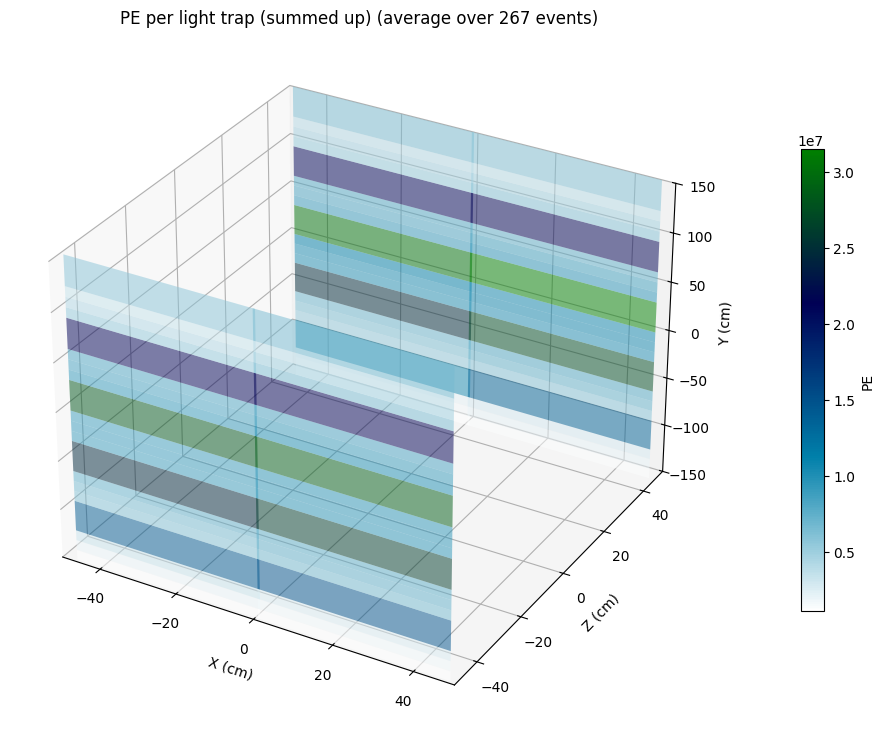

In [39]:
####PLOTE THE LIGHT SUMS per Trap!!
#### the following code snippets are not included in the next steps of the process yet


import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np

#pde_percent =  light_trap_pe_sums # Convert to percent
pde_percent = expected_total
pde_percent = np.asarray(pde_percent, dtype=float)  # avoid object dtype
#print(pde_percent)
# robust vmin/vmax
finite = np.isfinite(pde_percent)
if not np.any(finite):
    raise ValueError("All PDE % values are NaN/inf; nothing to normalize.")
vmin = np.nanmin(pde_percent)
vmax = np.nanmax(pde_percent)
print(vmax)
print(vmin)
if vmin == vmax:
    # avoid divide-by-zero in normalization
    vmax = vmin + 1e-12

norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
cmap = plt.cm.ocean_r
cmap.set_bad('lightgray', alpha=0.6)  # how NaNs will look

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for result, value in zip(all_results, pde_percent):
    x0, y0, x1, y1, z_det, *_ = result
    corners = [
        [x0, z_det, y0],
        [x1, z_det, y0],
        [x1, z_det, y1],
        [x0, z_det, y1]
    ]
    c = cmap(norm(value))           # NaNs map to the “bad” color
    rect = Poly3DCollection([corners], facecolors=c, alpha=0.5)
    ax.add_collection3d(rect)
# Set up colormap and normalization range
"""
vmin = np.min(pde_percent)
vmax = np.max(pde_percent)
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.ocean_r

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')


# Plot rectangles
for result, value in zip(all_results, pde_percent):
    x0, y0, x1, y1, z_det, *_ = result
    corners = [
        [x0, z_det, y0],
        [x1, z_det, y0],
        [x1, z_det, y1],
        [x0, z_det, y1]
    ]
    color = cmap(norm(value))  # Map actual PDE % through normalized colormap
    print(norm(value))
    rect = Poly3DCollection([corners], color=color, alpha=0.5)
    ax.add_collection3d(rect)
"""
# Colorbar setup — use the same normalization!
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Just to make matplotlib happy
cbar = plt.colorbar(sm, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label('PE')

# Axes setup
ax.set_xlabel('X (cm)')
ax.set_ylabel('Z (cm)')
ax.set_zlabel('Y (cm)')
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
ax.set_zlim(-150, 150)
ax.set_title(f'PE per light trap (summed up) (average over {max_events} events)')

plt.show()

46941.68247190593
3720.9217160818566


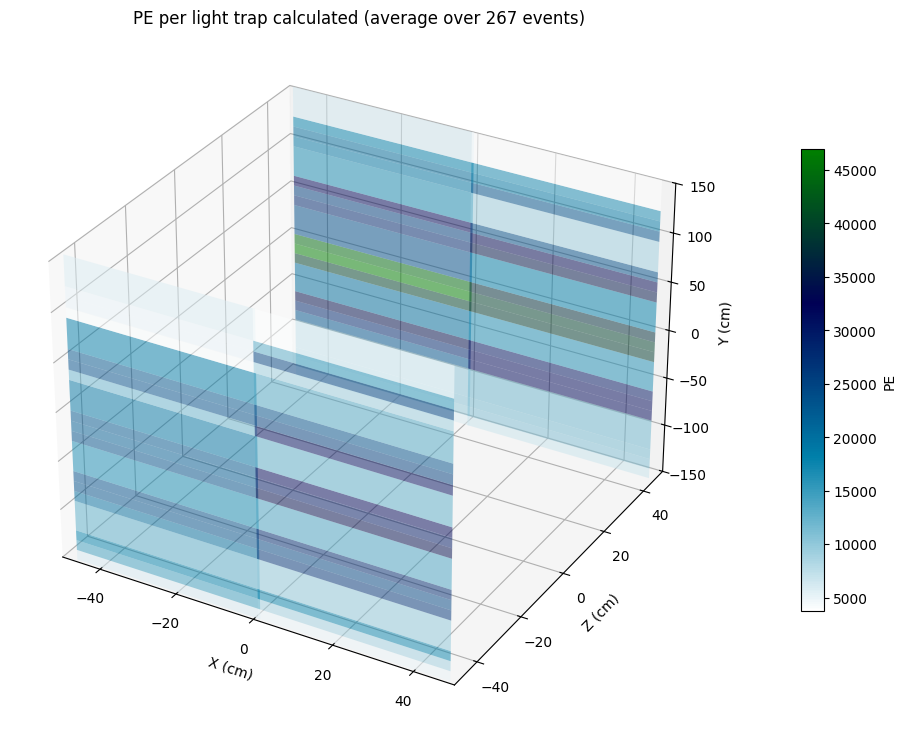

In [40]:
####PLOTE THE LIGHT CALCULATED per Trap!!
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np

#pde_percent =  detected_all# light_trap_pe_sums # Convert to percent

pde_percent = real_sum_total_pe
pde_percent = np.asarray(pde_percent, dtype=float)  # avoid object dtype
#print(pde_percent)
# robust vmin/vmax
finite = np.isfinite(pde_percent)
if not np.any(finite):
    raise ValueError("All PDE % values are NaN/inf; nothing to normalize.")
vmin = np.nanmin(pde_percent)
vmax = np.nanmax(pde_percent)
print(vmax)
print(vmin)
if vmin == vmax:
    # avoid divide-by-zero in normalization
    vmax = vmin + 1e-12

norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
cmap = plt.cm.ocean_r
cmap.set_bad('lightgray', alpha=0.6)  # how NaNs will look

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for result, value in zip(all_results, pde_percent):
    x0, y0, x1, y1, z_det, *_ = result
    corners = [
        [x0, z_det, y0],
        [x1, z_det, y0],
        [x1, z_det, y1],
        [x0, z_det, y1]
    ]
    c = cmap(norm(value))           # NaNs map to the “bad” color
    rect = Poly3DCollection([corners], facecolors=c, alpha=0.5)
    ax.add_collection3d(rect)
# Set up colormap and normalization range
"""
vmin = np.min(pde_percent)
vmax = np.max(pde_percent)
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.ocean_r

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')


# Plot rectangles
for result, value in zip(all_results, pde_percent):
    x0, y0, x1, y1, z_det, *_ = result
    corners = [
        [x0, z_det, y0],
        [x1, z_det, y0],
        [x1, z_det, y1],
        [x0, z_det, y1]
    ]
    color = cmap(norm(value))  # Map actual PDE % through normalized colormap
    print(norm(value))
    rect = Poly3DCollection([corners], color=color, alpha=0.5)
    ax.add_collection3d(rect)
"""
# Colorbar setup — use the same normalization!
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Just to make matplotlib happy
cbar = plt.colorbar(sm, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label('PE')

# Axes setup
ax.set_xlabel('X (cm)')
ax.set_ylabel('Z (cm)')
ax.set_zlabel('Y (cm)')
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
ax.set_zlim(-150, 150)
ax.set_title(f'PE per light trap calculated (average over {max_events} events)')

plt.show()

In [41]:
fig = go.Figure()
pde_percent = pde_avg * 100  # Convert to percent
# Normalize color values

if not np.any(finite):
    raise ValueError("All PDE % values are NaN/inf; nothing to normalize.")
vmin = np.nanmin(pde_percent)
vmax = np.nanmax(pde_percent)
print(vmax)
print(vmin)
if vmin == vmax:
    # avoid divide-by-zero in normalization
    vmax = vmin + 1e-12

colors_norm = (pde_percent - vmin) / (vmax - vmin + 1e-8)
cmap = matplotlib.colormaps['ocean_r']

# Plot each trap as a 3D rectangle
for result, norm_val in zip(all_results, colors_norm):
    x0, y0, x1, y1, z_det, *_ = result
    x = [x0, x1, x1, x0, x0]
    y = [y0, y0, y1, y1, y0]
    z = [z_det]*5

    # Get RGBA color from matplotlib colormap, convert to hex
    rgba = cmap(norm_val)
    color = f'rgba({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)}, 0.6)'

    fig.add_trace(go.Scatter3d(
        x=x, y=z, z=y,  # Note: plotly uses (x, y, z), you have (x, z, y)
        mode='lines',
        line=dict(color='gray', width=2),
        surfaceaxis=1,  # tells plotly to fill in the shape
        # fill='toself',
        showlegend=False,
        surfacecolor=color,
        hoverinfo='none'
    ))

# Step 1: Convert 'ocean_r' colormap to Plotly colorscale
def mpl_to_plotly(cmap_name, n=256):
    cmap = matplotlib.colormaps['ocean_r']
    colorscale = []
    for i in range(cmap.N):
        r, g, b, _ = cmap(i)
        colorscale.append([i / (cmap.N - 1), f'rgb({int(r*255)}, {int(g*255)}, {int(b*255)})'])
    return colorscale

colorscale = mpl_to_plotly('ocean_r')
# Create a dummy scatter for the colorbar
dummy_scatter = go.Scatter3d(
    x=[None], y=[None], z=[None],  # invisible
    mode='markers',
    marker=dict(
        size=0.0001,
        color=[vmin, vmax],  # use full color range
        colorscale=colorscale,
        cmin=vmin,
        cmax=vmax,
        colorbar=dict(
            title='PDE (%)',
            thickness=20,
            len=0.75
        )
    ),
    showlegend=False
)
fig.add_trace(dummy_scatter)

# Set up layout
fig.update_layout(
    scene=dict(
        xaxis_title='X (cm)',
        yaxis_title='Z (cm)',
        zaxis_title='Y (cm)',
        xaxis=dict(range=[-50, 50]),
        yaxis=dict(range=[-50, 50]),
        zaxis=dict(range=[-150, 150]),
    ),
    title=f'PDE per light trap (average over {max_events} events)',
    legend=None,
    width=900,
    height=800,
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

0.8809211910869034
0.04009915888161199
